In [85]:
# --dev-- reload functions
%run VIGOR_Functions

# to do list
# sessionlist as a csv file
# change names of pickle files to be more descriptive
# time in session -> confounded with effort (total distance traveled at a given speed) and reward (total reward earned)

<Figure size 432x288 with 0 Axes>

# set-up

## Imports

In [86]:
import datetime
import fnmatch
import matplotlib.cbook
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import scipy
from scipy import stats
import warnings

# session lists in a .py file
import sessionlists
import VIGOR_dataProcessing 
import VIGOR_WAITMODEL_Functions

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/HeathenToaster/code
    %cd code
%run VIGOR_Functions
plt.style.use('./Figures/test.mplstyle')

ModuleNotFoundError: No module named 'VIGOR_dataprocessing'

## Define data path.

In [ ]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/DATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1oxWJLF67TEifzQFgtUHIyhnEsS6AeQUW
    !unzip -qq /content/code/datacopy.zip
    root="/content/code/datacopy"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)


Path to data is: /home/david/Desktop/DATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save


## Load processed data

In [ ]:
rat_markers = {}
sequence = {}

# define colors for each rat
palette = {'RatF00': (0.4, 0.0, 0.0), 'RatF01': (0.55, 0.13, 0.13), 'RatF02': (0.8, 0.2, 0.2), 'RatF03': (1, 0.6, 0.6),
            'RatM00': (0.0, 0.4, 0.0), 'RatM01': (0.13, 0.55, 0.13), 'RatM02': (0.2, 0.8, 0.2), 'RatM03': (0.6, 1.0, 0.6)}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'lesion', 'RatF02': 'normal', 'RatF03': 'lesion',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal', 'RatM03': 'normal'}

# define list of rats to be analyzed
# only these rats will be loaded and analyzed for now   
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02']  # [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'): rat_markers[animal]=[palette[animal], "$\u2640$", brainstatus_plot(brainstatus[animal])]
    elif fnmatch.fnmatch(animal, 'RatM*'): rat_markers[animal]=[palette[animal], "$\u2642$", brainstatus_plot(brainstatus[animal])]
    elif fnmatch.fnmatch(animal, 'Rat00*'): rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$", brainstatus_plot(brainstatus[animal])]
    else: print("error, this is not a rat you got here")

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + \
                                                TM20+TM10+TM2+TMrev2+TMrev10+TMrev20+\
                                                dist60bis+dist90bis+dist120bis)):
        # get the preprocessed data from the pickle file
        # In this notebook we only need the sequence of events, so we only load that
        sequence[animal, session] = get_from_pickle(root, animal, session, name="test.p")


# separate the data into time and reward bins for each experimental condition
# distances 
data60 = prepare_data(sequence, animalList, dist60)
data90 = prepare_data(sequence, animalList, dist90)
data120 = prepare_data(sequence, animalList, dist120)

# treadmill speeds
data20 = prepare_data(sequence, animalList, TM20)
data10 = prepare_data(sequence, animalList, TM10)
data2 = prepare_data(sequence, animalList, TM2+TMrev2)
datarev10 = prepare_data(sequence, animalList, TMrev10)
datarev20 = prepare_data(sequence, animalList, TMrev20)

# all conditions pooled
dataAll = prepare_data(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)

# distances bis
data60bis = prepare_data(sequence, animalList, dist60bis)
data90bis = prepare_data(sequence, animalList, dist90bis)
data120bis = prepare_data(sequence, animalList, dist120bis)


# for each session separate the data into time and reward bins for each experimental condition
data60_bysession = prepare_data_by_session(sequence, animalList, dist60)
data90_bysession = prepare_data_by_session(sequence, animalList, dist90)
data120_bysession = prepare_data_by_session(sequence, animalList, dist120)
data20_bysession = prepare_data_by_session(sequence, animalList, TM20)
data10_bysession = prepare_data_by_session(sequence, animalList, TM10)
data2_bysession = prepare_data_by_session(sequence, animalList, TM2+TMrev2)
datarev10_bysession = prepare_data_by_session(sequence, animalList, TMrev10)
datarev20_bysession = prepare_data_by_session(sequence, animalList, TMrev20)

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02


# Introduction

## Task  
The task and the main behavioral results are presented in notebook 1.  
We developed an automated foraging task in which water restricted rats have to run back and
forth on a treadmill to obtain drops of water. Within one hour-long session, the
probability of getting a reward was alternatively high and low in 5 min-long uncued
blocks (dark and light gray in fig.1).  

<img src="Figures/Picturetask1.png" alt="task" width="300"/>  

## Experimental conditions
Across sessions, we manipulated the effort rats had to produce by either
modifying the length of the treadmill while its speed remained null, or by
manipulating the speed and direction of the belt to facilitate or counteract the
animals' crossings.

<img src="Figures/conditions.png" alt="conditions" width="600"/>

# Aim of the Notebook 
One of the variables that we analyze is the duration of the idle times between 
two subsequent run epochs (orange part on the track of the animal, Fig 1A.).  
A quick analysis of the median idle time shows that it increases along the 
session and tends to be higher in low probability blocks, especially at 
the end of the session (Fig1B.); i.e. animals are less motivated/more tired 
as time passes, and modulate their idle time according to the reward probability.  

However, a simple analysis of the median fails to grasp the complexity of the data. 
For instance, we consider very long idle times as a feature and not as aberrant values (compared to most papers in the litterature (#REFS)).   

In this notebook we characterise how time and reward probability affects idle time.  

Fig 1.  
A) Position of an example animal across a 120 cm session. Blue is run epoch, orange is idle epoch.  
Reward probability in 5 min blocks is either high (90%, dark gray), or low (10%, light gray)  
B) Median idle time across session and blocks.  
Reward probability in 5 min blocks is either high (90%, dark gray), or low (10%, light gray)  

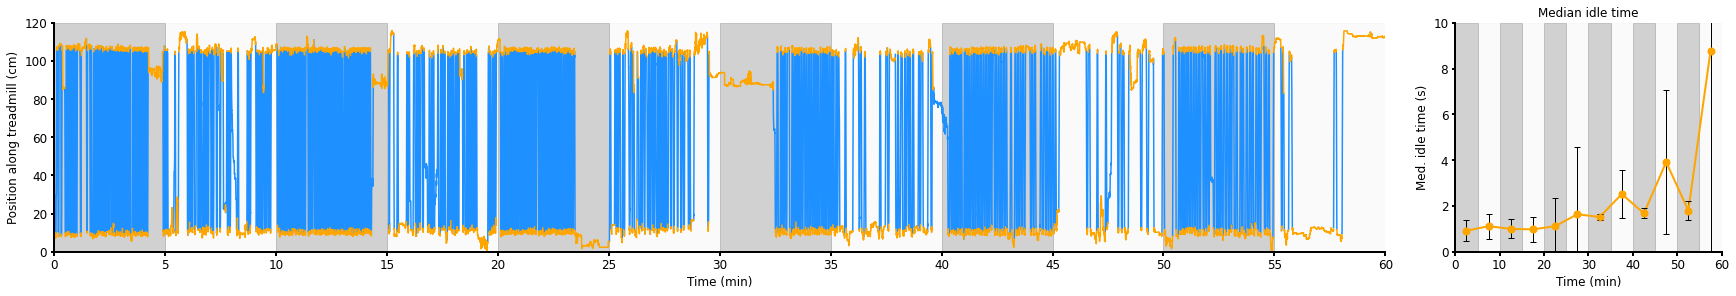

In [ ]:
# Fig 1.
animal, session = 'RatM01', 'RatM01_2021_07_22_17_14_48'  # 'RatF00', 'RatF00_2021_07_24_15_28_05'
fig, axs = plt.subplots(1, 2, figsize = (24, 4), gridspec_kw={'width_ratios': [5, 1]})

# Load preprocessed data for one animal and one session. params contains the parameters of the session,
# idleTimeInLeftBin and idleTimeInRightBin contain the idle time in each time bin for each animal
example_params = get_from_pickle(root, animal, session, name="params.p")
example_idleTimeInLeftBin, example_idleTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")

# plot the trajectory
plot_animal_trajectory(root=root, animal=animal, session=session, params=example_params, barplotaxes=[0, 3600, 0, 120], 
                 xyLabels=["Time (min)", "Position along treadmill (cm)"], title="Position of example animal across a 120 cm session", ax=axs[0])

# plot the median idle time in each time block
plot_median_per_bin([example_idleTimeInLeftBin[i]+example_idleTimeInRightBin[i] for i in range(0, 12)], 
                example_params['rewardProbaBlock'], example_params['blocks'], barplotaxes=[0, 3600/60, 0, 10], 
                color=['orange'], xyLabels=["Time (min)","idle time (s)"], title="Median idle time", scatter=False, stat='Med. ', ax=axs[1]);

# Data binning

To see the effect of **reward probability** $R$ we chose to use the history of rewards obtained by the rat over the previous trials.  
We chose reward history to see how rats detect transitions from/to high and low reward probability blocks. In high (low) probability blocks, the average number of rewards obtained in the previous trials is high (low); the average number of rewards decreases (increases) when transitioning into low (high) reward probability blocks. (WE DON'T TALK ABOUT THIS ANALYSIS ANYMORE).  

The reward history is defined as the average number of rewards obtained over the 3 previous runs. With a memory span of 3, there is 4 possible reward histories: with $\frac{3}{3}$ rewards obtained we have a reward history of $1$; the other possible combinations are $\frac{2}{3}=0.67$, $\frac{1}{3}=0.33$ and $\frac{0}{3}=0$. In the rest of the notebook the list of reward histories follows this order: [1, 0.67, 0.33, 0].  
In Fig 2.A we select all the idle times that occured after $\frac{2}{3}=0,67$ rewards obtained in a session (black + gray circled sequences).  

To see the effect of **time** $t$, we chose to split the dataset in 6 * 10 min bins. This allows a good resolution for the temporal evolution and ensures that all reward history combinations are represented in each bin. In the idle times after $\frac{2}{3}=0,67$ rewards obtained, we can select the ones occuring in the first 10 minutes (black circled sequences, Fig 2A.).  

The distribution of the idle times occuring after $\frac{2}{3}=0,67$ and in the first 10 minutes is shown in figure 2B.  
We represent the inverse cumulative distribution of the same data in a log-log plot as some idle times are **very long** (>50s, Fig 2C.). 


A) reward sequence in a session, each line a 5 min block, each dot a rewarded (green) or not rewarded (red) run. 
Rectangles: sequences matching the target sequence (here $\frac{2}{3}$ rewards obtained).  
Colors: black 0-10 mins | gray the rest   
B) distribution (PDF) of the idle times occuring after $\frac{2}{3}=0,67$ and in the first 10 minutes
C) same as B, but in 1-CDF. Because we have very long waits, we use a log scale.  

Number of trials in one session: 29


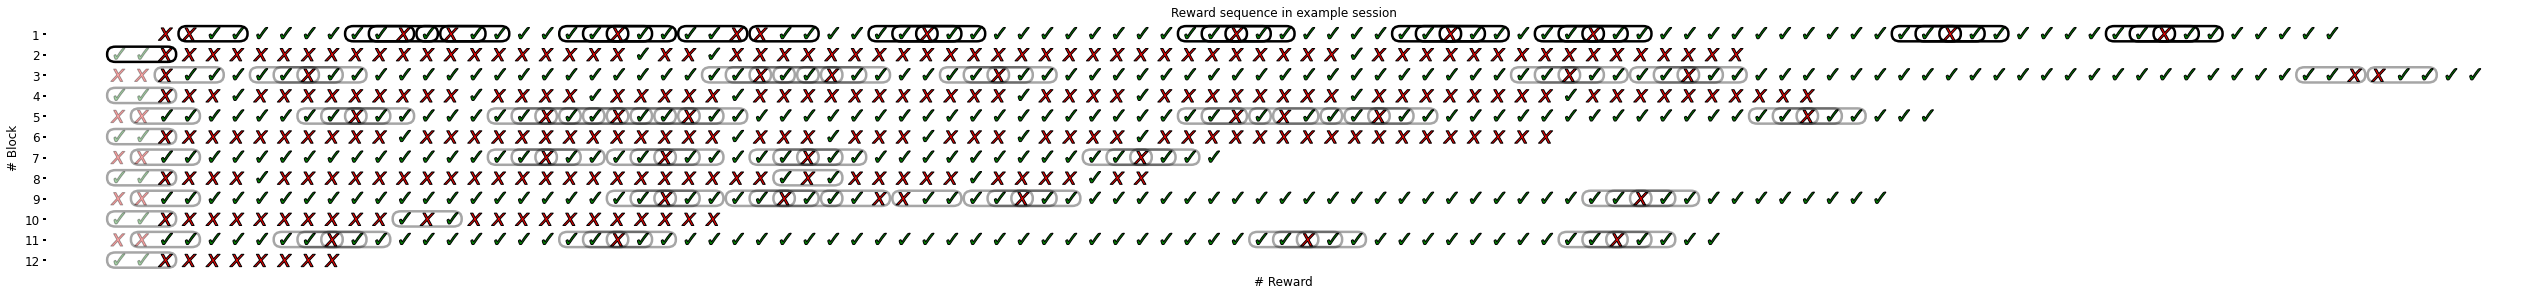

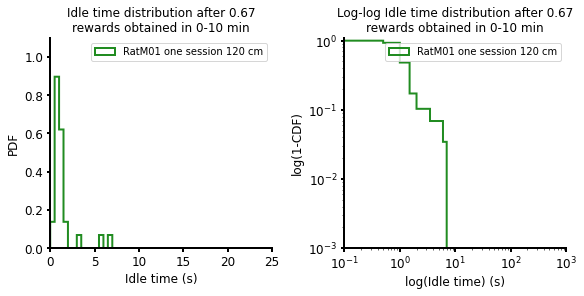

In [ ]:
# Fig 2.
# plot reward sequence in example session
fig, ax = plt.subplots(1, figsize=(35, 4))
avg = 0.67  # i.e. yes, yes, no
waits_one_session = plot_rewards(sequence[animal, session], avg=avg, ax=ax, filter=[0, 600])

# plot distribution of idle time following 0.67 R in the first 10 min in example session
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_rewards_distribution(waits_one_session, avg=avg, color=rat_markers[animal][0], ax=ax, label=f'{animal} one session 120 cm');
print(f'Number of trials in one session: {len(waits_one_session)}')

This leads to small subsets (i.e. n=29 in this case. Accentuated at the end of the sessions), so we pool data for each experimental condition (i.e. all sessions for a rat at 60cm distance, all sessions for a rat at 120cm distance, etc.).  

A&B) same as above for the same rat but we pooled all 120 cm sessions.

Number of trials in all 120 cm sessions: 156


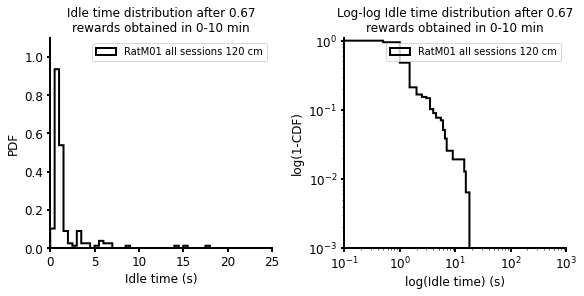

In [ ]:
# plot distribution of idle time following 0.67 R in the first 10 min in all 120 cm sessions
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
exampledata = prepare_data(sequence, animalList, dist120)[animal][0][1]  # time_bin 0 -> 0-10 min ||| rwd_bin 1 -> 0.67
plot_rewards_distribution(exampledata, avg=avg, color='k', ax=ax, label=f'{animal} all sessions 120 cm');
print(f'Number of trials in all 120 cm sessions: {len(exampledata)}')

# Complete distribution
We have the distribution of the idle times occuring after $\frac{2}{3}=0,67$ and in the first $10$ minutes for a rat. 
For the same rat, we can also get the distributions for the other reward histories ($1, 0.33, 0$) and the other time bins (from $10$ min to $60$ min).  
These distributions are shown in Fig 3. The one colored in black is the distribution of the idle times occuring after $\frac{2}{3}=0,67$ and in the first $10$ minutes seen previously. 

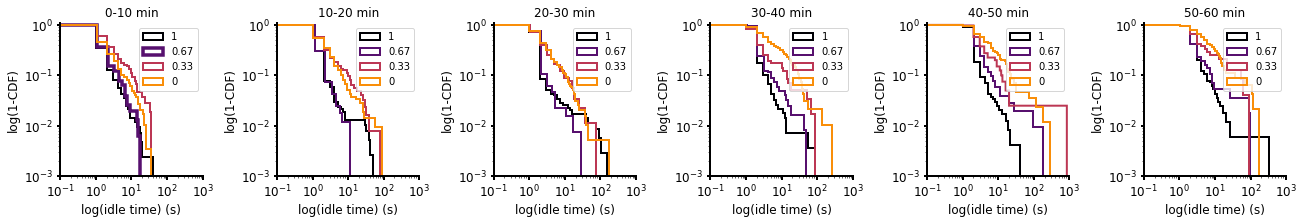

In [ ]:
# Fig 3.
# distribution of waiting times

animal = 'RatM01'
exampledata = prepare_data(sequence, animalList, dist120)
plot_full_distribution(exampledata, animal, plot_fit=False)

# Drift diffusion model

## One-bound DDM
We have the intuition that before leaving, the rat accumulates motivation. The amount of motivation needed to start running and the speed at which it accumulates can be modelled with a simple one-bound drift diffusion model (e.g. Ratcliff, Van Dongen, 2011; Ratcliff, 2015).  

The one-bound diffusion model describes a continuous time-stochastic accumulation process in which a quantity $X$ continuously accumulates until reaching a threshold.  

Intuition that $X$ is *motivation* that is accumulated at a given rate $\color{red}{v}$ (with gaussian noise $\epsilon(0, \eta=1)$) until it reaches a threshold $\color{blue}{A}$ at time $t_f$, at which the animal starts to run again. $\color{green}{t_0}$ (fixed to $0$) is the time lapsed outside (before and/or after) of the process.  

Illustration of the one-bound drift diffusion model and resulting distribution.

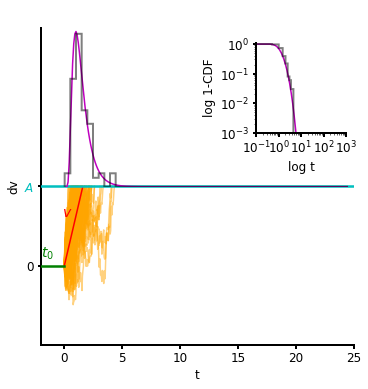

In [ ]:
# Fig 4. plot DDM example with *fast* accumulation

std = 1
t0 = 2
N = 100

plot_DDMexample(.25, std, 10, t0, N=N, title="")

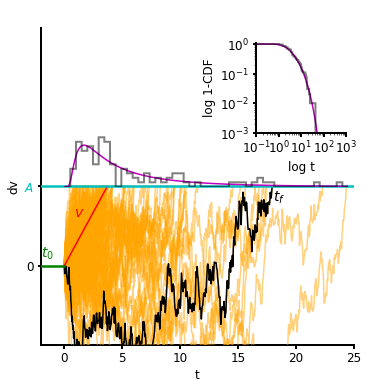

In [ ]:
# Fig 4. plot DDM example with *slow* accumulation
plot_DDMexample(.05, std, 10, t0, N=N, title="")

In [ ]:
# same plot but interactive
pl = interact(plot_DDMexampleParams, v=(0, 2, 0.1), A=(0, 5, 0.1));

interactive(children=(FloatSlider(value=1.0, description='v', max=2.0), FloatSlider(value=2.0, description='A'…

## Wald distribution

The explicit solution for the <span style="color:magenta">resulting distribution</span>  is the Wald distribution. (https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution)  
The probability density function of the Wald distribution is:  

$Wald(x|\alpha, \theta, \gamma) = \frac{\alpha}{\sqrt{2\pi (x-\theta)³}}\cdot exp{\left\{-\frac{[\alpha-\gamma (x-\theta)]²}{2(x-\theta)}\right\}}$  

The wald distribution has 3 parameters: $\alpha$, $\theta$, $\gamma$.  
- $\alpha$ is linked to the boundary $A$, 
- $\theta$ is linked to the non-decision time $t_0$,  
- and $\gamma$ is linked to the drift rate $v$.  

With the $\theta$ parameter fixed to $0$ the distribution simplifies to:     
$Wald(x|\alpha, \gamma) = \frac{\alpha}{\sqrt{2\pi x³}}\cdot exp{\left\{-\frac{[\alpha-\gamma x]²}{2x}\right\}}$  

&nbsp;  
A) Changes in the Wald distribution as a result of changes in the $\alpha$, $\theta$, $\gamma$ parameters.  
B) Interactive PDF  
C) Interactive CDF  



In [ ]:

pl = interact(plot_interactiveWald, alpha=(0, 5, 0.1), gamma=(-1, 5, 0.1), t_0=(0, 3, 0.1));

interactive(children=(FloatSlider(value=1.0, description='alpha', max=5.0), FloatSlider(value=2.0, description…

## Fitting
We fit idle time distributions $x$ to the Wald distribution using the maximum likelihood estimation method.
We find the parameters $\hat{\alpha}, \hat{\gamma}$ that maximizes the log-likelihood function $\ell (Wald(x); \alpha, \gamma)$, with $\alpha, \gamma \in \mathrm{A}, \Gamma$, using the default 'L-BFGS-B' method from scipy. https://en.wikipedia.org/wiki/Limited-memory_BFGS#L-BFGS-B  
 
Fig 5.
Sanity check: We generate synthetic idle times from a Wald distribution with known $\alpha, \gamma$ parameters, and fit them to check that the fitted parameters are the same as the known parameters. We are able to recover the parameters well (QUANTIFY).  

TOP LEFT) Synthetic data fit with different values of $\gamma$.  
TOP RIGHT) Synthetic data fit with different values of $\alpha$  
BOT LEFT&RIGHT) Hidden (lines) and recovered (dots) parameters

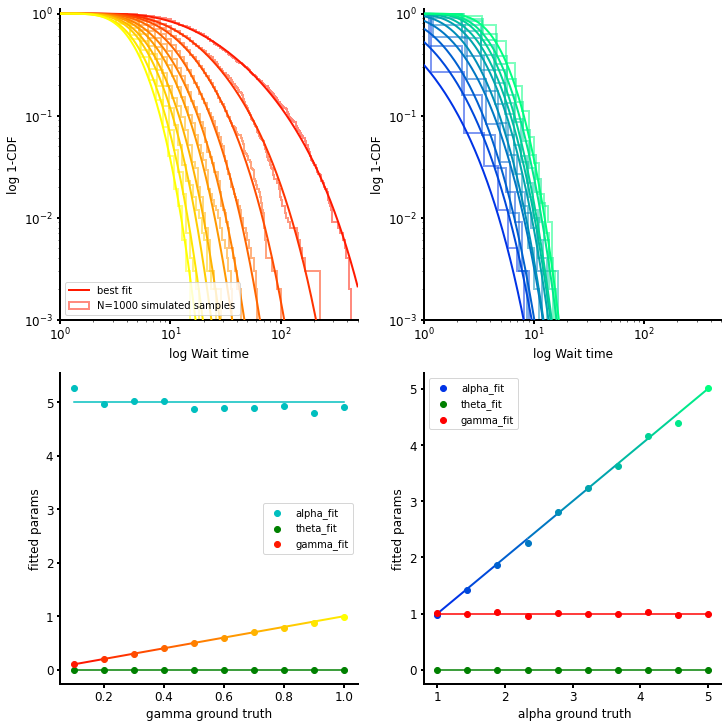

In [ ]:
t0 = 0
N = 1000
std = 1
AAA = 5
MEAN = 1

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

means = np.linspace(0.1, 1, 10)
plot_color_line(axs[1, 0], means, means, means, cmap = 'autumn', vmin=0, vmax=1, alpha=1, linewidth=2, linestyle = '-', zorder = 1)
axs[1, 0].plot(means, [t0 for _ in means], color='g')
axs[1, 0].plot(means, [AAA for _ in means], color='c')
for mean in means:
    alpha, theta, gamma, lossWald = example_wald_fit(mean, std, AAA, t0, N, ax=axs[0, 0], color=plt.get_cmap('autumn')(mean / max(means)))
    axs[1, 0].scatter(mean, alpha, color='c', label='alpha_fit')
    axs[1, 0].scatter(mean, theta, color='g', label='theta_fit')
    axs[1, 0].scatter(mean, gamma, color=plt.get_cmap('autumn')(mean / max(means)), label='gamma_fit')
    axs[1, 0].set_xlabel('gamma ground truth')
    axs[1, 0].set_ylabel('fitted params')

As = np.linspace(1, 5, 10)
plot_color_line(axs[1, 1], As, As, As, cmap = 'winter', vmin=0, vmax=5, alpha=1, linewidth=2, linestyle = '-', zorder = 1)
axs[1, 1].plot(As, [t0 for _ in As], color='g')
axs[1, 1].plot(As, [MEAN for _ in As], color='r')
for A in As:
    alpha, theta, gamma, lossWald = example_wald_fit(MEAN, std, A, t0, N, ax=axs[0, 1], color=plt.get_cmap('winter')(A / max(As)))
    axs[1, 1].scatter(A, alpha, color=plt.get_cmap('winter')(A / max(As)), label='alpha_fit')
    axs[1, 1].scatter(A, theta, color='g', label='theta_fit')
    axs[1, 1].scatter(A, gamma, color='r', label='gamma_fit')
    axs[1, 1].set_xlabel(' alpha ground truth')
    axs[1, 1].set_ylabel('fitted params')


legend_without_duplicate_labels(axs[1, 0])
legend_without_duplicate_labels(axs[1, 1])

# Idle time model


We have the Wald distribution with $\alpha$ and $\gamma$ parameters that we can fit and recover from individual idle times distributions. 
We've seen earlier that the sub-distributions of idle times in our data changes with time $t$ and the reward history $R$.  
Can we link $t$ and $R$ to $\alpha$ and/or $\gamma$?  

To evaluate how $\alpha$ and $\gamma$ change with $t$ and/or $R$ we define the following model:

$\mathrm{A}(t, R) = \alpha_0 + \alpha_t t + \alpha_R R$  
$\Gamma(t, R) = \gamma_0 + \gamma_t t + \gamma_R R$  

With:  
$\alpha_0, \gamma_0$ parameters at the beginning of the session (0-10 min) and $\frac{3}{3}$ rewards have been obtained  
$\alpha_t, \gamma_t$ how $\alpha$ and $\gamma$ evolve linearly with time  
$\alpha_R, \gamma_R$ how $\alpha$ and $\gamma$ evolve linearly with reward history  


We find the best $\alpha_0, \alpha_t, \alpha_R, \gamma_0, \gamma_t, \gamma_R$ that minimize the total error of the model using maximum likelihood estimation.  

The total error of the model is defined as:  
$\sum_{n_t=0}^{6} \sum_{n_R=0}^{1} \frac{\ell (Wald(x(t, R)); \alpha_0 + \alpha_t + \alpha_R, \gamma_0 + \gamma_t + \gamma_R)}{N(t, R)}$  

with:  
$x$, experimental data  
$x(t, R)$, experimental data for a given $t$ and $R$  
$N(t, R)$, number of observations in $x(t, R)$


## Graphical representation of $\alpha$ and $\gamma$ evolution
Evolution of $\mathrm{A}$ and $\Gamma$ on the z axis, with $R$ on the x axis, $t$ on the y axis.  
- $\mathrm{A}$: starts low, increases with $t$, no big change with $R$  
- $\Gamma$: starts high, decreases with $t$ and $R$. 

RatF01  α:1.10, αt:0.19, αR: 0.02, || γ: 0.57, γt: -0.02, γR: -0.14 ||| loss: 59.47


/home/david/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:137: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


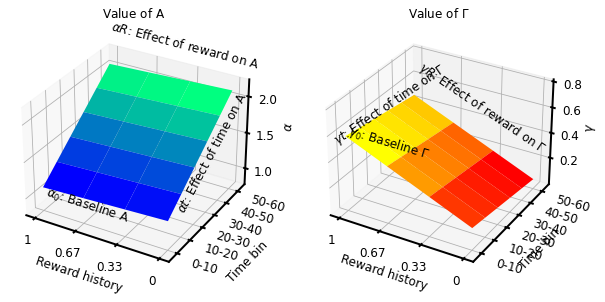

In [ ]:
# NOT THE SAME ANIMAL AS BEFORE (RatM01)!!!!!!!!

# example fit model on all 120 cm session for each animal
# print fitted parameters and loss for each animal
animal = 'RatF01'
exampledata = prepare_data(sequence, animalList, dist120)
p, loss = modelwald_fit(exampledata[animal])
(alpha, theta, gamma, alpha_t, thetaprime, gamma_t, alpha_R, thetasecond, gamma_R) = p

print(f"{animal}  α:{alpha:.2f}, αt:{alpha_t:.2f}, αR: {alpha_R:.2f}, || γ: {gamma:.2f}, γt: {gamma_t:.2f}, γR: {gamma_R:.2f} ||| loss: {loss:.2f}")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})
plot_parameter_evolution((alpha, gamma, alpha_t, gamma_t, alpha_R, gamma_R), axs=axs)

# Results
### Example animal fit - 120cm
Fit of the model for the same example animal on all Dist-120cm sessions.  

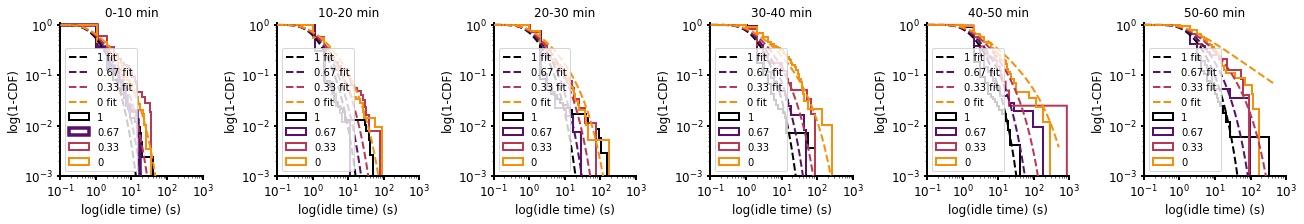

In [ ]:
animal = 'RatM01'
exampledata = prepare_data(sequence, animalList, dist120)
plot_full_distribution(exampledata, animal, plot_fit=True)

### All experimental conditions fit
We can now do the same as above for all experimental conditions (Distances and TM speed) and for each rat.  
Each color is a different rat.  

$\mathrm{A}$:  
- $\alpha_0$ > 0, positive bound at start  
- $\alpha t$ > 0, $\alpha$ increases with time  
- $\alpha R$ ~ 0, no effect of reward history on $\alpha$  

The distance to boundary $A$ increases with time, but not with reward history.  
With time, need more motivation to start running.  

**This is either congruent with *satiety*, which is low at the start of the session and increases with the total number of rewards obtained, or with *tiredness*, which is low at the start of the session and increases with the total distance travelled.**  
Being sated, you need more motivation to leave. Being tired you need more motivation to leave.

$\Gamma$:  
- $\gamma_0$ > 0, positive drift rate at start  
- $\gamma t$ < 0, $\gamma$ decreases with time  
- $\gamma R$ < 0, $\gamma$ decreases with reward history  

The drift rate $v$ decreases with time, and with reward history.  

Accumulation of motivation is slower with time, and is slower when reward history is low (few rewards over previous trials).  
With time, motivation accumulation is slower. When reward history is low, motivation accumulation is slower.  

**This is congruent with the *perceived value of reward*, it is higher at the beginning of the session compared to the end, and it is higher when the probability of receiving it is high, compared to low.**
Perceived value is Probability to get it * how much you want it.  


However, we do not see a clear effect of experimental conditions on $\mathrm{A}$ and $\Gamma$.  
In our case, the experimental conditions impact the amount of effort the animal needs to provide to get the reward, by either increasing the physical distance or facilitating/impeding each crossing.  
Therefore, it seems that the amount of effort required has no impact on the idle time!!!  
**The role of $\alpha$ in capturing *tiredness* is therefore not plausible**


Maybe we see no effect of condition because:  
- animals are too thirsty? *no*, they would not stop running at the end if they were that thirsty.  
- the amount of effort required is not enough? *no*, we see a decrease in the running speed with time.  

**!!! Do stats !!!**

3 2 vs rev20: 0.040 *


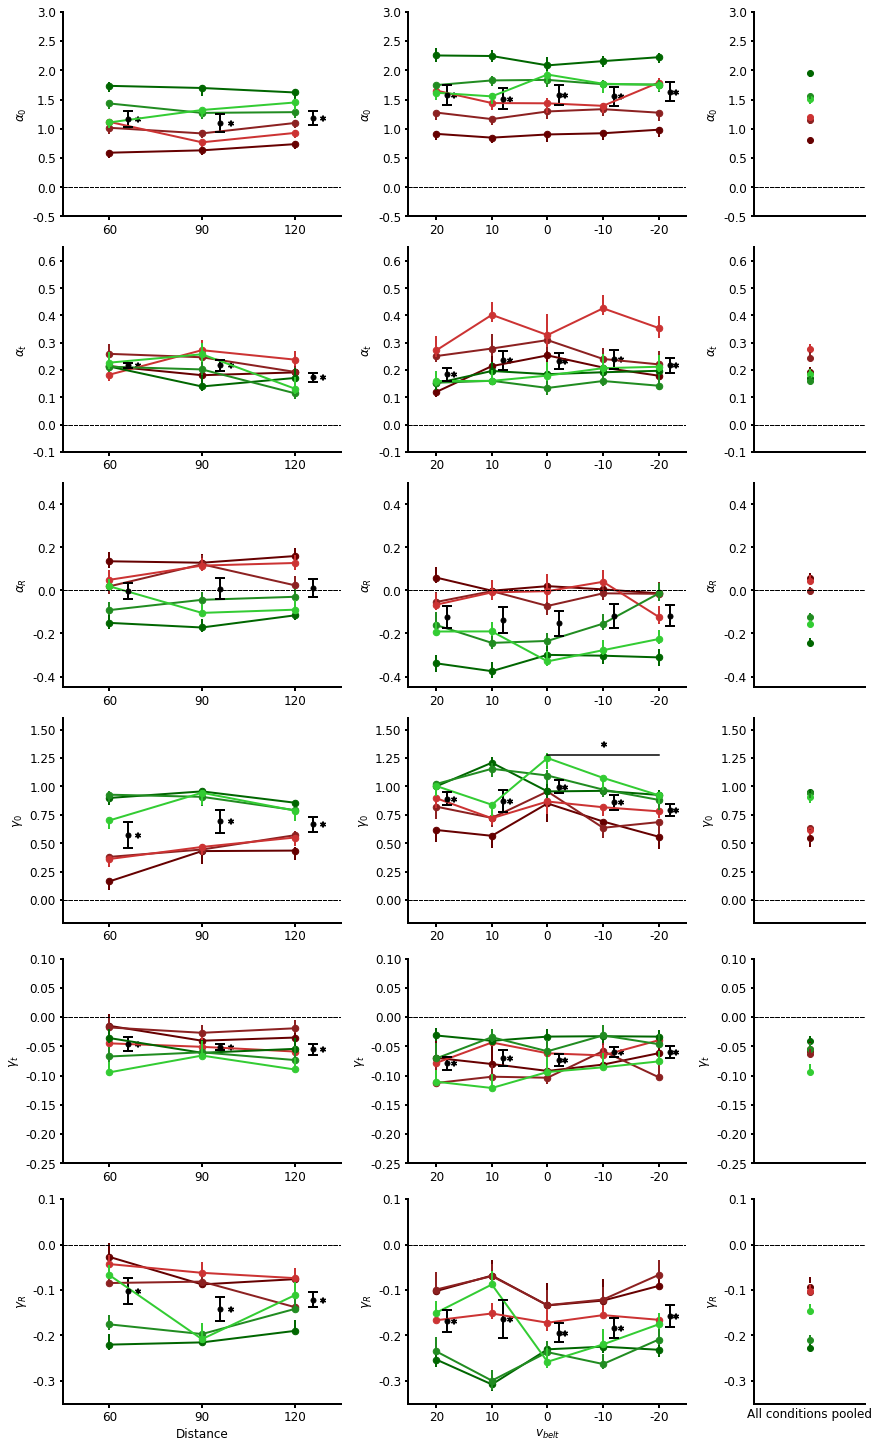

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(12, 20), gridspec_kw={'width_ratios': [5, 5, 2]})

ylabels = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_R$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$"]
ylims = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]

alpha, gamma, alpha_t, gamma_t, alpha_R, gamma_R, lossWald = {}, {}, {}, {}, {}, {}, {}
alphaPool, gammaPool, alpha_tPool, gamma_tPool, alpha_RPool, gamma_RPool, lossWaldPool = {}, {}, {}, {}, {}, {}, {}

alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, True, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = True, True, True, True

if os.path.exists("picklejar/resamplingParameters100ITER.p"):
    alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = pickle.load(open("picklejar/resamplingParameters100ITER.p", "rb"))
else: 
    alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = {}, {}, {}, {}, {}, {}

if os.path.exists("picklejar/resamplingParameters100ITER_Pooled.p"):
    alpha_fitPooled, alpha_t_fitPooled, alpha_R_fitPooled, gamma_fitPooled, gamma_t_fitPooled, gamma_R_fitPooled = pickle.load(open("picklejar/resamplingParameters100ITER_Pooled.p", "rb"))
else:
    alpha_fitPooled, alpha_t_fitPooled, alpha_R_fitPooled, gamma_fitPooled, gamma_t_fitPooled, gamma_R_fitPooled = {}, {}, {}, {}, {}, {}

for animal in animalList:
    alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

    (alphaPool[animal], theta, gammaPool[animal], 
        alpha_tPool[animal], thetaprime, gamma_tPool[animal], 
        alpha_RPool[animal], thetasecond, gamma_RPool[animal]), lossWaldPool[animal] = modelwald_fit(dataAll[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                    gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                    )

    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
        (alpha[animal][cond], theta, gamma[animal][cond], \
        alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
        alpha_R[animal][cond], thetasecond, gamma_R[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                    gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                    )
    vars = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
    varsPool = [alphaPool, alpha_tPool, alpha_RPool, gammaPool, gamma_tPool, gamma_RPool]
    resampled = [alpha_fit, alpha_t_fit, alpha_R_fit, gamma_fit, gamma_t_fit, gamma_R_fit]
    resampledPooled = [alpha_fitPooled, alpha_t_fitPooled, alpha_R_fitPooled, gamma_fitPooled, gamma_t_fitPooled, gamma_R_fitPooled]

    def _percentiles(sample):
            s = np.sort(sample)
            return s[int(.05 * len(s))], s[int(.95 * len(s))]

    for i, (var, ylabel, ylim, resample) in enumerate(zip(vars, ylabels, ylims, resampled)):
        
        axs[i, 0].plot((0, 0), _percentiles(resample[animal]['60']), color=rat_markers[animal][0], lw=2)
        axs[i, 0].plot((1, 1), _percentiles(resample[animal]['90']), color=rat_markers[animal][0], lw=2)
        axs[i, 0].plot((2, 2), _percentiles(resample[animal]['120']), color=rat_markers[animal][0], lw=2)

        x, y = np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]]
        axs[i, 0].plot(x, y, color=rat_markers[animal][0], label=animal, marker='o', markersize=6.5, lw=2)
        # gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        # axs[i, 0].plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color=rat_markers[animal][0], lw=2 if p_value < .05 else .5)
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim, resample) in enumerate(zip(vars, ylabels, ylims, resampled)):

        axs[i, 1].plot((0, 0), _percentiles(resample[animal]['20']), color=rat_markers[animal][0], lw=2)
        axs[i, 1].plot((1, 1), _percentiles(resample[animal]['10']), color=rat_markers[animal][0], lw=2)
        axs[i, 1].plot((2, 2), _percentiles(resample[animal]['2']), color=rat_markers[animal][0], lw=2)
        axs[i, 1].plot((3, 3), _percentiles(resample[animal]['rev10']), color=rat_markers[animal][0], lw=2)
        axs[i, 1].plot((4, 4), _percentiles(resample[animal]['rev20']), color=rat_markers[animal][0], lw=2)

        x, y = np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 1].plot(x, y, color=rat_markers[animal][0], label=animal, marker='o', markersize=6.5, lw=2)
        # gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        # axs[i, 1].plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color=rat_markers[animal][0], lw=2 if p_value < .05 else .5)
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim, resample) in enumerate(zip(varsPool, ylabels, ylims, resampledPooled)):
        axs[i, 2].plot((0, 0), _percentiles(resample[animal]), color=rat_markers[animal][0], lw=2)

        x, y = 0, var[animal]
        axs[i, 2].scatter(x, y, color=rat_markers[animal][0])
        axs[i, 2].set_title(f"")
        axs[i, 2].set_xticks([])
        axs[i, 2].set_ylabel(ylabel)
        axs[i, 2].set_xlim(-.5, .5)
        axs[i, 2].set_ylim(ylim)
        axs[i, 2].axhline(0, color='black', linestyle='--', linewidth=1)


axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')
axs[i, 2].set_xlabel("All conditions pooled")

#mean per condition
for idx, cond in enumerate(["60", "90", "120"]):
    for jdx, var in enumerate([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))
        s, p = stats.ttest_1samp(d, 0)
        if p < .05: axs[jdx, 0].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 0].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

for idx, cond in enumerate(["20", "10", "2", "rev10", "rev20"]):
    for jdx, var in enumerate([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))
        s, p = stats.ttest_1samp(d, 0)
        if p < .05: axs[jdx, 1].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 1].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

test_all_conds_between_themselves(["60", "90", "120"], vars, ax=axs[:, 0])
test_all_conds_between_themselves(["20", "10", "2", "rev10", "rev20"], vars, ax=axs[:, 1])

pickle.dump([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R], open("picklejar/main_fitting_results.p", "wb"))
pickle.dump([alphaPool, alpha_tPool, alpha_RPool, gammaPool, gamma_tPool, gamma_RPool], open("picklejar/main_fitting_results_pooled.p", "wb"))


# Interindividual variability
We can also see some variability between animals. Is this an artifact of our fitting method or is it interindividual variability?  
Variability conserved between conditions.  
Male/female difference.  

Resampling.  
To test if the variability is due to the fit we perform a resampling.  
We use the fitted $\alpha_0, \alpha t, \alpha R, \gamma_0, \gamma t, \gamma R$ parameters for each rat to generate synthetic idle times. We then fit the synthetic data (for which we know the parameters, same number of synthetic data as experimental data) and recover a distribution of parameter estimation (N=100 iterations). The distribution of parameter estimation give us a confidence interval for each parameter. 
For each fitted value in the above plot, the error bars denote the 5-95th values obtained in the resampling. 

In [ ]:
# compute 
ITER = 100

alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R = pickle.load(open("picklejar/main_fitting_results.p", "rb"))

if os.path.exists("picklejar/resamplingParameters100ITER.p"):
    alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = pickle.load(open("picklejar/resamplingParameters100ITER.p", "rb"))

else:    
    alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = {}, {}, {}, {}, {}, {}
    alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
    for idx, animal in enumerate(animalList):
        alpha_fit[animal] = {}
        gamma_fit[animal] = {}
        alpha_t_fit[animal] = {}
        gamma_t_fit[animal] = {}
        alpha_R_fit[animal] = {}
        gamma_R_fit[animal] = {}

        for cond, sessions, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], 
                                        [matchsession(animal, dist60), matchsession(animal, dist90), matchsession(animal, dist120), 
                                            matchsession(animal, TM20), matchsession(animal, TM10), matchsession(animal, TM2), matchsession(animal, TMrev10), matchsession(animal, TMrev20)],
                                        [data60_bysession, data90_bysession, data120_bysession, 
                                            data20_bysession, data10_bysession, data2_bysession, datarev10_bysession, datarev20_bysession]):

            _alpha, _gamma, _alpha_t, _gamma_t, _alpha_R, _gamma_R = alpha[animal][cond], gamma[animal][cond], alpha_t[animal][cond], gamma_t[animal][cond], alpha_R[animal][cond], gamma_R[animal][cond]

            N_bins = 6
            N_avg = 4
            ALPHA = np.zeros((N_bins, N_avg))
            GAMMA = np.zeros((N_bins, N_avg))
            sample = np.zeros((N_bins, N_avg)).tolist()
            N_OBS = np.zeros((N_bins, N_avg))

            for session in sessions:
                for bin in range(0, N_bins):
                    for avg in range(0, N_avg):
                        N_OBS[bin][avg] += len(data[animal][session][bin][avg])

            for bin in range(0, N_bins):
                for avg in range(0, N_avg):
                    ALPHA[bin, avg] = _alpha + bin*_alpha_t + avg*_alpha_R
                    GAMMA[bin, avg] = _gamma + bin*_gamma_t + avg*_gamma_R

            iters = ITER
            alpha_fit[animal][cond] = np.zeros((iters))
            gamma_fit[animal][cond] = np.zeros((iters))
            alpha_t_fit[animal][cond] = np.zeros((iters))
            gamma_t_fit[animal][cond] = np.zeros((iters))
            alpha_R_fit[animal][cond] = np.zeros((iters))
            gamma_R_fit[animal][cond] = np.zeros((iters))

            fit_dicts = [alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit]

            for iter in range(0, iters):
                simple_progress_bar(iter, iters, animal, cond, bar_length=20)
                for bin in range(0, N_bins):
                    for avg in range(0, N_avg):
                        sample[bin][avg] = np.asarray(genWaldSamples(N_OBS[bin, avg], ALPHA[bin, avg], GAMMA[bin, avg]))

                (alpha_fit[animal][cond][iter], theta_fit, gamma_fit[animal][cond][iter], \
                    alpha_t_fit[animal][cond][iter], theta_prime_fit, gamma_t_fit[animal][cond][iter], \
                        alpha_R_fit[animal][cond][iter], theta_second_fit, gamma_R_fit[animal][cond][iter]), loss = modelwald_fit(sample, 
                                                                                                    alpha_t_fixed=alpha_t_fixed, 
                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                    gamma_R_fixed=gamma_R_fixed)
    pickle.dump([alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit], open("picklejar/resamplingParameters100ITER.p", "wb"))


condition is 120
condition is 120
condition is 120
condition is 120
condition is 120
condition is 120


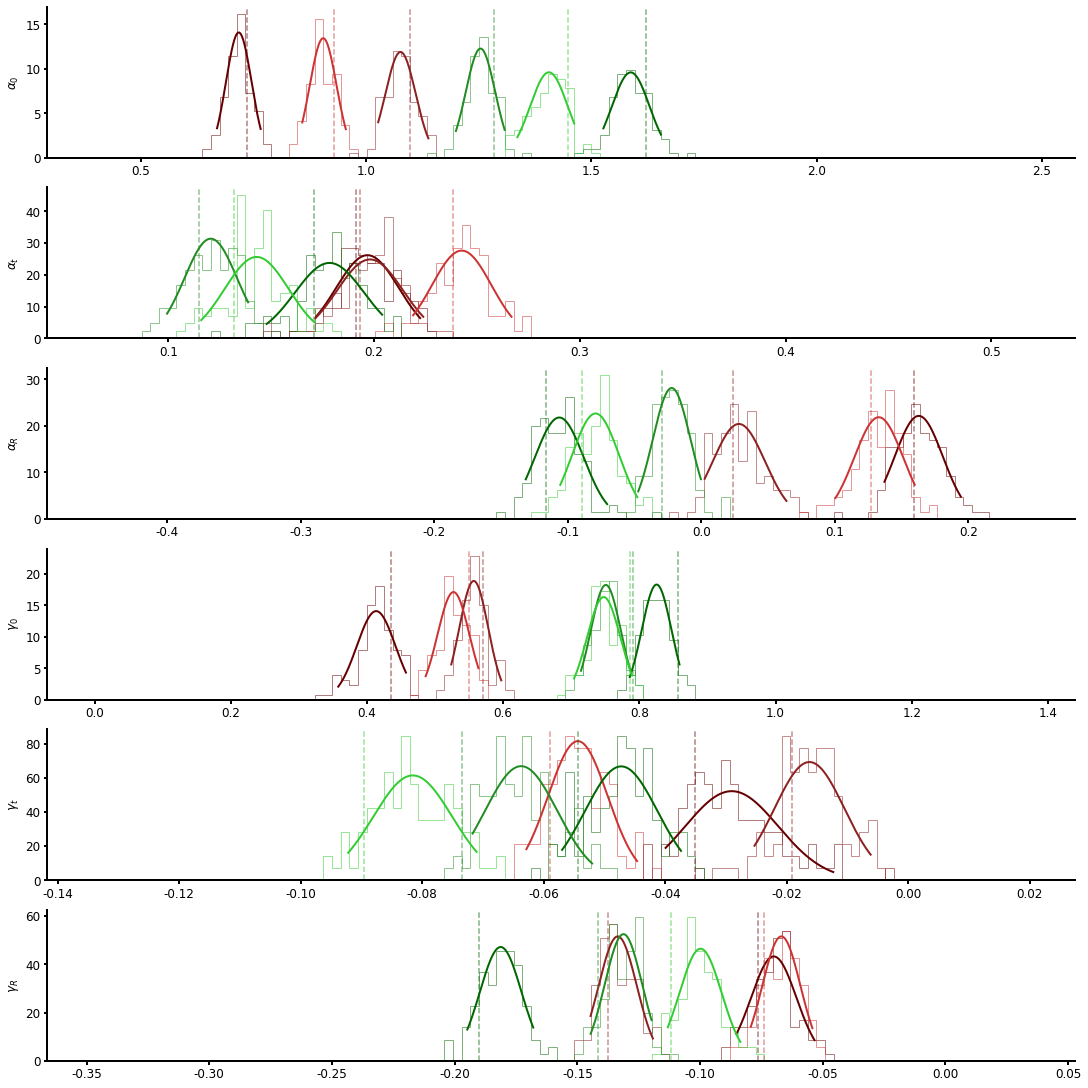

In [ ]:

fig, axs = plt.subplots(6, 1, figsize=(15, 15))
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R = pickle.load(open("picklejar/main_fitting_results.p", "rb"))
vars = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
resamples = [alpha_fit, alpha_t_fit, alpha_R_fit, gamma_fit, gamma_t_fit, gamma_R_fit]

from scipy.stats import norm
for animal in animalList:
    # for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]:
    # for cond in ["60", "90", "120"]:
    for cond in ["120"]:
        print(f'condition is {cond}')
        for i, (var, resample, ylabel, ylim) in enumerate(zip(vars, resamples, ylabels, ylims)):
            axs[i].axvline(var[animal][cond], color=rat_markers[animal][0], ls="--", alpha=.5)
            _temp = [list(list(resample.values())[_].values()) for _ in range(len(resample.values()))]

            s = sorted(resample[animal][cond])
            minbin , maxbin = np.min(_temp), np.max(_temp)
            min, max = s[int(.05*ITER)], s[int(.95*ITER)]
            bins = np.linspace(minbin, maxbin, 100)
            
            axs[i].hist(resample[animal][cond], bins=bins, 
                    histtype='step', color=rat_markers[animal][0], alpha=.5, density=True)
            x = np.linspace(min, max, 1000)
            k2, p = stats.normaltest(resample[animal][cond])
            _pdf = norm.pdf(x, np.mean(resample[animal][cond]), np.std(resample[animal][cond]))
            # print(f"{animal} {cond} {ylabel} {np.mean(resample[animal][cond]):.2f} {np.std(resample[animal][cond]):.2f} {k2:.2f} {p:.2f}")
            axs[i].plot(x, _pdf, color=rat_markers[animal][0], linewidth=2)
            axs[i].set_ylabel(ylabel)
            offset = (maxbin - minbin) * .1
            axs[i].set_xlim(minbin-offset, maxbin+offset)


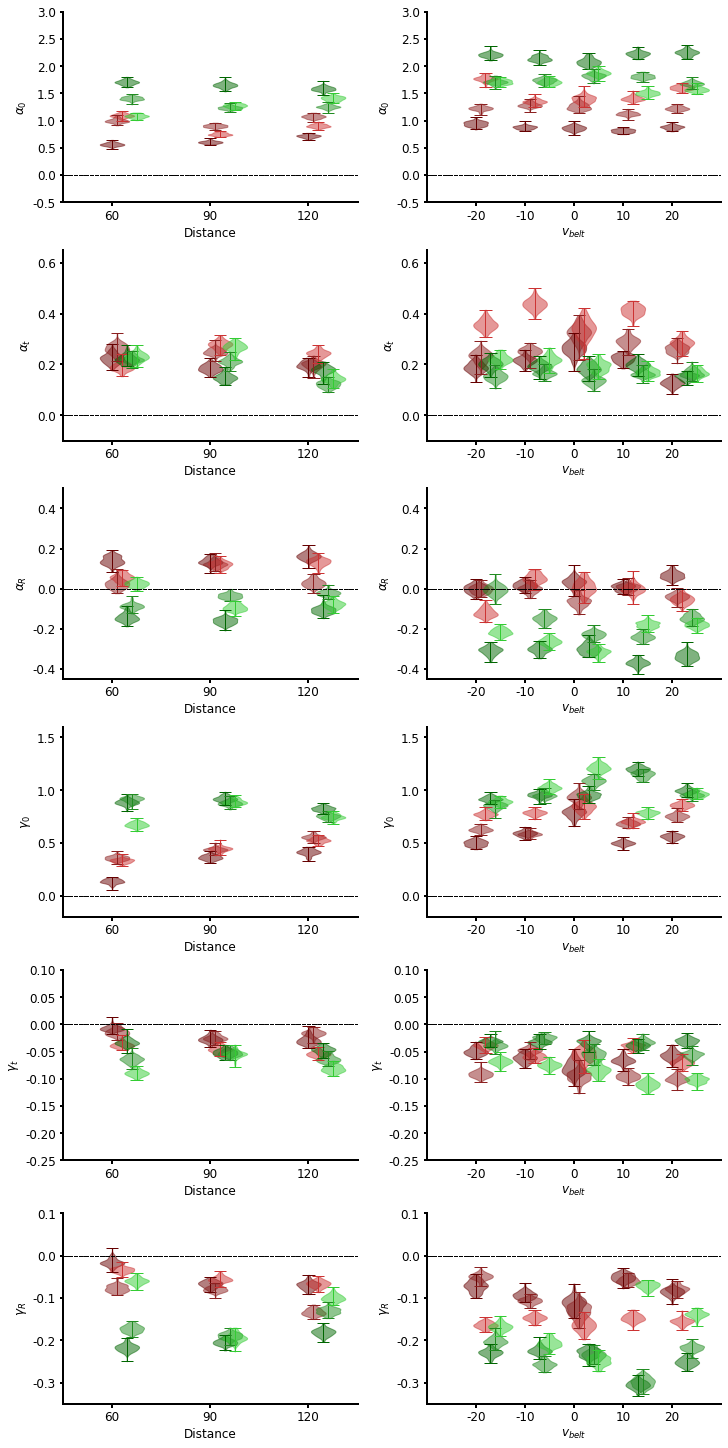

In [ ]:
# plot the sample fits
# function that
# REDO OK but now need 100 iterations
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
ITER = 100
violin = True
for idx, animal in enumerate(animalList):
    for x, cond in zip([0, 2, 4, 4, 3, 2, 1, 0], ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]):

        _alpha, _gamma, _alpha_t, _gamma_t, _alpha_R, _gamma_R = alpha[animal][cond], gamma[animal][cond], alpha_t[animal][cond], gamma_t[animal][cond], alpha_R[animal][cond], gamma_R[animal][cond]
        truths = [_alpha, _alpha_t, _alpha_R, _gamma, _gamma_t, _gamma_R]

        ylims = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]
        vars = [alpha_fit[animal][cond], alpha_t_fit[animal][cond], alpha_R_fit[animal][cond], gamma_fit[animal][cond], gamma_t_fit[animal][cond], gamma_R_fit[animal][cond]]
        if cond in ["60", "90", "120"]:
            for i, (var, ylabel, ylim, true) in enumerate(zip(vars, ylabels, ylims, truths)):
                if violin:
                    violin_parts = axs[i, 0].violinplot(var, positions=[x + (idx/10)])#, showmeans=True, showextrema=True, showmedians=False)
                    for vp in violin_parts['bodies']:
                        vp.set_facecolor(rat_markers[animal][0])
                        vp.set_edgecolor(rat_markers[animal][0])
                        # vp.set_facecolor('gray')
                        # vp.set_edgecolor('gray')
                        vp.set_linewidth(1)
                        vp.set_alpha(0.5)

                    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
                        try:
                            vp = violin_parts[partname]
                            vp.set_edgecolor(rat_markers[animal][0])
                            # vp.set_edgecolor('gray')
                            vp.set_linewidth(1)
                        except: pass

                else:
                    axs[i, 0].scatter([x + np.random.normal(0, .0)+(idx/10) for i in range(ITER)], var, color=rat_markers[animal][0], alpha=.25, linewidth=1, edgecolors='gray')
                    axs[i, 0].scatter([x + (idx/10)], true, color=rat_markers[animal][0], alpha=1, linewidth=1, edgecolors='k', zorder=10)
                axs[i, 0].set_title(f"")
                axs[i, 0].set_xticks([0, 2, 4])
                axs[i, 0].set_xticklabels(["60", "90", "120"])
                axs[i, 0].set_xlabel("Distance")
                axs[i, 0].set_ylabel(ylabel)
                axs[i, 0].set_xlim(-1, 5)
                axs[i, 0].set_ylim(ylim)
                axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

        else:
            for i, (var, ylabel, ylim, true) in enumerate(zip(vars, ylabels, ylims, truths)):
                if violin:
                    violin_parts = axs[i, 1].violinplot(var, positions=[x + idx/10])#, showmeans=False, showextrema=True, showmedians=True) 
                    for vp in violin_parts['bodies']:
                        vp.set_facecolor(rat_markers[animal][0])
                        vp.set_edgecolor(rat_markers[animal][0])
                        # vp.set_facecolor('gray')
                        # vp.set_edgecolor('gray')
                        vp.set_linewidth(1)
                        vp.set_alpha(0.5)

                    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
                        try:
                            vp = violin_parts[partname]
                            vp.set_edgecolor(rat_markers[animal][0])
                            # vp.set_edgecolor('gray')
                            vp.set_linewidth(1)
                        except: pass

                else:
                    axs[i, 1].scatter([x + np.random.normal(0, .0)+idx/10 for i in range(ITER)], var, color=rat_markers[animal][0], alpha=.25, linewidth=1, edgecolors='gray')
                    axs[i, 1].scatter([x + idx/10], true, color=rat_markers[animal][0], alpha=1, linewidth=1, edgecolors='k', zorder=10)
                axs[i, 1].set_title(f"")
                axs[i, 1].set_xticks([4, 3, 2, 1, 0])
                axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
                axs[i, 1].set_xlabel(r'$v_{belt}$')
                axs[i, 1].set_ylabel(ylabel)
                axs[i, 1].set_xlim(-1, 5)
                axs[i, 1].set_ylim(ylim)
                axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)

# Interindividual variability all conditions pooled

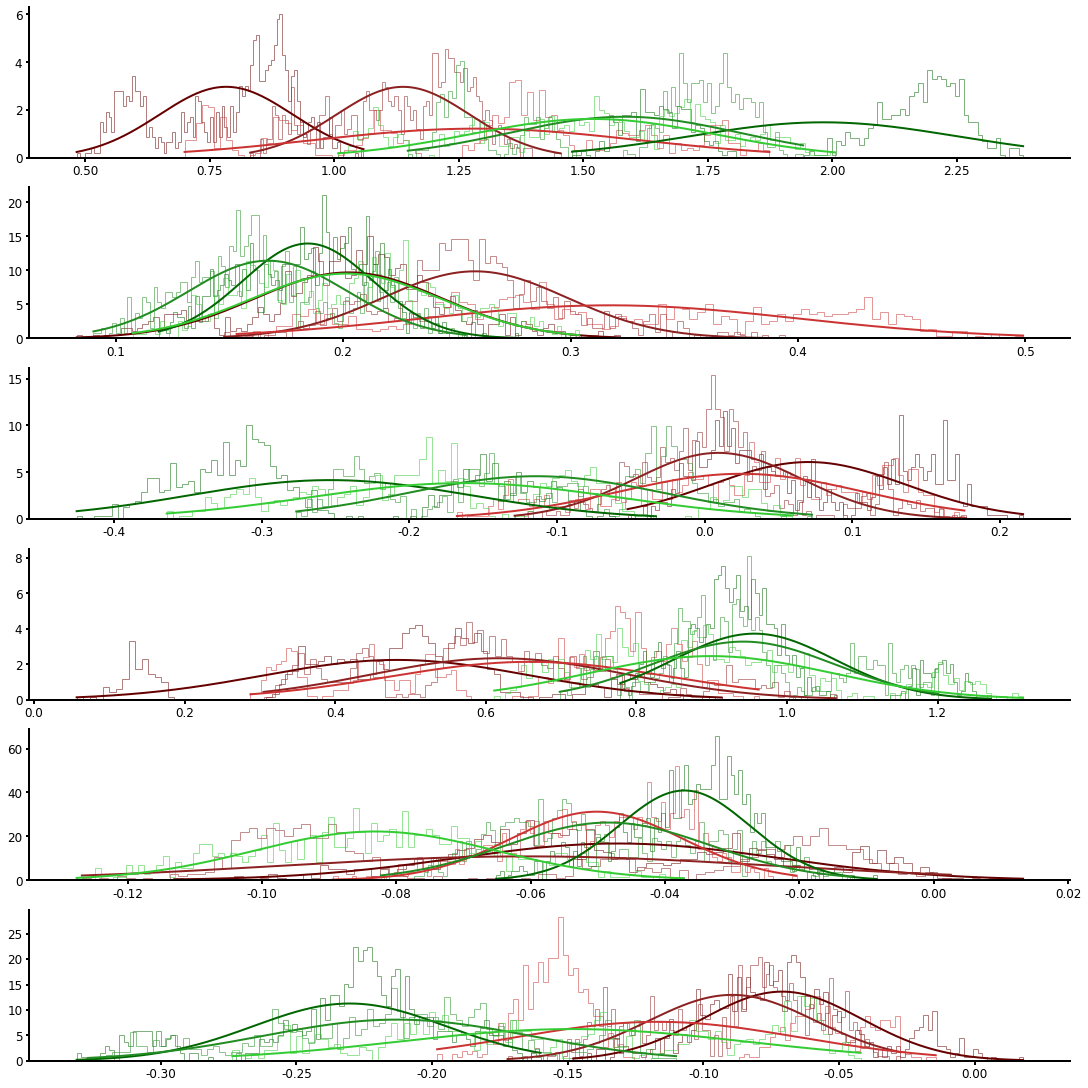

In [ ]:
# same but pool all experimental conditions, averaging across conditions
fig, axs = plt.subplots(6, 1, figsize=(15, 15))
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R = pickle.load(open("picklejar/main_fitting_results.p", "rb"))
vars = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
resamples = [alpha_fit, alpha_t_fit, alpha_R_fit, gamma_fit, gamma_t_fit, gamma_R_fit]
pooled_resamples = {animal: [] for animal in animalList}
for animal in animalList:
    for var in resamples:
        _temp = np.concatenate([list(list(var[animal].values())[i]) for i in range(len(var[animal].values()))])
        pooled_resamples[animal].append(_temp)

from scipy.stats import norm
for animal in animalList:

    for i, (var, resample, ylabel, ylim) in enumerate(zip(vars, resamples, ylabels, ylims)):

        min , max = np.min(pooled_resamples[animal][i]), np.max(pooled_resamples[animal][i])
        bins = np.linspace(min, max, 100)
        axs[i].hist(pooled_resamples[animal][i], bins=bins, 
                histtype='step', color=rat_markers[animal][0], alpha=.5, density=True)

        x = np.linspace(min, max, 1000)
        k2, p = stats.normaltest(pooled_resamples[animal][i])
        _pdf = norm.pdf(x, np.mean(pooled_resamples[animal][i]), np.std(pooled_resamples[animal][i]))
        # print(f"{animal} {cond} {ylabel} {np.mean(resample[animal][cond]):.2f} {np.std(resample[animal][cond]):.2f} {k2:.2f} {p:.2f}")
        axs[i].plot(x, _pdf, color=rat_markers[animal][0], linewidth=2)

In [ ]:
# compute 100 resamples, pooling all experimental conditions
ITER = 100

alphaPool, alpha_tPool, alpha_RPool, gammaPool, gamma_tPool, gamma_RPool = pickle.load(open("picklejar/main_fitting_results_pooled.p", "rb"))

if os.path.exists("picklejar/resamplingParameters100ITER_Pooled.p"):
    alpha_fitPooled, alpha_t_fitPooled, alpha_R_fitPooled, gamma_fitPooled, gamma_t_fitPooled, gamma_R_fitPooled = pickle.load(open("picklejar/resamplingParameters100ITER_Pooled.p", "rb"))
else:    
    alpha_fitPooled, alpha_t_fitPooled, alpha_R_fitPooled, gamma_fitPooled, gamma_t_fitPooled, gamma_R_fitPooled = {}, {}, {}, {}, {}, {}
    alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
    
    for idx, animal in enumerate(animalList):
            _alphaPooled, _gammaPooled, _alpha_tPooled, _gamma_tPooled, _alpha_RPooled, _gamma_RPooled = alphaPool[animal], gammaPool[animal], alpha_tPool[animal], gamma_tPool[animal], alpha_RPool[animal], gamma_RPool[animal]

            N_bins = 6
            N_avg = 4
            ALPHA = np.zeros((N_bins, N_avg))
            GAMMA = np.zeros((N_bins, N_avg))
            sample = np.zeros((N_bins, N_avg)).tolist()
            N_OBS = np.zeros((N_bins, N_avg))

            for bin in range(0, N_bins):
                for avg in range(0, N_avg):
                    N_OBS[bin][avg] = len(dataAll[animal][bin][avg])

            for bin in range(0, N_bins):
                for avg in range(0, N_avg):
                    ALPHA[bin, avg] = _alphaPooled + bin*_alpha_tPooled + avg*_alpha_RPooled
                    GAMMA[bin, avg] = _gammaPooled + bin*_gamma_tPooled + avg*_gamma_RPooled

            iters = ITER
            alpha_fitPooled[animal] = np.zeros((iters))
            gamma_fitPooled[animal] = np.zeros((iters))
            alpha_t_fitPooled[animal] = np.zeros((iters))
            gamma_t_fitPooled[animal] = np.zeros((iters))
            alpha_R_fitPooled[animal] = np.zeros((iters))
            gamma_R_fitPooled[animal] = np.zeros((iters))

            for iter in range(0, iters):
                simple_progress_bar(iter, iters, animal, '', bar_length=20)
                for bin in range(0, N_bins):
                    for avg in range(0, N_avg):
                        sample[bin][avg] = np.asarray(genWaldSamples(N_OBS[bin, avg], ALPHA[bin, avg], GAMMA[bin, avg]))


                (alpha_fitPooled[animal][iter], theta_fit, gamma_fitPooled[animal][iter], \
                    alpha_t_fitPooled[animal][iter], theta_prime_fit, gamma_t_fitPooled[animal][iter], \
                        alpha_R_fitPooled[animal][iter], theta_second_fit, gamma_R_fitPooled[animal][iter]), loss = modelwald_fit(sample,
                                                                                                    alpha_t_fixed=alpha_t_fixed,
                                                                                                    gamma_t_fixed=gamma_t_fixed,
                                                                                                    alpha_R_fixed=alpha_R_fixed,
                                                                                                    gamma_R_fixed=gamma_R_fixed)
    pickle.dump([alpha_fitPooled, alpha_t_fitPooled, alpha_R_fitPooled, gamma_fitPooled, gamma_t_fitPooled, gamma_R_fitPooled], open("picklejar/resamplingParameters100ITER_Pooled.p", "wb"))


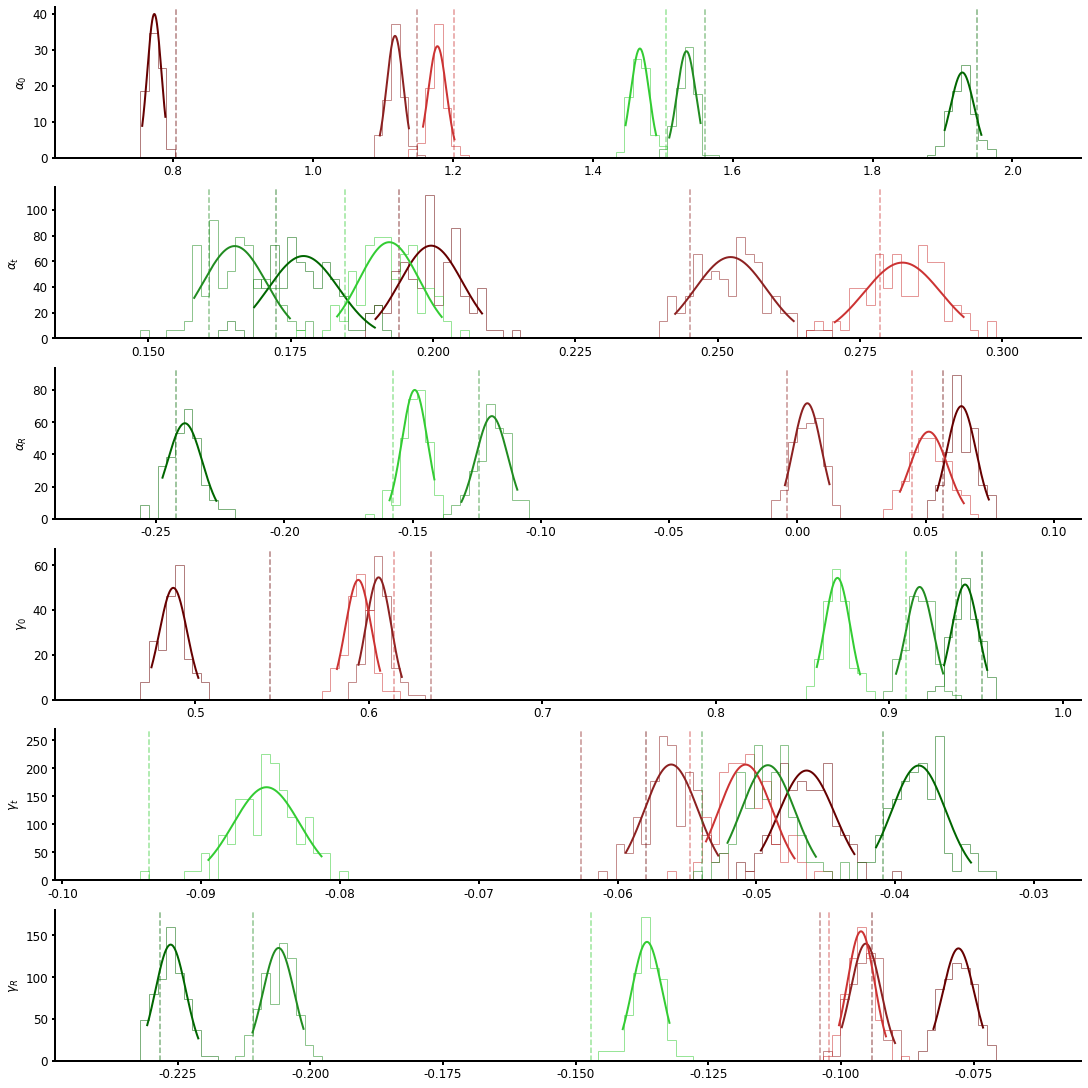

In [ ]:
# plot pooled distributions
fig, axs = plt.subplots(6, 1, figsize=(15, 15))
alphaPool, alpha_tPool, alpha_RPool, gammaPool, gamma_tPool, gamma_RPool = pickle.load(open("picklejar/main_fitting_results_pooled.p", "rb"))
vars = [alphaPool, alpha_tPool, alpha_RPool, gammaPool, gamma_tPool, gamma_RPool]
resamplesPooled = [alpha_fitPooled, alpha_t_fitPooled, alpha_R_fitPooled, gamma_fitPooled, gamma_t_fitPooled, gamma_R_fitPooled]

from scipy.stats import norm
for animal in animalList:
    for i, (var, resample, ylabel, ylim) in enumerate(zip(vars, resamplesPooled, ylabels, ylims)):
        axs[i].axvline(var[animal], color=rat_markers[animal][0], ls="--", alpha=.5)

        s = sorted(resample[animal])
        _s = [resample[animal] for animal in animalList]
        minbin , maxbin = np.min(_s), np.max(_s)
        min, max = s[int(.05*ITER)], s[int(.95*ITER)]
        bins = np.linspace(minbin, maxbin, 100)
        
        axs[i].hist(resample[animal], bins=bins, 
                histtype='step', color=rat_markers[animal][0], alpha=.5, density=True)
        x = np.linspace(min, max, 1000)
        k2, p = stats.normaltest(resample[animal])
        _pdf = norm.pdf(x, np.mean(resample[animal]), np.std(resample[animal]))
        # print(f"{animal} {cond} {ylabel} {np.mean(resample[animal][cond]):.2f} {np.std(resample[animal][cond]):.2f} {k2:.2f} {p:.2f}")
        axs[i].plot(x, _pdf, color=rat_markers[animal][0], linewidth=2)
        axs[i].set_ylabel(ylabel)
        offset = (maxbin - minbin) * .1
        axs[i].set_xlim(minbin-offset, maxbin+offset)

# Model hyperparameters
We search the optimal hyperparameters for our model:  
- memory size,  
- number of time bins,  
- parameter ablation,  
- data pooling, etc.  

We use the BIC to compare two models with different memory sizes and time bins (i.e. not the same number of cells).

---> This causes a problem when comparing two models with different memory sizes/time bins (bc. not same n of curves). Using BIC when comparing two different models.  

## 1) Memory size
How many items does the rat keep in memory?  
Compute the total loss of the model using data from all conditions for different memory sizes, find the memory size that minimizes the loss.  
--> 4 --> 3 !!!

2.8383838383838382


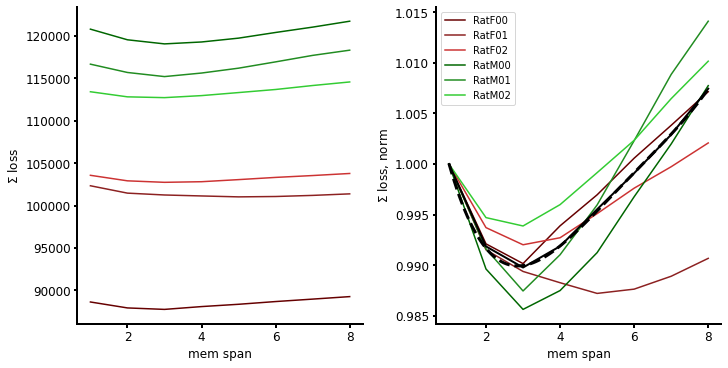

In [ ]:
memsizes = np.arange(1, 9)

losses = {k:np.zeros(len(memsizes)) for k in animalList}
sessions = dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20

if os.path.exists("picklejar/lossesMemSize.p"):
    losses = pickle.load(open("picklejar/lossesMemSize.p", "rb"))
else:
    for idx, memsize in enumerate(memsizes):
        data_all = prepare_data(sequence, animalList, sessions, memsize=memsize, time_bins=6)
        for animal in animalList:
            p, losses[animal][idx] = modelwald_fit(data_all[animal], f=model_compare, N_bins=6, N_avg=len(meankeys(generate_targetList(seq_len=memsize)[::-1])))


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
avglosses = np.zeros((len(animalList), len(memsizes)))
for idx, animal in enumerate(animalList):
    axs[0].plot(memsizes, losses[animal], color=rat_markers[animal][0])
    axs[1].plot(memsizes, (losses[animal])/(losses[animal][0]), color=rat_markers[animal][0], label=animal)
    avglosses[idx] = losses[animal]/losses[animal][0]

f = np.mean(avglosses[:3], axis=0)
m = np.mean(avglosses[3:], axis=0)
avglosses = np.median(avglosses, axis=0)

axs[1].plot(memsizes, avglosses, color='k', lw=2)
z = np.poly1d(np.polyfit(memsizes, avglosses, 4))
x=np.linspace(1, 8, 100)
axs[1].plot(x, z(x), color='k', lw=3, ls='--')
print(x[np.argmin(z(x))])
# axs[0].plot(memsizes, f/3, color='r', lw=2, ls='--')
# axs[0].plot(memsizes, m/3, color='g', lw=2, ls='--')
# axs[1].plot(memsizes, f, color='r', lw=2, ls='--')
# axs[1].plot(memsizes, m, color='g', lw=2, ls='--')

axs[0].set_xlabel('mem span')
axs[1].set_xlabel('mem span')
axs[0].set_ylabel(r'$\Sigma$ loss')
axs[1].set_ylabel(r'$\Sigma$ loss, norm')
axs[1].legend()

# pickle.dump(losses, open("picklejar/lossesMemSize.p", "wb"))

## 2) Time bins
In how many time bins should we cut the data?  
Trade off between resolution (more bins is better), having data from all average reward obtained (less bins is better).  
--> 6

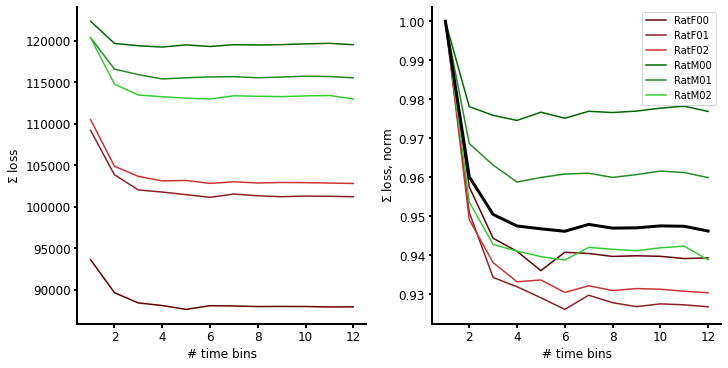

In [ ]:
memsize = 4
time_bins = [3, 6]
time_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

losses = {k:np.zeros(len(time_bins)) for k in animalList}
sessions = dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20

if os.path.exists("picklejar/lossesTimeBins.p"):
    losses = pickle.load(open("picklejar/lossesTimeBins.p", "rb"))
else:
    for idx, bins in enumerate(time_bins):
        data_all = prepare_data(sequence, animalList, sessions, memsize=memsize, time_bins=bins)
        for animal in animalList:
            p, losses[animal][idx] = modelwald_fit(data_all[animal], f=model_compare, N_bins=bins, N_avg=len(meankeys(generate_targetList(seq_len=memsize)[::-1])))


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
avglosses = np.zeros(len(time_bins))
for idx, animal in enumerate(animalList):
    axs[0].plot(time_bins, losses[animal], color=rat_markers[animal][0])
    axs[1].plot(time_bins, (losses[animal])/(losses[animal][0]), color=rat_markers[animal][0], label=animal)
    avglosses += losses[animal]

axs[1].plot(time_bins, avglosses/avglosses[0], color='k', lw=3)

axs[0].set_xlabel('# time bins')
axs[1].set_xlabel('# time bins')
axs[0].set_ylabel(r'$\Sigma$ loss')
axs[1].set_ylabel(r'$\Sigma$ loss, norm')
axs[1].legend()

# pickle.dump(losses, open("picklejar/lossesTimeBins.p", "wb"))

## 3) Parameter ablation
To evaluate the contribution of the different model parameters we performed parameter ablation of the model. The overall model loss was computed and compared.  
The loss of the model with all the parameters free (++++) is smaller than the model with all parameters ablated (----).  
Single-parameter ablation to see the contribution of parameters. $\alpha''$ does not seem to be important.  
Multiple parameter ablation increases the loss.  
maybe diff M/F  
Do that with synthetic data?

all vs ++++: (1 sample t-tests)
1 vs. (False, False, False, False): nan 
1 vs. (False, False, True, False): 0.145 
1 vs. (False, True, False, False): 0.011 *
1 vs. (True, False, False, False): 0.004 *
1 vs. (False, False, False, True): 0.001 *
1 vs. (True, True, True, True): 0.000 *

comparisons: (2 sample t-tests)
(False, False, True, False) vs (False, True, False, False): 0.138 
(False, False, True, False) vs (True, False, False, False): 0.013 *
(False, False, True, False) vs (False, False, False, True): 0.000 *
(False, False, True, False) vs (True, True, True, True): 0.000 *
(False, True, False, False) vs (True, False, False, False): 0.142 
(False, True, False, False) vs (False, False, False, True): 0.001 *
(False, True, False, False) vs (True, True, True, True): 0.000 *
(True, False, False, False) vs (False, False, False, True): 0.013 *
(True, False, False, False) vs (True, True, True, True): 0.000 *
(False, False, False, True) vs (True, True, True, True): 0.000 *


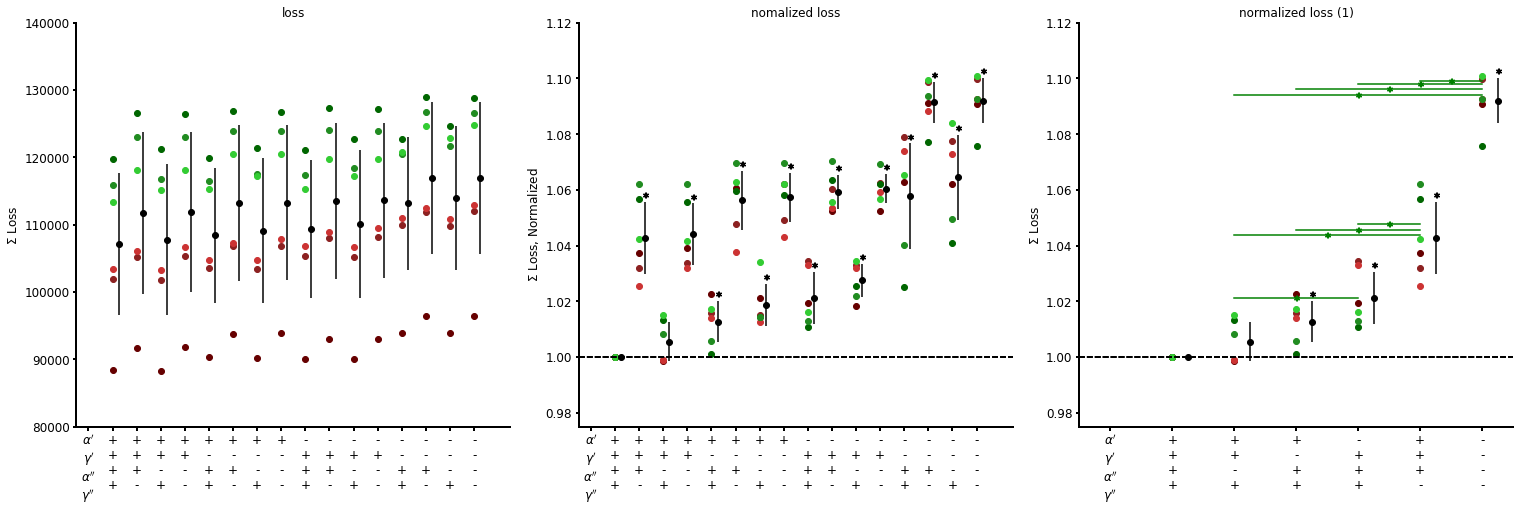

In [ ]:
targetlist = generate_targetList(seq_len=4)[::-1]
fig, axs = plt.subplots(1, 3, figsize=(21, 7))


losses = {}
the_keys_i_want = [(False, False, False, False), 
                    (True, False, False, False), 
                    (False, True, False, False), 
                    (False, False, True, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

the_keys_i_want = [(False, False, False, False), 
                    (False, False, True, False), 
                    (False, True, False, False), 
                    (True, False, False, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

for animal in animalList:
    losses[animal] = {}
    for alpha_t_fixed in [False, True]:
        for gamma_t_fixed in [False, True]:
            for alpha_R_fixed in [False, True]:
                for gamma_R_fixed in [False, True]:
                    number_of_params = 2  # alpha, gamma
                    number_of_extra_params = alpha_t_fixed+gamma_t_fixed+alpha_R_fixed+gamma_R_fixed
                    loss = modelwald_fit(dataAll[animal], 
                                        f=model_compare,
                                        alpha_t_fixed=alpha_t_fixed, 
                                        gamma_t_fixed=gamma_t_fixed, 
                                        alpha_R_fixed=alpha_R_fixed, 
                                        gamma_R_fixed=gamma_R_fixed, 
                                        N_params=number_of_params + (4 - number_of_extra_params),
                                        )[1]

                    # print(f'{animal}: {alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed}, n_params={number_of_params + (4 - number_of_extra_params)}, loss={loss}')

                    losses[animal][(alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed)] = loss

    axs[0].scatter(np.arange(16), losses[animal].values(), color=rat_markers[animal][0], label=animal)
    axs[0].set_title(f"loss")
    axs[0].set_ylabel(r'$\Sigma$ Loss')
    axs[0].set_xticks(np.arange(-1, 16))
    axs[0].set_xticklabels(dict_to_xticklabels(losses[animal]))
    axs[0].set_ylim([45, 70])
    axs[0].set_ylim([80000, 140000])
    axs[0].set_xlim([-1.5, 16.5])

    axs[1].scatter(np.arange(16), list(losses[animal].values())/losses[animal][False, False, False, False], color=rat_markers[animal][0], label=animal)
    axs[1].set_title(f"nomalized loss")
    axs[1].set_ylabel(r'$\Sigma$ Loss, Normalized')
    axs[1].set_xticks(np.arange(-1, 16))
    axs[1].set_xticklabels(dict_to_xticklabels(losses[animal]))
    axs[1].set_ylim([.975, 1.12])
    axs[1].set_xlim([-1.5, 16.5])
    axs[1].axhline(1, color='k', linestyle='--')

    for i, key in enumerate(the_keys_i_want):
        axs[2].scatter(i+1, losses[animal][key]/losses[animal][False, False, False, False], color=rat_markers[animal][0], label=animal)
    axs[2].set_title(f"normalized loss (1)")
    axs[2].set_ylabel(r'$\Sigma$ Loss')
    axs[2].set_xticks(np.arange(7))
    axs[2].set_xticklabels(dict_to_xticklabels({k:losses[animal][k] for k in the_keys_i_want}))
    axs[2].set_ylim([.975, 1.12])
    axs[2].set_xlim([-.5, 6.5])
    axs[2].axhline(1, color='k', linestyle='--')

# average by key
means = [np.mean([losses[animal][key] for animal in animalList]) for key in losses[animal].keys()]
yerr = [np.std([losses[animal][key] for animal in animalList]) for key in losses[animal].keys()]
axs[0].errorbar(np.arange(16)+.25, means, yerr=yerr, color='k', label='Mean', marker='o', fmt=' ')

means_norm = [np.mean([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in losses[animal].keys()]
yerr_norm = [np.std([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in losses[animal].keys()]
axs[1].errorbar(np.arange(16)+.25, means_norm, yerr=yerr_norm, color='k', label='Mean', marker='o', fmt=' ')

means_norm_select = [np.mean([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in the_keys_i_want]
yerr_norm_select = [np.std([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in the_keys_i_want]
axs[2].errorbar(np.arange(len(the_keys_i_want))+1.25, means_norm_select, yerr=yerr_norm_select, color='k', label='Mean', marker='o', fmt=' ')


for idx, key in enumerate(losses[animal].keys()):
    data = [losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]
    s, p = stats.ttest_1samp(data, 1)
    if p < .05: axs[1].scatter(idx+.25, np.mean(data) + np.std(data) + 0.0025, color='k', marker=r'$\ast$')

print("all vs ++++: (1 sample t-tests)")
for idx, key in enumerate(the_keys_i_want):
    data = [losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]
    s, p = stats.ttest_1samp(data, 1)
    if p < .05: axs[2].scatter(idx+1.25, np.mean(data) + np.std(data) + 0.0025, color='k', marker=r'$\ast$')
    print(f"1 vs. {key}: {p:.3f} {'*' if p < .05 else ''}")
print()
print("comparisons: (2 sample t-tests)")
test_all_keys_between_themselves(losses, the_keys_i_want[1:], axs[2])



## 5) data not pooled
What happens when we don't pool the data -> increase in variability due to lack of data.  
some sessions with no data at the end of session/when R low, underestimate $\alpha'$, $\gamma'$, $\alpha''$ and $\gamma''$

### a) session by session

In [ ]:
targetlist = generate_targetList(seq_len=4)[::-1]
fig, axs = plt.subplots(6, 2, figsize=(10, 20), constrained_layout=True)


ylabels = [r'$\alpha$', r"$\alpha'$", r"$\alpha''$", r'$\gamma$', r"$\gamma'$", r"$\gamma''$"]
ylims = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]


alpha_session = {}
gamma_session = {}
alpha_t_session = {}
gamma_t_session = {}
alpha_R_session = {}
gamma_R_session = {}
lossWald_session = {}


alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, True, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = True, True, True, True

for idx, animal in enumerate(animalList):

    alpha_session[animal] = {}
    gamma_session[animal] = {}
    alpha_t_session[animal] = {}
    gamma_t_session[animal] = {}
    alpha_R_session[animal] = {}
    gamma_R_session[animal] = {}
    lossWald_session[animal] = {}

    for cond, data, sessionlist in zip([60, 90, 120, 20, 10, 2, -10, -20], 
                                        [data60_bysession, data90_bysession, data120_bysession, data20_bysession, 
                                            data10_bysession, data2_bysession, datarev10_bysession, datarev20_bysession], 
                                        [dist60, dist90, dist120, TM20, TM10, TM2+TMrev2, TMrev10, TMrev20]):

        for session in matchsession(animal, sessionlist):
            alpha_session[animal][session] = 0
            gamma_session[animal][session] = 0
            alpha_t_session[animal][session] = 0
            gamma_t_session[animal][session] = 0
            alpha_R_session[animal][session] = 0
            gamma_R_session[animal][session] = 0
            lossWald_session[animal][session] = 0

            (alpha_session[animal][session], theta_session, gamma_session[animal][session], \
            alpha_t_session[animal][session], thetaprime_session, gamma_t_session[animal][session], \
            alpha_R_session[animal][session], thetasecond_session, gamma_R_session[animal][session]), lossWald_session[animal][session] = modelwald_fit(data[animal][session], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                                                gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                                                alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                                                gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                                                )
    
            vars = [alpha_session, alpha_t_session, alpha_R_session, gamma_session, gamma_t_session, gamma_R_session]
            if cond in [60, 90, 120]:
                for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
                    # axs[i, 0].scatter(np.arange(3), [var[animal][session]["60"], var[animal][session]["90"], var[animal][session]["120"]], color=rat_markers[animal][0], label=animal)
                    axs[i, 0].scatter(cond + 3*idx, var[animal][session], color=rat_markers[animal][0], label=animal)
                    axs[i, 0].set_title(f"")
                    axs[i, 0].set_xticks([60, 90, 120])
                    axs[i, 0].set_xticklabels(["60", "90", "120"])
                    axs[i, 0].set_xlabel("Distance", fontsize=14)
                    axs[i, 0].set_ylabel(ylabel, fontsize=14)
                    axs[i, 0].set_xlim(40, 140)
                    axs[i, 0].set_ylim(ylim)
                    axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)
            else:
                for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
                    # axs[i, 1].scatter(np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], color=rat_markers[animal][0], label=animal)
                    axs[i, 1].scatter(cond + idx, var[animal][session], color=rat_markers[animal][0], label=animal)
                    axs[i, 1].set_title(f"")
                    axs[i, 1].set_xticks([20, 10, 0, -10, -20])
                    axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
                    axs[i, 1].set_xlabel(r'$v_{belt}$', fontsize=14)
                    axs[i, 1].set_ylabel(ylabel, fontsize=14)
                    axs[i, 1].set_xlim(-30, 30)
                    axs[i, 1].set_ylim(ylim)
                    axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)

### b) Generating avg number of waiting times per session
100 sampling+fitting iterations  
pickle results because ~1s/(gen+fit) -> ~1h

In [ ]:
ITER = 1  # 100

In [ ]:
alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R = pickle.load(open("picklejar/main_fitting_results.p", "rb"))


alpha_fit = {}
gamma_fit = {}
alpha_t_fit = {}
gamma_t_fit = {}
alpha_R_fit = {}
gamma_R_fit = {}


for idx, animal in enumerate(animalList):
    alpha_fit[animal] = {}
    gamma_fit[animal] = {}
    alpha_t_fit[animal] = {}
    gamma_t_fit[animal] = {}
    alpha_R_fit[animal] = {}
    gamma_R_fit[animal] = {}

    for cond, sessions, data in zip(
                                        ["60", "90", "120", "20", "10", "2", "rev10", "rev20"], 
                                        [matchsession(animal, dist60), matchsession(animal, dist90), matchsession(animal, dist120), 
                                            matchsession(animal, TM20), matchsession(animal, TM10), matchsession(animal, TM2), matchsession(animal, TMrev10), matchsession(animal, TMrev20)],
                                        [data60_bysession, data90_bysession, data120_bysession, data20_bysession, data10_bysession, data2_bysession, datarev10_bysession, datarev20_bysession]):

        _alpha, _gamma, _alpha_t, _gamma_t, _alpha_R, _gamma_R = alpha[animal][cond], gamma[animal][cond], alpha_t[animal][cond], gamma_t[animal][cond], alpha_R[animal][cond], gamma_R[animal][cond]

        N_bins=6
        N_avg=4
        ALPHA = np.zeros((N_bins, N_avg))
        GAMMA = np.zeros((N_bins, N_avg))
        sample = np.zeros((N_bins, N_avg)).tolist()
        N_OBS = np.zeros((N_bins, N_avg))

        for session in sessions:
            for bin in range(0, N_bins):
                for avg in range(0, N_avg):
                    N_OBS[bin][avg] += len(data[animal][session][bin][avg])
                    
        ####################################################
        N_OBS /= len(sessions)
        ####################################################

        for bin in range(0, N_bins):
            for avg in range(0, N_avg):
                ALPHA[bin, avg] = _alpha + bin*_alpha_t + avg*_alpha_R
                GAMMA[bin, avg] = _gamma + bin*_gamma_t + avg*_gamma_R

        iters = ITER
        alpha_fit[animal][cond] = np.zeros((iters))
        gamma_fit[animal][cond] = np.zeros((iters))
        alpha_t_fit[animal][cond] = np.zeros((iters))
        gamma_t_fit[animal][cond] = np.zeros((iters))
        alpha_R_fit[animal][cond] = np.zeros((iters))
        gamma_R_fit[animal][cond] = np.zeros((iters))

        for iter in range(0, iters):
            simple_progress_bar(iter, iters, animal, cond, bar_length=20)
            for bin in range(0, N_bins):
                for avg in range(0, N_avg):
                    sample[bin][avg] = np.asarray(genWaldSamples(N_OBS[bin, avg], ALPHA[bin, avg], GAMMA[bin, avg]))

            (alpha_fit[animal][cond][iter], theta_fit, gamma_fit[animal][cond][iter], \
                alpha_t_fit[animal][cond][iter], theta_prime_fit, gamma_t_fit[animal][cond][iter], \
                    alpha_R_fit[animal][cond][iter], theta_second_fit, gamma_R_fit[animal][cond][iter]), loss = modelwald_fit(sample, 
                                                                                                alpha_t_fixed=alpha_t_fixed, 
                                                                                                gamma_t_fixed=gamma_t_fixed, 
                                                                                                alpha_R_fixed=alpha_R_fixed, 
                                                                                                gamma_R_fixed=gamma_R_fixed)

In [ ]:
# # pickle
# pickle.dump(alpha_fit, open("picklejar/alpha_fit100_sessionBIC.p", "wb"))
# pickle.dump(gamma_fit, open("picklejar/gamma_fit100_sessionBIC.p", "wb"))
# pickle.dump(alpha_t_fit, open("picklejar/alpha_t_fit100_sessionBIC.p", "wb"))
# pickle.dump(gamma_t_fit, open("picklejar/gamma_t_fit100_sessionBIC.p", "wb"))
# pickle.dump(alpha_R_fit, open("picklejar/alpha_R_fit100_sessionBIC.p", "wb"))
# pickle.dump(gamma_R_fit, open("picklejar/gamma_R_fit100_sessionBIC.p", "wb"))

# load 
# alpha_fit = pickle.load(open("picklejar/alpha_fit100_sessionBIC.p", "rb"))
# gamma_fit = pickle.load(open("picklejar/gamma_fit100_sessionBIC.p", "rb"))
# alpha_t_fit = pickle.load(open("picklejar/alpha_t_fit100_sessionBIC.p", "rb"))
# gamma_t_fit = pickle.load(open("picklejar/gamma_t_fit100_sessionBIC.p", "rb"))
# alpha_R_fit = pickle.load(open("picklejar/alpha_R_fit100_sessionBIC.p", "rb"))
# gamma_R_fit = pickle.load(open("picklejar/gamma_R_fit100_sessionBIC.p", "rb"))


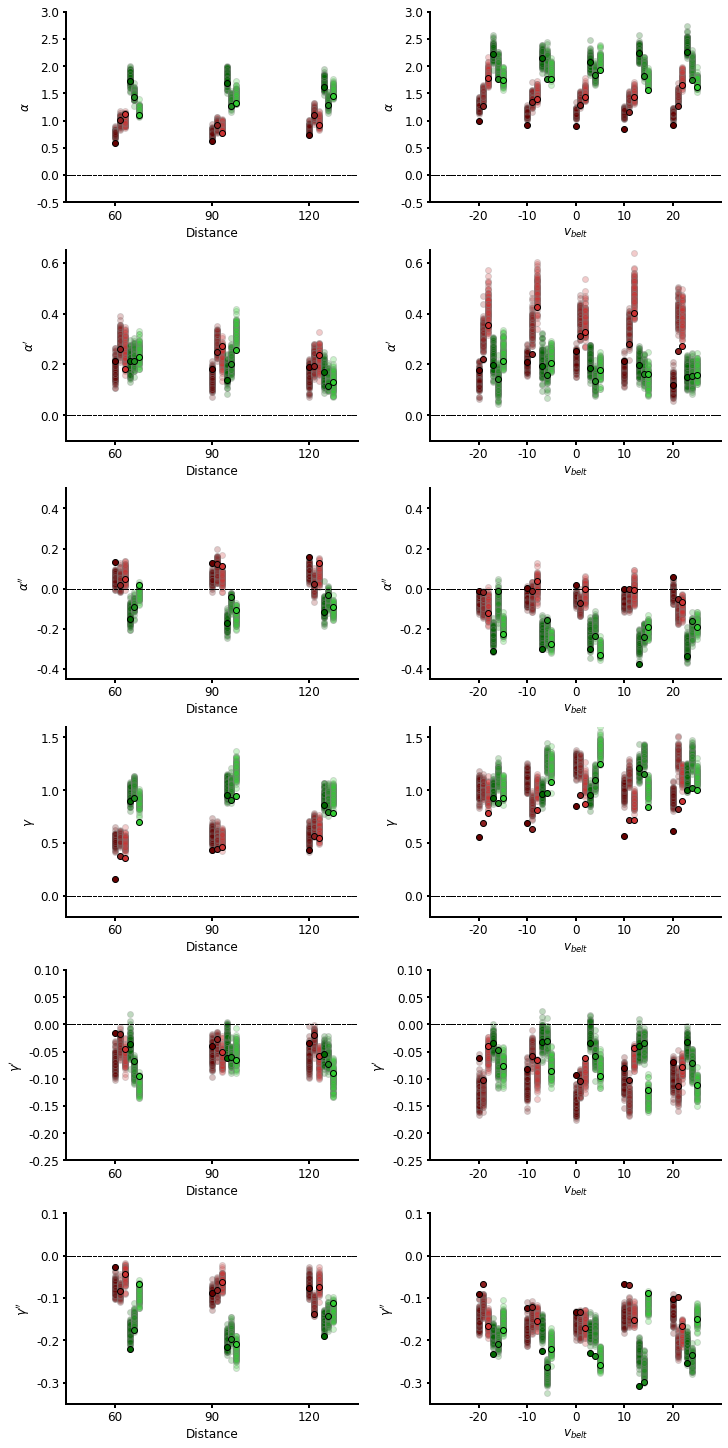

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
iters=100
for idx, animal in enumerate(animalList):
    for x, cond in zip([0, 2, 4, 4, 3, 2, 1, 0], ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]):

        _alpha, _gamma, _alpha_t, _gamma_t, _alpha_R, _gamma_R = alpha[animal][cond], gamma[animal][cond], alpha_t[animal][cond], gamma_t[animal][cond], alpha_R[animal][cond], gamma_R[animal][cond]
        truths = [_alpha, _alpha_t, _alpha_R, _gamma, _gamma_t, _gamma_R]

        ylims = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]
        vars = [alpha_fit[animal][cond], alpha_t_fit[animal][cond], alpha_R_fit[animal][cond], gamma_fit[animal][cond], gamma_t_fit[animal][cond], gamma_R_fit[animal][cond]]
        if cond in ["60", "90", "120"]:

            for i, (var, ylabel, ylim, true) in enumerate(zip(vars, ylabels, ylims, truths)):
                # violinplot
                # violin_parts = axs[i, 0].violinplot(var, positions=[x + (idx/10)])#, showmeans=True, showextrema=True, showmedians=False)

                # for vp in violin_parts['bodies']:
                #     # vp.set_facecolor(rat_markers[animal][0])
                #     # vp.set_edgecolor(rat_markers[animal][0])
                #     vp.set_facecolor('gray')
                #     vp.set_edgecolor('gray')
                #     vp.set_linewidth(1)
                #     vp.set_alpha(0.5)

                # for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
                #     try:
                #         vp = violin_parts[partname]
                #         # vp.set_edgecolor(rat_markers[animal][0])
                #         vp.set_edgecolor('gray')
                #         vp.set_linewidth(1)
                #     except: pass

                # scatter
                axs[i, 0].scatter([x + np.random.normal(0, .0)+(idx/10) for i in range(iters)], var, color=rat_markers[animal][0], alpha=.25, linewidth=1, edgecolors='gray')
                axs[i, 0].scatter([x + (idx/10)], true, color=rat_markers[animal][0], alpha=1, linewidth=1, edgecolors='k', zorder=10)

                axs[i, 0].set_title(f"")
                axs[i, 0].set_xticks([0, 2, 4])
                axs[i, 0].set_xticklabels(["60", "90", "120"])
                axs[i, 0].set_xlabel("Distance")
                axs[i, 0].set_ylabel(ylabel)
                axs[i, 0].set_xlim(-1, 5)
                axs[i, 0].set_ylim(ylim)
                axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

        else:
            for i, (var, ylabel, ylim, true) in enumerate(zip(vars, ylabels, ylims, truths)):
                # violin plot
                # violin_parts = axs[i, 1].violinplot(var, positions=[x + idx/10])#, showmeans=False, showextrema=True, showmedians=True) 

                # for vp in violin_parts['bodies']:
                #     # vp.set_facecolor(rat_markers[animal][0])
                #     # vp.set_edgecolor(rat_markers[animal][0])
                #     vp.set_facecolor('gray')
                #     vp.set_edgecolor('gray')
                #     vp.set_linewidth(1)
                #     vp.set_alpha(0.5)

                # for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
                #     try:
                #         vp = violin_parts[partname]
                #         # vp.set_edgecolor(rat_markers[animal][0])
                #         vp.set_edgecolor('gray')
                #         vp.set_linewidth(1)
                #     except: pass

                # scatter
                axs[i, 1].scatter([x + np.random.normal(0, .0)+idx/10 for i in range(iters)], var, color=rat_markers[animal][0], alpha=.25, linewidth=1, edgecolors='gray')
                axs[i, 1].scatter([x + idx/10], true, color=rat_markers[animal][0], alpha=1, linewidth=1, edgecolors='k', zorder=10)

                axs[i, 1].set_title(f"")
                axs[i, 1].set_xticks([4, 3, 2, 1, 0])
                axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
                axs[i, 1].set_xlabel(r'$v_{belt}$')
                axs[i, 1].set_ylabel(ylabel)
                axs[i, 1].set_xlim(-1, 5)
                axs[i, 1].set_ylim(ylim)
                axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)

### c) Generating total number of waiting times
This has been moved above in interindividual variability

In [ ]:
alpha_fit = {}
gamma_fit = {}
alpha_t_fit = {}
gamma_t_fit = {}
alpha_R_fit = {}
gamma_R_fit = {}


for idx, animal in enumerate(animalList):
    alpha_fit[animal] = {}
    gamma_fit[animal] = {}
    alpha_t_fit[animal] = {}
    gamma_t_fit[animal] = {}
    alpha_R_fit[animal] = {}
    gamma_R_fit[animal] = {}

    for cond, sessions, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], 
                                    [matchsession(animal, dist60), matchsession(animal, dist90), matchsession(animal, dist120), 
                                        matchsession(animal, TM20), matchsession(animal, TM10), matchsession(animal, TM2), matchsession(animal, TMrev10), matchsession(animal, TMrev20)],
                                    [data60_bysession, data90_bysession, data120_bysession, data20_bysession, data10_bysession, data2_bysession, datarev10_bysession, datarev20_bysession]):

        _alpha, _gamma, _alpha_t, _gamma_t, _alpha_R, _gamma_R = alpha[animal][cond], gamma[animal][cond], alpha_t[animal][cond], gamma_t[animal][cond], alpha_R[animal][cond], gamma_R[animal][cond]

        N_bins=6
        N_avg=4
        ALPHA = np.zeros((N_bins, N_avg))
        GAMMA = np.zeros((N_bins, N_avg))
        sample = np.zeros((N_bins, N_avg)).tolist()
        N_OBS = np.zeros((N_bins, N_avg))

        for session in sessions:
            for bin in range(0, N_bins):
                for avg in range(0, N_avg):
                    N_OBS[bin][avg] += len(data[animal][session][bin][avg])

        for bin in range(0, N_bins):
            for avg in range(0, N_avg):
                ALPHA[bin, avg] = _alpha + bin*_alpha_t + avg*_alpha_R
                GAMMA[bin, avg] = _gamma + bin*_gamma_t + avg*_gamma_R

        iters = ITER
        alpha_fit[animal][cond] = np.zeros((iters))
        gamma_fit[animal][cond] = np.zeros((iters))
        alpha_t_fit[animal][cond] = np.zeros((iters))
        gamma_t_fit[animal][cond] = np.zeros((iters))
        alpha_R_fit[animal][cond] = np.zeros((iters))
        gamma_R_fit[animal][cond] = np.zeros((iters))

        for iter in range(0, iters):
            simple_progress_bar(iter, iters, animal, cond, bar_length=20)
            for bin in range(0, N_bins):
                for avg in range(0, N_avg):
                    sample[bin][avg] = np.asarray(genWaldSamples(N_OBS[bin, avg], ALPHA[bin, avg], GAMMA[bin, avg]))

            (alpha_fit[animal][cond][iter], theta_fit, gamma_fit[animal][cond][iter], \
                alpha_t_fit[animal][cond][iter], theta_prime_fit, gamma_t_fit[animal][cond][iter], \
                    alpha_R_fit[animal][cond][iter], theta_second_fit, gamma_R_fit[animal][cond][iter]), loss = modelwald_fit(sample, 
                                                                                                alpha_t_fixed=alpha_t_fixed, 
                                                                                                gamma_t_fixed=gamma_t_fixed, 
                                                                                                alpha_R_fixed=alpha_R_fixed, 
                                                                                                gamma_R_fixed=gamma_R_fixed)

In [ ]:
# pickle
# pickle.dump(alpha_fit, open("picklejar/alpha_fit100BIC.p", "wb"))
# pickle.dump(gamma_fit, open("picklejar/gamma_fit100BIC.p", "wb"))
# pickle.dump(alpha_t_fit, open("picklejar/alpha_t_fit100BIC.p", "wb"))
# pickle.dump(gamma_t_fit, open("picklejar/gamma_t_fit100BIC.p", "wb"))
# pickle.dump(alpha_R_fit, open("picklejar/alpha_R_fit100BIC.p", "wb"))
# pickle.dump(gamma_R_fit, open("picklejar/gamma_R_fit100BIC.p", "wb"))

#load 
alpha_fit = pickle.load(open("picklejar/alpha_fit100BIC.p", "rb"))
gamma_fit = pickle.load(open("picklejar/gamma_fit100BIC.p", "rb"))
alpha_t_fit = pickle.load(open("picklejar/alpha_t_fit100BIC.p", "rb"))
gamma_t_fit = pickle.load(open("picklejar/gamma_t_fit100BIC.p", "rb"))
alpha_R_fit = pickle.load(open("picklejar/alpha_R_fit100BIC.p", "rb"))
gamma_R_fit = pickle.load(open("picklejar/gamma_R_fit100BIC.p", "rb"))



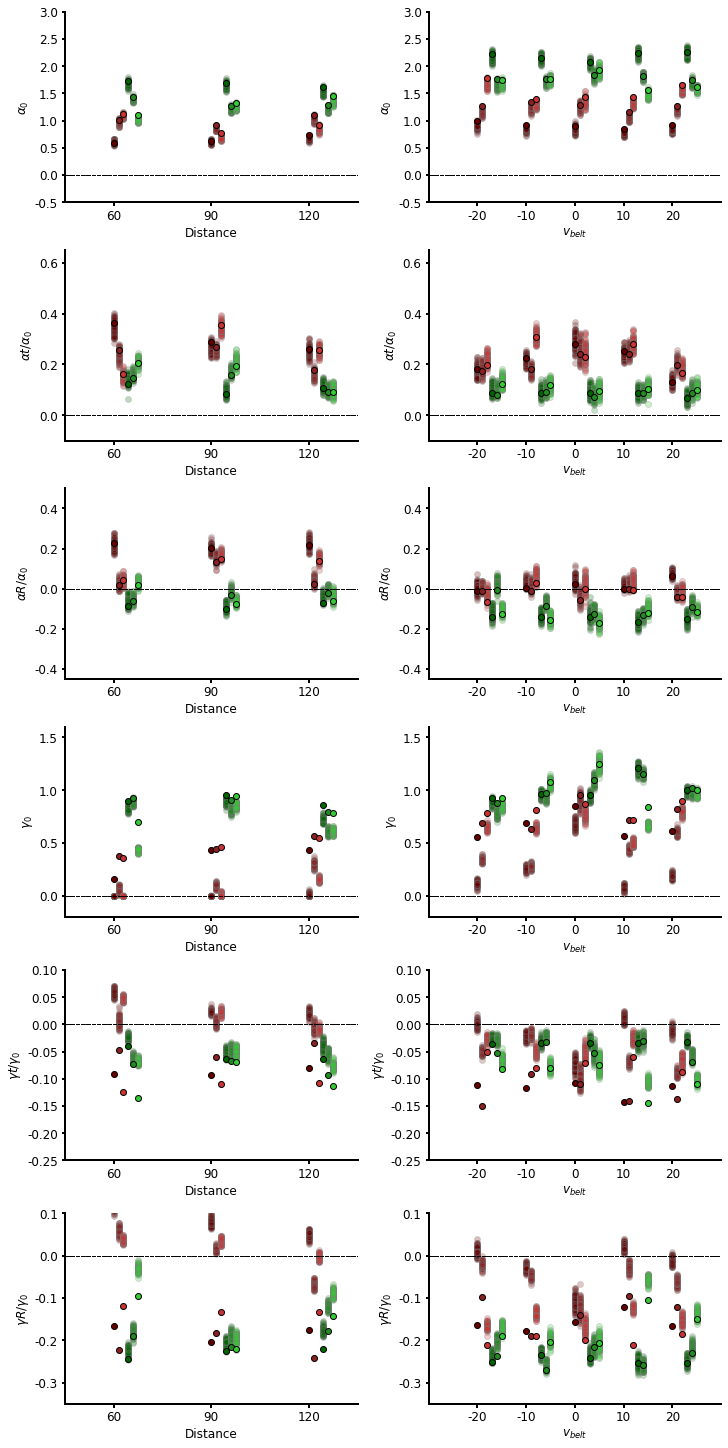

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
iters=100
for idx, animal in enumerate(animalList):
    for x, cond in zip([0, 2, 4, 4, 3, 2, 1, 0], ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]):

        _alpha, _gamma, _alpha_t, _gamma_t, _alpha_R, _gamma_R = alpha[animal][cond], gamma[animal][cond], alpha_t[animal][cond], gamma_t[animal][cond], alpha_R[animal][cond], gamma_R[animal][cond]
        truths = [_alpha, _alpha_t, _alpha_R, _gamma, _gamma_t, _gamma_R]

        ylims = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]
        vars = [alpha_fit[animal][cond], alpha_t_fit[animal][cond], alpha_R_fit[animal][cond], gamma_fit[animal][cond], gamma_t_fit[animal][cond], gamma_R_fit[animal][cond]]
        if cond in ["60", "90", "120"]:

            for i, (var, ylabel, ylim, true) in enumerate(zip(vars, ylabels, ylims, truths)):
                # violinplot
                # violin_parts = axs[i, 0].violinplot(var, positions=[x + (idx/10)])#, showmeans=True, showextrema=True, showmedians=False)

                # for vp in violin_parts['bodies']:
                #     # vp.set_facecolor(rat_markers[animal][0])
                #     # vp.set_edgecolor(rat_markers[animal][0])
                #     vp.set_facecolor('gray')
                #     vp.set_edgecolor('gray')
                #     vp.set_linewidth(1)
                #     vp.set_alpha(0.5)

                # for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
                #     try:
                #         vp = violin_parts[partname]
                #         # vp.set_edgecolor(rat_markers[animal][0])
                #         vp.set_edgecolor('gray')
                #         vp.set_linewidth(1)
                #     except: pass

                # scatter
                axs[i, 0].scatter([x + np.random.normal(0, .0)+(idx/10) for i in range(iters)], var, color=rat_markers[animal][0], alpha=.25, linewidth=1, edgecolors='gray')
                axs[i, 0].scatter([x + (idx/10)], true, color=rat_markers[animal][0], alpha=1, linewidth=1, edgecolors='k', zorder=10)

                axs[i, 0].set_title(f"")
                axs[i, 0].set_xticks([0, 2, 4])
                axs[i, 0].set_xticklabels(["60", "90", "120"])
                axs[i, 0].set_xlabel("Distance")
                axs[i, 0].set_ylabel(ylabel)
                axs[i, 0].set_xlim(-1, 5)
                axs[i, 0].set_ylim(ylim)
                axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

        else:
            for i, (var, ylabel, ylim, true) in enumerate(zip(vars, ylabels, ylims, truths)):
                # violin plot
                # violin_parts = axs[i, 1].violinplot(var, positions=[x + idx/10])#, showmeans=False, showextrema=True, showmedians=True) 

                # for vp in violin_parts['bodies']:
                #     # vp.set_facecolor(rat_markers[animal][0])
                #     # vp.set_edgecolor(rat_markers[animal][0])
                #     vp.set_facecolor('gray')
                #     vp.set_edgecolor('gray')
                #     vp.set_linewidth(1)
                #     vp.set_alpha(0.5)

                # for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
                #     try:
                #         vp = violin_parts[partname]
                #         # vp.set_edgecolor(rat_markers[animal][0])
                #         vp.set_edgecolor('gray')
                #         vp.set_linewidth(1)
                #     except: pass

                # scatter
                axs[i, 1].scatter([x + np.random.normal(0, .0)+idx/10 for i in range(iters)], var, color=rat_markers[animal][0], alpha=.25, linewidth=1, edgecolors='gray')
                axs[i, 1].scatter([x + idx/10], true, color=rat_markers[animal][0], alpha=1, linewidth=1, edgecolors='k', zorder=10)

                axs[i, 1].set_title(f"")
                axs[i, 1].set_xticks([4, 3, 2, 1, 0])
                axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
                axs[i, 1].set_xlabel(r'$v_{belt}$')
                axs[i, 1].set_ylabel(ylabel)
                axs[i, 1].set_xlim(-1, 5)
                axs[i, 1].set_ylim(ylim)
                axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)

### d) pooling AM/PM

#### > AM/PM for all conditions

In [ ]:
def matchsession(animal, sessionlist, AMPM=False):
    list = [session for session in sessionlist if animal == session[0:6]]
    if AMPM:
        list = [session for session in list if int(session[-8:-6]) < 14] if AMPM == "AM" else [session for session in list if int(session[-8:-6]) > 14]
    return (list)
# matchsession('RatF00', sessionlist, "AM")

In [ ]:
# could be merged with prepare_data_by_session

def prepare_dataAMPM(animalList, sessionList, memsize=3, time_bins=6, AMPM=False):
    """prepare data for fitting
    cut the data into time bins and reward bins and AM/PM"""
    bin_size = 3600/time_bins
    targetlist = generate_targetList(memsize)[::-1]
    temp_data = {}
    for bin in range(time_bins):
        temp_data[bin] = {}
        for animal in animalList:
            temp_data[bin][animal] = {k:[] for k in meankeys(targetlist)}
            for session in matchsession(animal, sessionList, AMPM=AMPM):
                temp_data[bin][animal] = combine_dict(temp_data[bin][animal], get_waiting_times(sequence[animal, session], memsize=memsize, filter=[bin*bin_size, (bin+1)*bin_size]))
    
    data = {}
    for animal in animalList:
        data[animal] = np.zeros((time_bins, len(meankeys(targetlist)))).tolist()
        for i, avg in enumerate(meankeys(targetlist)):  # 1 -> 0
            for bin in range(time_bins):
                data[animal][bin][i] = np.asarray(temp_data[bin][animal][avg])
    return data


data60AM, data60PM = prepare_dataAMPM(animalList, dist60, AMPM='AM'), prepare_dataAMPM(animalList, dist60, AMPM='PM')
data90AM, data90PM = prepare_dataAMPM(animalList, dist90, AMPM='AM'), prepare_dataAMPM(animalList, dist90, AMPM='PM')
data120AM, data120PM = prepare_dataAMPM(animalList, dist120, AMPM='AM'), prepare_dataAMPM(animalList, dist120, AMPM='PM')

data20AM, data20PM = prepare_dataAMPM(animalList, TM20, AMPM='AM'), prepare_dataAMPM(animalList, TM20, AMPM='PM')
data10AM, data10PM = prepare_dataAMPM(animalList, TM10, AMPM='AM'), prepare_dataAMPM(animalList, TM10, AMPM='PM')
data2AM, data2PM = prepare_dataAMPM(animalList, TM2+TMrev2, AMPM='AM'), prepare_dataAMPM(animalList, TM2+TMrev2, AMPM='PM')
datarev10AM, datarev10PM = prepare_dataAMPM(animalList, TMrev10, AMPM='AM'), prepare_dataAMPM(animalList, TMrev10, AMPM='PM')
datarev20AM, datarev20PM = prepare_dataAMPM(animalList, TMrev20, AMPM='AM'), prepare_dataAMPM(animalList, TMrev20, AMPM='PM')

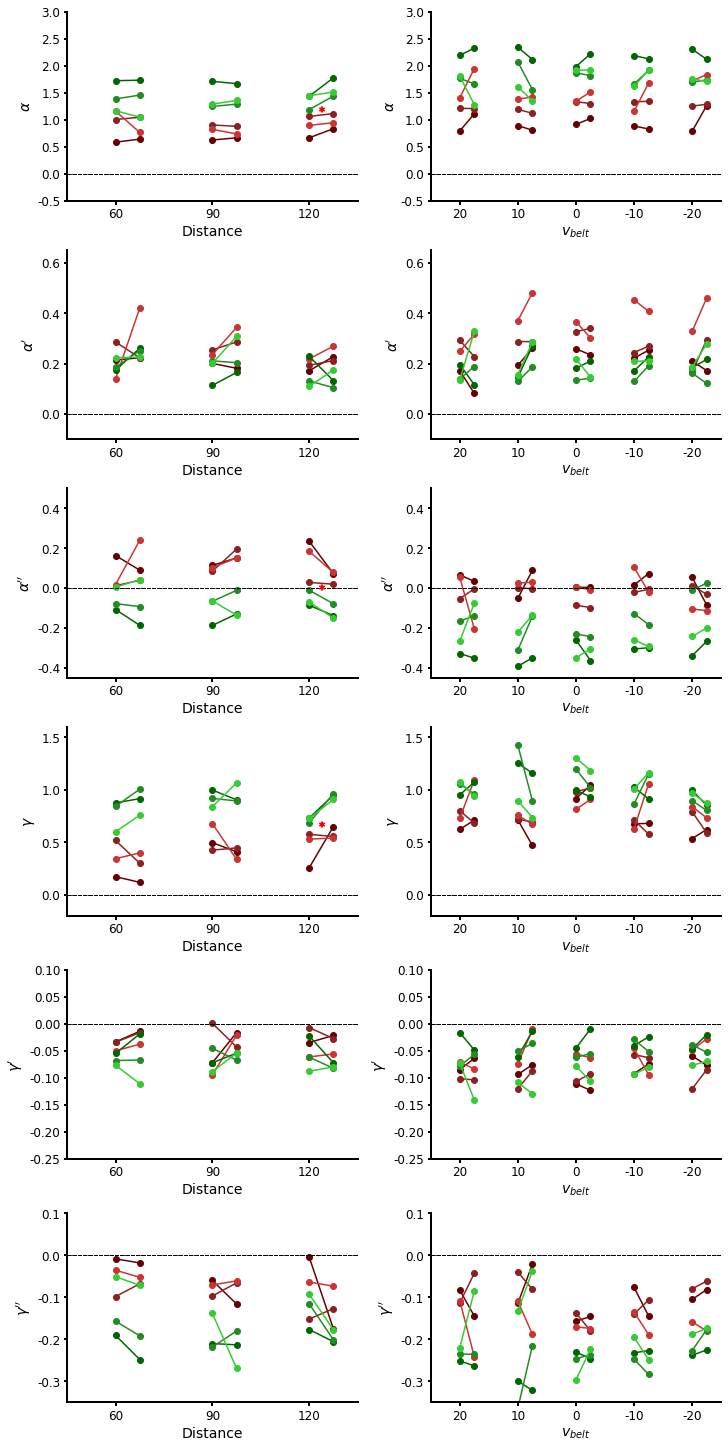

In [ ]:
targetlist = generate_targetList(seq_len=4)[::-1]
fig, axs = plt.subplots(6, 2, figsize=(10, 20), constrained_layout=True)


ylabels = [r'$\alpha$', r"$\alpha'$", r"$\alpha''$", r'$\gamma$', r"$\gamma'$", r"$\gamma''$"]
ylims = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]

alphaAM = {}
gammaAM = {}
alpha_tAM = {}
gamma_tAM = {}
alpha_RAM = {}
gamma_RAM = {}
lossWaldAM = {}

alphaPM = {}
gammaPM = {}
alpha_tPM = {}
gamma_tPM = {}
alpha_RPM = {}
gamma_RPM = {}
lossWaldPM = {}


alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, True, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = True, True, True, True

for animal in animalList:

    alphaAM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gammaAM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_tAM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_tAM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_RAM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_RAM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWaldAM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

    alphaPM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gammaPM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_tPM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_tPM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_RPM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_RPM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWaldPM[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


    # AM ###########################################################
    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60AM, data90AM, data120AM, data20AM, data10AM, data2AM, datarev10AM, datarev20AM]):
        (alphaAM[animal][cond], thetaAM, gammaAM[animal][cond], \
        alpha_tAM[animal][cond], thetaprimeAM, gamma_tAM[animal][cond], \
        alpha_RAM[animal][cond], thetasecondAM, gamma_RAM[animal][cond]), lossWaldAM[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                    gamma_R_fixed=gamma_R_fixed)
    
    # PM ###########################################################
    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60PM, data90PM, data120PM, data20PM, data10PM, data2PM, datarev10PM, datarev20PM]):
        (alphaPM[animal][cond], thetaPM, gammaPM[animal][cond], \
        alpha_tPM[animal][cond], thetaprimePM, gamma_tPM[animal][cond], \
        alpha_RPM[animal][cond], thetasecondPM, gamma_RPM[animal][cond]), lossWaldPM[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed,
                                                                                                                                    gamma_t_fixed=gamma_t_fixed,    
                                                                                                                                    alpha_R_fixed=alpha_R_fixed,
                                                                                                                                    gamma_R_fixed=gamma_R_fixed)

    varsAM = [alphaAM, alpha_tAM, alpha_RAM, gammaAM, gamma_tAM, gamma_RAM]
    varsPM = [alphaPM, alpha_tPM, alpha_RPM, gammaPM, gamma_tPM, gamma_RPM]

    for i, (varAM, varPM, ylabel, ylim) in enumerate(zip(varsAM, varsPM, ylabels, ylims)):
        axs[i, 0].plot([0, .25], [varAM[animal]["60"], varPM[animal]["60"]], color=rat_markers[animal][0], label=animal, marker='o')
        axs[i, 0].plot([1, 1.25], [varAM[animal]["90"], varPM[animal]["90"]], color=rat_markers[animal][0], label=animal, marker='o')
        axs[i, 0].plot([2, 2.25], [varAM[animal]["120"], varPM[animal]["120"]], color=rat_markers[animal][0], label=animal, marker='o')
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_xlabel("Distance", fontsize=14)
        axs[i, 0].set_ylabel(ylabel, fontsize=14)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (varAM, varPM, ylabel, ylim) in enumerate(zip(varsAM, varsPM, ylabels, ylims)):
        axs[i, 1].plot([0, .25], [varAM[animal]["20"], varPM[animal]["20"]], color=rat_markers[animal][0], label=animal, marker='o')
        axs[i, 1].plot([1, 1.25], [varAM[animal]["10"], varPM[animal]["10"]], color=rat_markers[animal][0], label=animal, marker='o')
        axs[i, 1].plot([2, 2.25], [varAM[animal]["2"], varPM[animal]["2"]], color=rat_markers[animal][0], label=animal, marker='o')
        axs[i, 1].plot([3, 3.25], [varAM[animal]["rev10"], varPM[animal]["rev10"]], color=rat_markers[animal][0], label=animal, marker='o')
        axs[i, 1].plot([4, 4.25], [varAM[animal]["rev20"], varPM[animal]["rev20"]], color=rat_markers[animal][0], label=animal, marker='o') 
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_xlabel(r'$v_{belt}$', fontsize=14)
        axs[i, 1].set_ylabel(ylabel, fontsize=14)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)


# # comp ampm
for idx, cond in enumerate(["60", "90", "120"]):
    for jdx, (varAM, varPM) in enumerate(zip(varsAM, varsPM)):
        s, p = stats.ttest_rel([varAM[animal][cond] for animal in animalList], [varPM[animal][cond] for animal in animalList])
        if p < .05: axs[jdx, 0].scatter(idx+.125, (np.mean([varAM[animal][cond] for animal in animalList])+np.mean([varPM[animal][cond] for animal in animalList]))/2, color='r', marker=r'$\ast$', zorder=10)


#### > AM/PM pooling conditions

In [ ]:
# only dist
# dataallAM = prepare_dataAMPM(animalList, dist60+dist90+dist120, AMPM='AM')
# dataallPM = prepare_dataAMPM(animalList, dist60+dist90+dist120, AMPM='PM')

# only TM
# dataallAM = prepare_dataAMPM(animalList, TM20+TM10+TM2+TMrev2+TMrev10+TMrev20, AMPM='AM')
# dataallPM = prepare_dataAMPM(animalList, TM20+TM10+TM2+TMrev2+TMrev10+TMrev20, AMPM='PM')

# all
dataallAM = prepare_dataAMPM(animalList, dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20, AMPM='AM')
dataallPM = prepare_dataAMPM(animalList, dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20, AMPM='PM')

0 0.9004801585034236
1 0.08458565318756357
2 0.33455766323180325
3 0.6886829884745671
4 0.44684562753137913
5 0.6479428900413358


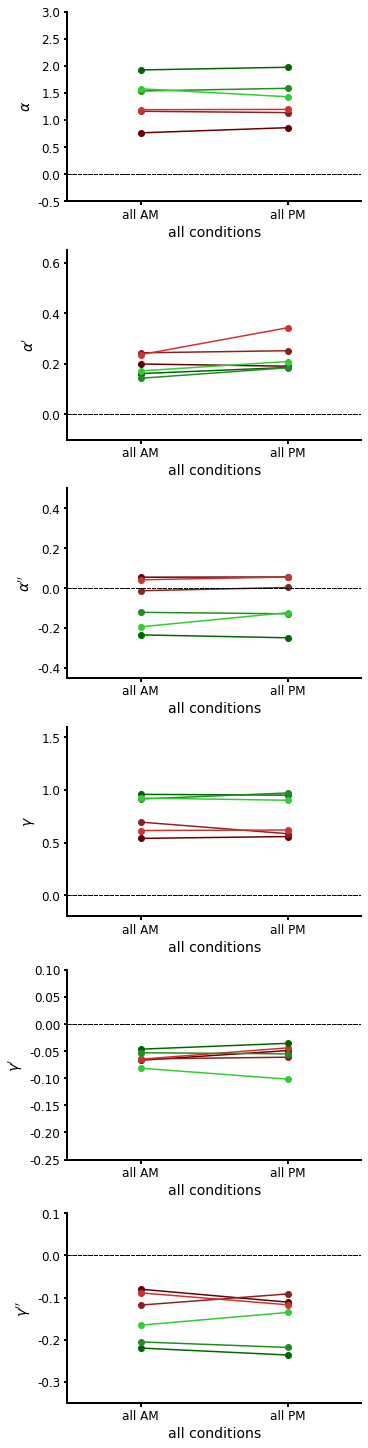

In [ ]:
# same but pool all experimental conditions
targetlist = generate_targetList(seq_len=4)[::-1]
fig, axs = plt.subplots(6, 1, figsize=(5, 20))


ylabels = [r'$\alpha$', r"$\alpha'$", r"$\alpha''$", r'$\gamma$', r"$\gamma'$", r"$\gamma''$"]
ylims = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]

alphaAM = {}
gammaAM = {}
alpha_tAM = {}
gamma_tAM = {}
alpha_RAM = {}
gamma_RAM = {}
lossWaldAM = {}

alphaPM = {}
gammaPM = {}
alpha_tPM = {}
gamma_tPM = {}
alpha_RPM = {}
gamma_RPM = {}
lossWaldPM = {}


alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, True, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = True, True, True, True

for animal in animalList:

    # AM ###########################################################
    (alphaAM[animal], thetaAM, gammaAM[animal], \
    alpha_tAM[animal], thetaprimeAM, gamma_tAM[animal], \
    alpha_RAM[animal], thetasecondAM, gamma_RAM[animal]), lossWaldAM[animal] = modelwald_fit(dataallAM[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                    gamma_R_fixed=gamma_R_fixed)
    # PM ###########################################################                                                                                                                                
    (alphaPM[animal], thetaPM, gammaPM[animal], \
    alpha_tPM[animal], thetaprimePM, gamma_tPM[animal], \
    alpha_RPM[animal], thetasecondPM, gamma_RPM[animal]), lossWaldPM[animal] = modelwald_fit(dataallPM[animal], alpha_t_fixed=alpha_t_fixed,
                                                                                                                                    gamma_t_fixed=gamma_t_fixed,    
                                                                                                                                    alpha_R_fixed=alpha_R_fixed,
                                                                                                                                    gamma_R_fixed=gamma_R_fixed)

    varsAM = [alphaAM, alpha_tAM, alpha_RAM, gammaAM, gamma_tAM, gamma_RAM]
    varsPM = [alphaPM, alpha_tPM, alpha_RPM, gammaPM, gamma_tPM, gamma_RPM]

    for i, (varAM, varPM, ylabel, ylim) in enumerate(zip(varsAM, varsPM, ylabels, ylims)):
        axs[i].plot([0, 1], [varAM[animal], varPM[animal]], color=rat_markers[animal][0], label=animal, marker='o')
        axs[i].set_title(f"")
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(["all AM", "all PM"])
        axs[i].set_xlabel("all conditions", fontsize=14)
        axs[i].set_ylabel(ylabel, fontsize=14)
        axs[i].set_xlim(-.5, 1.5)
        axs[i].set_ylim(ylim)
        axs[i].axhline(0, color='black', linestyle='--', linewidth=1)


# # comp ampm
for jdx, (varAM, varPM) in enumerate(zip(varsAM, varsPM)):
    s, p = stats.ttest_rel([varAM[animal] for animal in animalList], [varPM[animal] for animal in animalList])
    print(jdx, p)
    if p < .05: axs[jdx].scatter(0.5, (np.mean([varAM[animal] for animal in animalList])+np.mean([varPM[animal] for animal in animalList]))/2, color='r', marker=r'$\ast$', zorder=10)


## 6) Misc.

### plot E[X] and Var[X]

RatF00   a: 0.59, a': 0.21, a'': 0.14, || g: 0.16, g': -0.01, g'': -0.03 ||| loss: 66.54
RatF01   a: 1.02, a': 0.26, a'': 0.02, || g: 0.38, g': -0.02, g'': -0.08 ||| loss: 68.16
RatF02   a: 1.12, a': 0.18, a'': 0.05, || g: 0.36, g': -0.04, g'': -0.04 ||| loss: 72.50
RatM00   a: 1.73, a': 0.21, a'': -0.15, || g: 0.90, g': -0.04, g'': -0.22 ||| loss: 56.50
RatM01   a: 1.43, a': 0.21, a'': -0.09, || g: 0.93, g': -0.07, g'': -0.18 ||| loss: 51.13
RatM02   a: 1.11, a': 0.23, a'': 0.02, || g: 0.70, g': -0.09, g'': -0.07 ||| loss: 56.67


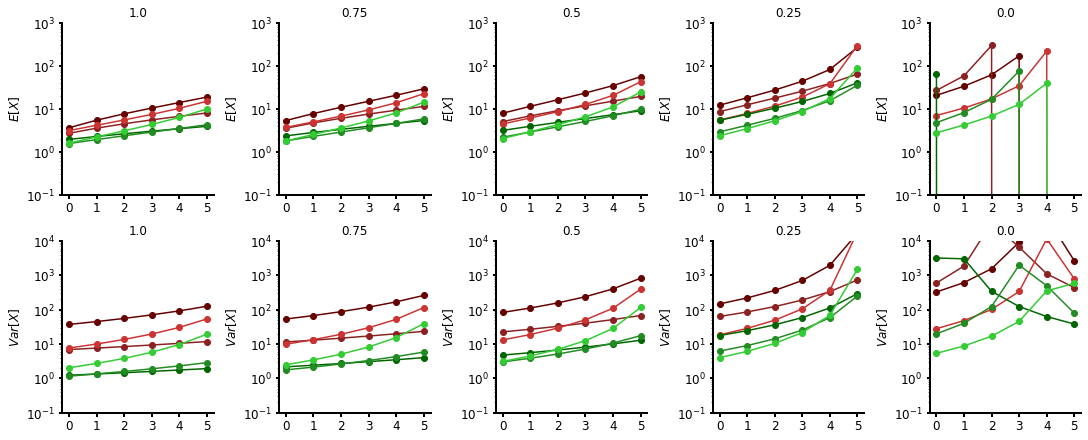

In [ ]:
targetlist = generate_targetList(4)[::-1]
fig, axs = plt.subplots(2, len(meankeys(targetlist)), figsize=(15, 6))
exampledata = prepare_data(animalList, dist60)

alpha = {}
gamma = {}
alpha_t = {}
gamma_t = {}
alpha_R = {}
gamma_R = {}
lossWald = {}

for animal in animalList:

    (alpha[animal], theta, gamma[animal], alpha_t[animal], thetaprime, gamma_t[animal], alpha_R[animal], thetasecond, gamma_R[animal]), lossWald[animal] = modelwald_fit(exampledata[animal])
    print(f"{animal}   a: {alpha[animal]:.2f}, a': {alpha_t[animal]:.2f}, a'': {alpha_R[animal]:.2f}, || g: {gamma[animal]:.2f}, g': {gamma_t[animal]:.2f}, g'': {gamma_R[animal]:.2f} ||| loss: {lossWald[animal]:.2f}")

    x = [0, 1, 2, 3, 4, 5]
    for i, avg in enumerate(meankeys(targetlist)):
        axs[0, i].plot(x, ([alpha[animal] + (bin*alpha_t[animal]) for bin in x] + i*alpha_R[animal])/([gamma[animal] + (bin*gamma_t[animal]) for bin in x] + i*gamma_R[animal]), color=rat_markers[animal][0], label=animal, marker='o')
        axs[0, i].set_title(f"{avg}")
        axs[0, i].set_xticks(x)
        axs[0, i].set_ylabel(r'$E[X]$')
        axs[0, i].set_ylim([0.1, 1000])
        axs[0, i].set_yscale('log')

        axs[1, i].plot(x, ([gamma[animal] + (bin*gamma_t[animal]) for bin in x] + i*gamma_R[animal])/(([gamma[animal] + (bin*gamma_t[animal]) for bin in x] + i*gamma_R[animal])**3), color=rat_markers[animal][0], label=animal, marker='o')
        axs[1, i].set_title(f"{avg}")
        axs[1, i].set_xticks(x)
        axs[1, i].set_ylabel(r'$Var[X]$')
        axs[1, i].set_ylim([0.1, 10000])
        axs[1, i].set_yscale('log')

### t_0
We fixed $t_0$ at 0, what happens if we fix it bigger?

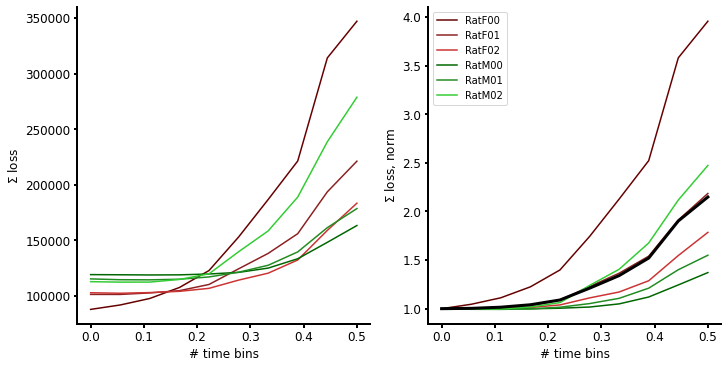

In [ ]:
# alpha, alpha', alpha'', gamma, gamma', gamma''
def model_compareT(params, *args, robustness_param=1e-20):
    alpha, theta, gamma, alpha_t, theta_prime, gamma_t, alpha_R, theta_second, gamma_R = params
    BIC = 0
    N_bins, N_avg, t_0 = args[1]
    ALPHA = np.zeros((N_bins, N_avg))
    GAMMA = np.zeros((N_bins, N_avg))
    _theta = t_0

    for bin in range(N_bins):
        for avg in range(N_avg):
            ALPHA[bin, avg] = alpha + bin*alpha_t + avg*alpha_R
            GAMMA[bin, avg] = gamma + bin*gamma_t + avg*gamma_R

    for bin in range(N_bins):
        for avg in range(N_avg):
            _alpha = ALPHA[bin, avg] if ALPHA[bin, avg] > 0 else 1e-8
            _gamma = GAMMA[bin, avg]# if GAMMA[bin, avg] > 0 else 1e-8
            try:
                pdf_vals = Wald_pdf(args[0][bin][avg], _alpha, _theta, _gamma)
                ln_pdf_vals = np.log(pdf_vals + robustness_param)
                log_lik_val = ln_pdf_vals.sum()

                n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
                k = 2  # alpha, gamma
                BIC += k * np.log(n) - 2 * log_lik_val
            except:
                BIC += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return BIC


def modelwald_fitT(data, init=[2, 0, .5, 0, 0, 0, 0, 0, 0], f=model_crit, N_bins=6, N_avg=4, t_0=0, alpha_t_fixed=False, gamma_t_fixed=False, alpha_R_fixed=False, gamma_R_fixed=False):
    params_init = np.array(init)
    alpha_t_bounds = (None, None) if not alpha_t_fixed else (0, 1e-8)
    gamma_t_bounds = (None, None) if not gamma_t_fixed else (0, 1e-8)
    alpha_R_bounds = (None, None) if not alpha_R_fixed else (0, 1e-8)
    gamma_R_bounds = (None, None) if not gamma_R_fixed else (0, 1e-8)

    res = scipy.optimize.minimize(f, params_init, args=(data, [N_bins, N_avg, t_0]), 
                                        bounds=((0, None), (0, 1e-8), (0, None), 
                                            alpha_t_bounds, (0, 1e-8), gamma_t_bounds, 
                                            alpha_R_bounds, (0, 1e-8), gamma_R_bounds))
    return res.x, res.fun



memsize = 4
t_0s = np.linspace(0, 1, 26)
t_0s = np.linspace(0, .5, 10)

losses = {k:np.zeros(len(t_0s)) for k in animalList}
sessions = dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20

for idx, t_0 in enumerate(t_0s):
    data_all = prepare_data(animalList, sessions, memsize=3, time_bins=6)
    for animal in animalList:
        p, losses[animal][idx] = modelwald_fitT(data_all[animal], t_0=t_0, f=model_compareT, N_bins=6, N_avg=len(meankeys(generate_targetList(seq_len=4)[::-1])))


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
avglosses = np.zeros(len(t_0s))
for idx, animal in enumerate(animalList):
    axs[0].plot(t_0s, losses[animal], color=rat_markers[animal][0])
    axs[1].plot(t_0s, (losses[animal])/(losses[animal][0]), color=rat_markers[animal][0], label=animal)
    avglosses += losses[animal]

axs[1].plot(t_0s, avglosses/avglosses[0], color='k', lw=3)

axs[0].set_xlabel('# time bins')
axs[1].set_xlabel('# time bins')
axs[0].set_ylabel(r'$\Sigma$ loss')
axs[1].set_ylabel(r'$\Sigma$ loss, norm')
axs[1].legend()

## 7) Single fits
Fit each cell independantly, then linear fit on parameters. 
's? ''s?

RatF00 alpha: 0.98, 0.35, 0.07 ||| gamma: 0.24, -0.04, -0.08
RatF01 alpha: 1.12, 0.25, 0.01 ||| gamma: 0.17, -0.02, -0.19
RatF02 alpha: 1.17, 0.37, 0.03 ||| gamma: 0.29, -0.03, -0.12
RatM00 alpha: 1.13, 0.29, -0.10 ||| gamma: 0.35, -0.05, -0.12
RatM01 alpha: 1.17, 0.15, -0.08 ||| gamma: 0.43, -0.07, -0.18
RatM02 alpha: 1.06, 0.19, -0.16 ||| gamma: 0.38, -0.06, -0.18


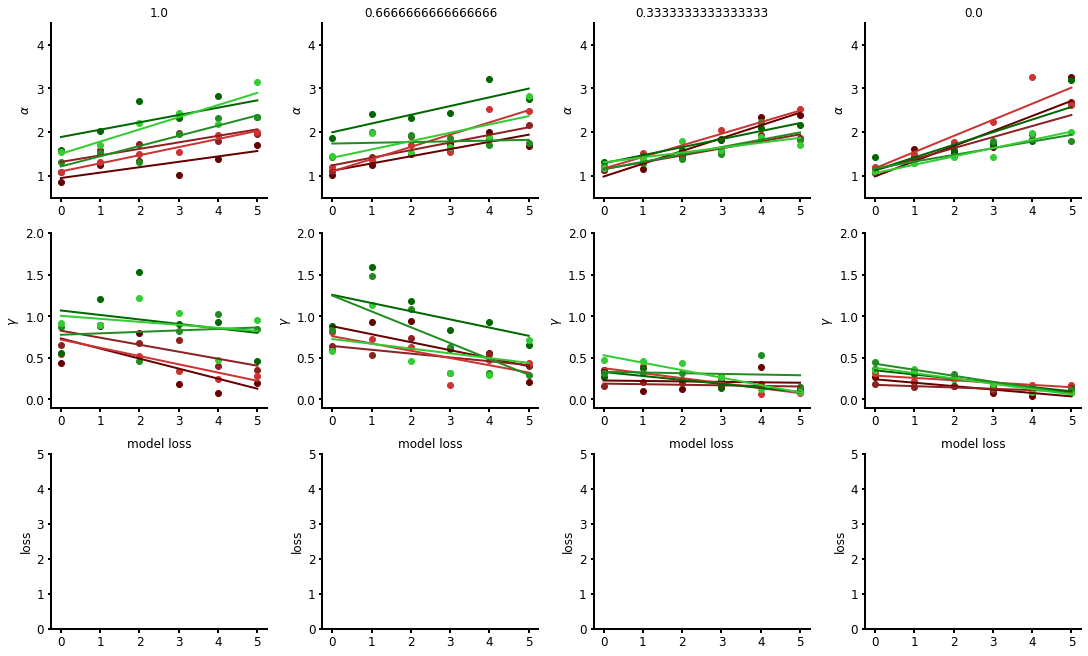

In [ ]:
# alpha, alpha', alpha'', gamma, gamma', gamma''
def model_crit_indep(params, *args, robustness_param=1e-20):
    alpha, theta, gamma = params
    BIC = 0
    N_bins, N_avg = args[1]

    try:
        pdf_vals = Wald_pdf(args[0], alpha, theta, gamma)
        ln_pdf_vals = np.log(pdf_vals + robustness_param)
        log_lik_val = ln_pdf_vals.sum()

        n = len(args[0]) if len(args[0]) > 0 else 1
        k = 2
        BIC += k * np.log(n) - 2 * log_lik_val

    except:
        BIC += 0

    return BIC

#params = a, t, g, a', t', g', a'', t'', g''
def modelwald_fit_indep(data, init=[2, 0, .5], N_bins=6, N_avg=5):
    params_init = np.array(init)
    res = scipy.optimize.minimize(model_crit_indep, params_init, args=(data, [N_bins, N_avg]), 
                                        bounds=((0, None), (0, 1e-8), (0, None)))
    return res.x, res.fun


# example fit all 120 cm session
targetlist = generate_targetList(3)[::-1]
fig, axs = plt.subplots(3, len(meankeys(targetlist)), figsize=(15, 9))
exampledata = prepare_data(animalList, dist120)

alpha = {}
gamma = {}
lossWald = {}

x=np.arange(0, 6)
for animal in animalList:
    alpha[animal] = {}
    gamma[animal] = {}
    lossWald[animal] = {}
    for bin in range(6):
        alpha[animal][bin] = {k:[] for k in range(5)}
        gamma[animal][bin] = {k:[] for k in range(5)}
        lossWald[animal][bin] = {k:[] for k in range(5)}
        for avg in range(4):
            (alpha[animal][bin][avg], theta, gamma[animal][bin][avg]), lossWald[animal][bin][avg] = modelwald_fit_indep(exampledata[animal][bin][avg])

            axs[0, avg].scatter(bin, alpha[animal][bin][avg], color=rat_markers[animal][0], label=animal, marker='o')
            axs[1, avg].scatter(bin, gamma[animal][bin][avg], color=rat_markers[animal][0], label=animal, marker='o')
            axs[2, avg].scatter(bin, lossWald[animal][bin][avg], color=rat_markers[animal][0], label=animal, marker='o')

            axs[0, avg].set_title(f"{abs((avg-3)/3)}")
            axs[0, avg].set_xticks(x)
            axs[0, avg].set_ylabel(r'$\alpha$')
            axs[0, avg].set_ylim([.5, 4.5])


            axs[1, avg].set_xticks(x)
            axs[1, avg].set_ylabel(r'$\gamma$')
            axs[1, avg].set_ylim([-.1, 2])


            axs[2, avg].set_title(f"model loss")
            axs[2, avg].set_ylabel(r'loss')
            axs[2, avg].set_ylim([.0, 5])
            axs[2, avg].set_xticks(x)

    
    for avg in range(4):
        x = np.array([0, 1, 2, 3, 4, 5])
        try:
            gradientA_prime, interceptA_prime, r_value, p_value, std_err = stats.linregress(x, np.array([alpha[animal][bin][avg] for bin in range(6)]))
            gradientG_prime, interceptG_prime, r_value, p_value, std_err = stats.linregress(x, np.array([gamma[animal][bin][avg] for bin in range(6)]))
            axs[0, avg].plot(np.linspace(0,5,100), gradientA_prime * np.linspace(0,5,100) + interceptA_prime, color=rat_markers[animal][0], lw=2)
            axs[1, avg].plot(np.linspace(0,5,100), gradientG_prime * np.linspace(0,5,100) + interceptG_prime, color=rat_markers[animal][0], lw=2)
        except:
            pass
    
    # for bin in range(6):
    gradientA_second, interceptA_second, r_value, p_value, std_err = stats.linregress([0, 1, 2, 3, ], [alpha[animal][0][avg] for avg in range(4)])
    gradientG_second, interceptG_second, r_value, p_value, std_err = stats.linregress([0, 1, 2, 3, ], [gamma[animal][0][avg] for avg in range(4)])


    print(f"{animal} alpha: {interceptA_prime:.2f}, {gradientA_prime:.2f}, {gradientA_second:.2f} ||| gamma: {interceptG_prime:.2f}, {gradientG_prime:.2f}, {gradientG_second:.2f}")


# RatF00 alpha: 0.87, 0.37, 0.03 ||| gamma: 0.26, -0.04, -0.10
# RatF01 alpha: 0.91, 0.23, -0.06 ||| gamma: 0.18, -0.02, -0.16
# RatF02 alpha: 1.19, 0.31, 0.02 ||| gamma: 0.31, -0.03, -0.11
# RatM00 alpha: 1.33, 0.13, -0.08 ||| gamma: 0.34, -0.04, -0.11
# RatM01 alpha: 1.17, 0.16, -0.08 ||| gamma: 0.41, -0.07, -0.16
# RatM02 alpha: 0.49, 0.54, -0.16 ||| gamma: 0.43, -0.07, -0.15

3.9696969696969697


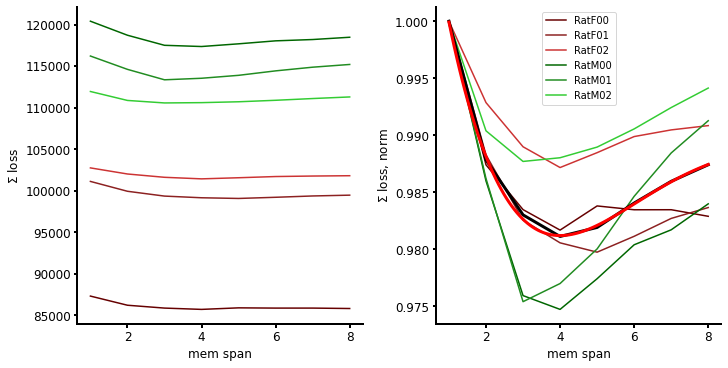

In [ ]:
# example memsize
memsizes = np.arange(1, 9)

losses = {k:np.zeros(len(memsizes)) for k in animalList}
sessions = dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20

for idx, memsize in enumerate(memsizes):
    data_all = prepare_data(animalList, sessions, memsize=memsize, time_bins=6)
    for animal in animalList:
        for bin in range(6):
            for avg in range(len(meankeys(generate_targetList(seq_len=memsize)[::-1]))):
                p, l = modelwald_fit_indep(data_all[animal][bin][avg], N_bins=6, N_avg=len(meankeys(generate_targetList(seq_len=memsize)[::-1])))
                losses[animal][idx] += l


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
avglosses = np.zeros((len(animalList), len(memsizes)))
for idx, animal in enumerate(animalList):
    axs[0].plot(memsizes, losses[animal], color=rat_markers[animal][0])
    axs[1].plot(memsizes, (losses[animal])/(losses[animal][0]), color=rat_markers[animal][0], label=animal)
    avglosses[idx] = losses[animal]/losses[animal][0]

f = np.mean(avglosses[:3], axis=0)
m = np.mean(avglosses[3:], axis=0)
avglosses = np.median(avglosses, axis=0)

axs[1].plot(memsizes, avglosses, color='k', lw=3)
z = np.poly1d(np.polyfit(memsizes, avglosses, 4))
x=np.linspace(1, 8, 100)
axs[1].plot(x, z(x), color='r', lw=3)
print(x[np.argmin(z(x))])
# axs[0].plot(memsizes, f/3, color='r', lw=2, ls='--')
# axs[0].plot(memsizes, m/3, color='g', lw=2, ls='--')
# axs[1].plot(memsizes, f, color='r', lw=2, ls='--')
# axs[1].plot(memsizes, m, color='g', lw=2, ls='--')

axs[0].set_xlabel('mem span')
axs[1].set_xlabel('mem span')
axs[0].set_ylabel(r'$\Sigma$ loss')
axs[1].set_ylabel(r'$\Sigma$ loss, norm')
axs[1].legend()

# next
$\alpha$, $\gamma$, $\alpha'$, $\gamma'$, $\alpha''$, $\gamma''$ function of time/#reward/total Dist ?

# fit running times
Same method to fit running times distributions  
potential candidates: lognorm, bof, params ok  
!!! cauchy: looks good, params mok  
inverse gamma: mok, but params nope  

# lognorm

In [ ]:
# alpha, alpha', alpha'', gamma, gamma', gamma''
from scipy.stats import lognorm
def modelrun_crit(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second, loc = params
    neg_log_lik_val = 0
    N_bins, N_avg = args[1]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg] if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            pdf_vals = lognorm.pdf(args[0][bin][avg], scale=_sigma, s=_mu, loc=loc)
            # print(pdf_vals)
            ln_pdf_vals = np.log(pdf_vals + robustness_param)
            log_lik_val = ln_pdf_vals.sum()

            n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
            neg_log_lik_val += (-log_lik_val / n)
            # except:
            #     neg_log_lik_val += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return neg_log_lik_val


#params = a, t, g, a', t', g', a'', t'', g''
def modelrun_fit(data, init=[1, 1, 1, 1, 1, 1, 1], f=modelrun_crit, N_bins=6, N_avg=4, alpha_t_fixed=False, gamma_t_fixed=False, alpha_R_fixed=False, gamma_R_fixed=False, loc_bounds=(0, None)):
    params_init = np.array(init)
    alpha_t_bounds = (None, None) if not alpha_t_fixed else (0, 1e-8)
    gamma_t_bounds = (None, None) if not gamma_t_fixed else (0, 1e-8)
    alpha_R_bounds = (None, None) if not alpha_R_fixed else (0, 1e-8)
    gamma_R_bounds = (None, None) if not gamma_R_fixed else (0, 1e-8)

    res = scipy.optimize.minimize(f, params_init, args=(data, [N_bins, N_avg]), 
                                        bounds=((0, None), (0, None), 
                                            alpha_t_bounds, gamma_t_bounds, 
                                            alpha_R_bounds, gamma_R_bounds, loc_bounds))
    return res.x, res.fun

modelrun_fit(data60[animal])

(array([0.83376503, 0.48270458, 0.02214846, 0.66860778, 0.14492567,
        0.24403454, 0.20411556]),
 59.67433446885336)

In [ ]:
def get_running_times(data, memsize=3, filter=[0, 3600], tooshort=0.5):
    """get waiting times from data"""
    running_times = {k:[] for k in meankeys(generate_targetList(seq_len=memsize)[::-1])}
    for i in range(len(data)):
        if data[i][1] == 'run':
            if filter[0] <= data[i][0] <= filter[1] and data[i][3] != 0:
                if data[i][3] > tooshort:  # filter out waits shorter than 0.5s
                    try:
                        avg_rwd = round(np.mean([data[i-n-1][2] for n in range(1, (memsize*2)+1, 2)]),2)
                        running_times[avg_rwd].append(data[i][3])
                    except:  # put the first n waits in rwd=1 (because we don't have the previous n runs to compute the average reward)
                        running_times[1].append(data[i][3])
    return running_times

# separate the data into time and reward bins
def prepare_dataR(animalList, sessionList, memsize=3, time_bins=6):
    bin_size = 3600/time_bins
    targetlist = generate_targetList(memsize)[::-1]
    temp_data = {}
    for bin in range(time_bins):
        temp_data[bin] = {}
        for animal in animalList:
            temp_data[bin][animal] = {k:[] for k in meankeys(targetlist)}
            for session in matchsession(animal, sessionList):
                temp_data[bin][animal] = combine_dict(temp_data[bin][animal], get_running_times(sequence[animal, session], memsize=memsize, filter=[bin*bin_size, (bin+1)*bin_size]))
    
    data = {}
    for animal in animalList:
        data[animal] = np.zeros((time_bins, len(meankeys(targetlist)))).tolist()
        for i, avg in enumerate(meankeys(targetlist)):  # 1 -> 0
            for bin in range(time_bins):
                data[animal][bin][i] = np.asarray(temp_data[bin][animal][avg])
    return data


data60 = prepare_dataR(animalList, dist60)
data90 = prepare_dataR(animalList, dist90)
data120 = prepare_dataR(animalList, dist120)

data20 = prepare_dataR(animalList, TM20)
data10 = prepare_dataR(animalList, TM10)
data2 = prepare_dataR(animalList, TM2+TMrev2)
datarev10 = prepare_dataR(animalList, TMrev10)
datarev20 = prepare_dataR(animalList, TMrev20)

RatF00   a: 0.68, a': -0.01, a'': 0.11, || g: 0.39, g': 0.09, g'': 0.05, loc:0.98 ||| loss: 21.65
RatF01   a: 0.58, a': -0.04, a'': 0.20, || g: 0.37, g': 0.06, g'': 0.06, loc:1.01 ||| loss: 15.60
RatF02   a: 0.66, a': -0.02, a'': 0.16, || g: 0.31, g': 0.20, g'': 0.01, loc:1.02 ||| loss: 28.58
RatM00   a: 0.48, a': -0.05, a'': 0.16, || g: 0.35, g': 0.06, g'': -0.01, loc:1.02 ||| loss: 3.56
RatM01   a: 0.32, a': -0.03, a'': 0.12, || g: 0.53, g': 0.05, g'': 0.00, loc:0.87 ||| loss: 4.19
RatM02   a: 0.40, a': -0.00, a'': 0.23, || g: 0.38, g': 0.05, g'': -0.07, loc:1.01 ||| loss: 21.93


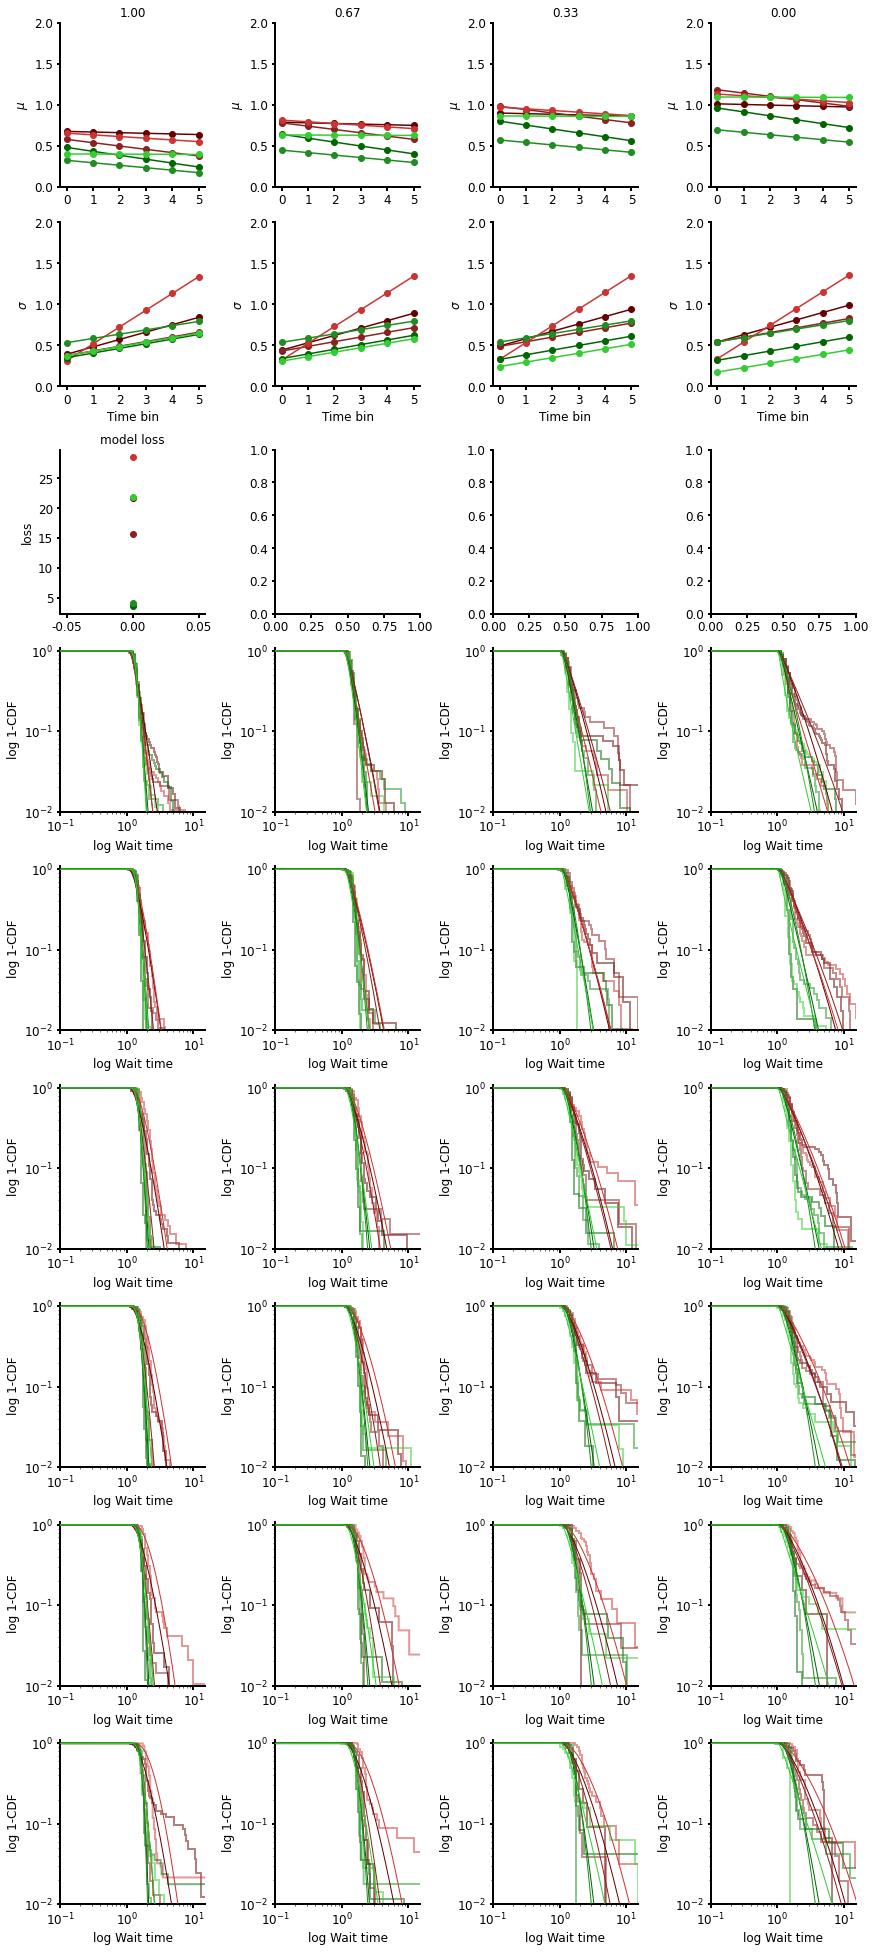

In [ ]:
# example fit all 120 cm session
targetlist = generate_targetList(3)[::-1]
fig, axs = plt.subplots(9, len(meankeys(targetlist)), figsize=(12, 27))
exampledata = prepare_dataR(animalList, dist120)

mu = {}
sigma = {}
mu_prime = {}
sigma_prime = {}
mu_second = {}
sigma_second = {}
lossWald = {}
loc = {}

def plot_lognorm_fitted(waits, p, ax=None, color='k'):
    if ax is None: ax = plt.gca()
    waits = np.asarray(waits)

    bins=np.linspace(0, waits.max(), int(max(waits))*10)
    ydata, xdata, _ = ax.hist(waits, bins=bins,
                    color=color, alpha=.5, zorder=1, 
                    density=True, # weights=np.ones_like(waits) / len(waits),
                    histtype="step", lw=2, 
                    cumulative=-1,
                    )

    x = np.linspace(0.01, 500, 10000)
    # (alpha, theta, gamma) = p
    s, loc, scale = p
    ax.plot(x, lognorm.sf(x, s=s, scale=scale, loc=loc), color=color, lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')

    # ax.plot(x, 1-Wald_cdf(x, alpha, theta, gamma), color=color, lw=1, zorder=4, label=f'mean={gamma:.2f}, A={alpha:.2f}, t0={theta:.2f}')

    ax.set_xlim(.1, 15)
    ax.set_ylim(.01, 1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel('log Wait time')
    ax.set_ylabel('log 1-CDF')

    return ax


for animal in animalList:

    (mu[animal], sigma[animal], 
        mu_prime[animal], sigma_prime[animal], 
        mu_second[animal], sigma_second[animal], loc[animal]), lossWald[animal] = modelrun_fit(exampledata[animal], loc_bounds=(0, 2))#(0, 0, 0, 0, 0, 0, 0, 0, 0, ), 0

    print(f"{animal}   a: {mu[animal]:.2f}, a': {mu_prime[animal]:.2f}, a'': {mu_second[animal]:.2f}, || g: {sigma[animal]:.2f}, g': {sigma_prime[animal]:.2f}, g'': {sigma_second[animal]:.2f}, loc:{loc[animal]:.2f} ||| loss: {lossWald[animal]:.2f}")

    x = [0, 1, 2, 3, 4, 5]
    for i, avg in enumerate(meankeys(targetlist)):
        axs[0, i].plot(x, [mu[animal] + (bin*mu_prime[animal]) for bin in x] + i*mu_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
        axs[0, i].set_title(f"{avg:.2f}")
        axs[0, i].set_xticks(x)
        # axs[0, i].set_xlabel('Time bin')
        axs[0, i].set_ylabel(r'$\mu$')
        axs[0, i].set_ylim([0, 2])
        
        axs[1, i].plot(x, [sigma[animal] + (bin*sigma_prime[animal]) for bin in x] + i*sigma_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
        # axs[1, i].set_title(f"{avg:.2f}")
        axs[1, i].set_xticks(x)
        axs[1, i].set_xlabel('Time bin')
        axs[1, i].set_ylabel(r'$\sigma$')
        axs[1, i].set_ylim([0, 2])

    y = lossWald[animal]
    axs[2, 0].plot(0, y, color=rat_markers[animal][0], label=animal, marker='o')
    axs[2, 0].set_title(f"model loss")
    axs[2, 0].set_ylabel(r'loss')

    for j in range(6):
        for i, avg in enumerate(meankeys(targetlist)):
            plot_lognorm_fitted(exampledata[animal][j][i], (mu[animal] + j*mu_prime[animal] + i*mu_second[animal], loc[animal], sigma[animal] + j*sigma_prime[animal] + i*sigma_second[animal]), ax=axs[3+j, i], color=rat_markers[animal][0])
# 0
# RatF00   a: 0.25, a': 0.02, a'': 0.09, || g: 1.42, g': 0.10, g'': 0.09, loc:0.00 ||| loss: 26.99
# RatF01   a: 0.20, a': -0.01, a'': 0.15, || g: 1.45, g': 0.04, g'': 0.11, loc:0.00 ||| loss: 22.18
# RatF02   a: 0.16, a': 0.05, a'': 0.11, || g: 1.37, g': 0.21, g'': 0.06, loc:0.00 ||| loss: 31.07
# RatM00   a: 0.12, a': -0.00, a'': 0.10, || g: 1.40, g': 0.05, g'': 0.02, loc:0.00 ||| loss: 12.75
# RatM01   a: 0.12, a': -0.01, a'': 0.08, || g: 1.42, g': 0.05, g'': 0.02, loc:0.00 ||| loss: 9.54
# RatM02   a: 0.10, a': 0.02, a'': 0.09, || g: 1.39, g': 0.06, g'': -0.03, loc:0.00 ||| loss: 12.11

#1
# RatF00   a: 0.71, a': -0.01, a'': 0.10, || g: 0.37, g': 0.09, g'': 0.05, loc:1.00 ||| loss: 23.75
# RatF01   a: 0.56, a': -0.04, a'': 0.20, || g: 0.39, g': 0.06, g'': 0.06, loc:1.00 ||| loss: 15.63
# RatF02   a: 0.61, a': -0.01, a'': 0.15, || g: 0.34, g': 0.20, g'': 0.01, loc:1.00 ||| loss: 28.70
# RatM00   a: 0.44, a': -0.04, a'': 0.16, || g: 0.37, g': 0.06, g'': -0.01, loc:1.00 ||| loss: 3.65
# RatM01   a: 0.45, a': -0.05, a'': 0.13, || g: 0.39, g': 0.05, g'': 0.00, loc:1.00 ||| loss: 5.81
# RatM02   a: 0.39, a': 0.00, a'': 0.22, || g: 0.38, g': 0.05, g'': -0.07, loc:1.00 ||| loss: 21.95

0 60 vs 90: 0.004 *
0 60 vs 120: 0.000 *
0 90 vs 120: 0.000 *
1 60 vs 90: 0.021 *
2 60 vs 120: 0.008 *
3 60 vs 90: 0.036 *
3 60 vs 120: 0.001 *
3 90 vs 120: 0.015 *
5 60 vs 90: 0.045 *
5 60 vs 120: 0.007 *
0 20 vs rev10: 0.048 *
0 20 vs rev20: 0.017 *
5 20 vs 2: 0.019 *
5 2 vs rev10: 0.036 *
5 2 vs rev20: 0.043 *


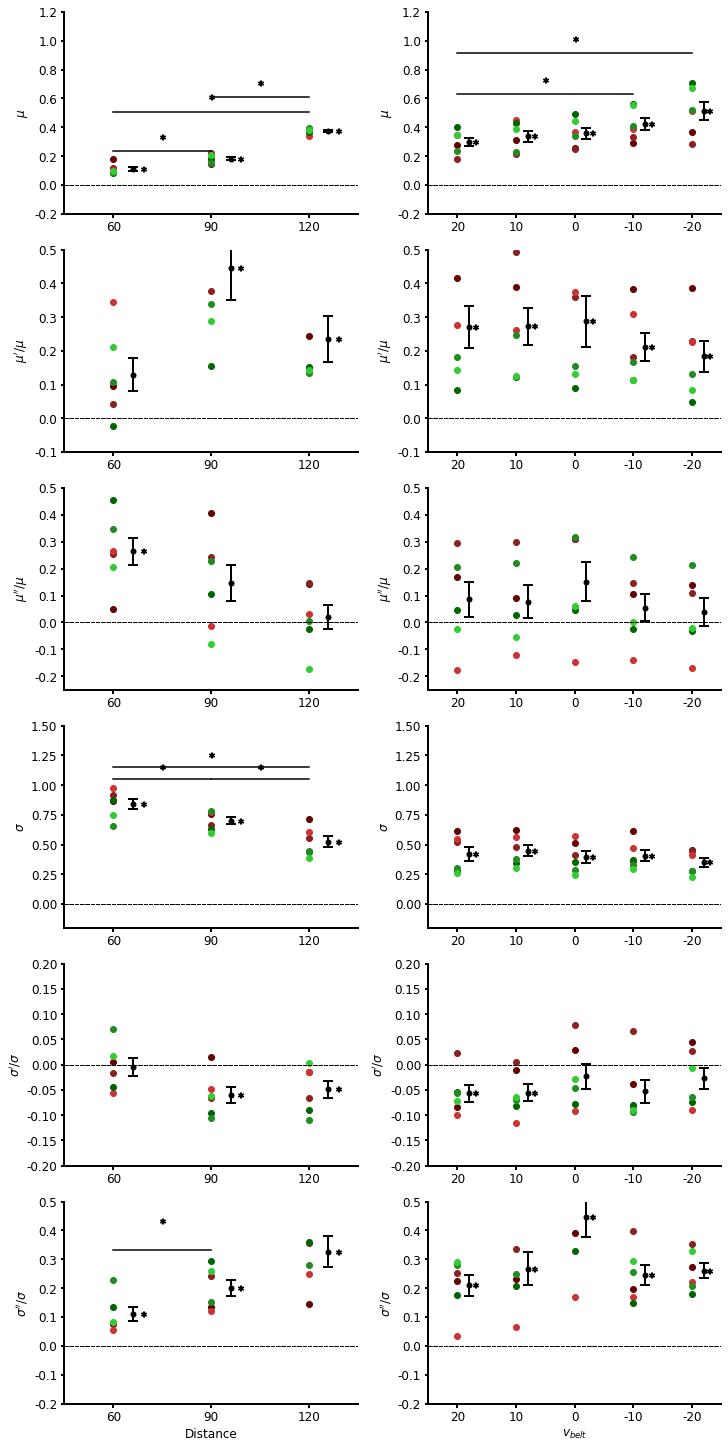

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
ylabels = [r'$\mu$', r"$\mu'$", r"$\mu''$", r'$\sigma$', r"$\sigma'$", r"$\sigma''$"]
ylabels = [r'$\mu$', r"$\mu'/\mu$", r"$\mu''/\mu$", r'$\sigma$', r"$\sigma'/\sigma$", r"$\sigma''/\sigma$"]
ylims = [[-.2, 1.2], [-.1, .5], [-.25, .5], [-.2, 1.5], [-.2, .2], [-.2, .5], ]


alpha = {}
gamma = {}
alpha_t = {}
gamma_t = {}
alpha_R = {}
gamma_R = {}
lossWald = {}

alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, True, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = True, True, True, True

for animal in animalList:

    alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
        (alpha[animal][cond], gamma[animal][cond], \
        alpha_t[animal][cond], gamma_t[animal][cond], \
        alpha_R[animal][cond], gamma_R[animal][cond], loc), lossWald[animal][cond] = modelrun_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                    gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                    loc_bounds=(1, 1+1e-8))
        ############ normalize p' and p'' by p
        # alpha_t[animal][cond] /= alpha[animal][cond]
        # gamma_t[animal][cond] /= gamma[animal][cond]
        # alpha_R[animal][cond] /= alpha[animal][cond]
        # gamma_R[animal][cond] /= gamma[animal][cond]
        ################

    vars = [gamma, gamma_t, gamma_R, alpha, alpha_t, alpha_R, ]

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 0].scatter(np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]], color=rat_markers[animal][0], label=animal)
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 1].scatter(np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], color=rat_markers[animal][0], label=animal)
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)
axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')

#mean per condition
for idx, cond in enumerate(["60", "90", "120"]):
    for jdx, var in enumerate([gamma, gamma_t, gamma_R, alpha, alpha_t, alpha_R, ]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))
        s, p = stats.ttest_1samp(d, 0)
        if p < .05: axs[jdx, 0].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 0].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

for idx, cond in enumerate(["20", "10", "2", "rev10", "rev20"]):
    for jdx, var in enumerate([gamma, gamma_t, gamma_R, alpha, alpha_t, alpha_R, ]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))
        s, p = stats.ttest_1samp(d, 0)
        if p < .05: axs[jdx, 1].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 1].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

test_all_conds_between_themselves(["60", "90", "120"], vars, ax=axs[:, 0])
test_all_conds_between_themselves(["20", "10", "2", "rev10", "rev20"], vars, ax=axs[:, 1])

# pickle

# pickle.dump([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R], open("picklejar/main_fitting_results.p", "wb"))

# cauchy

Text(0, 0.5, 'CDF')

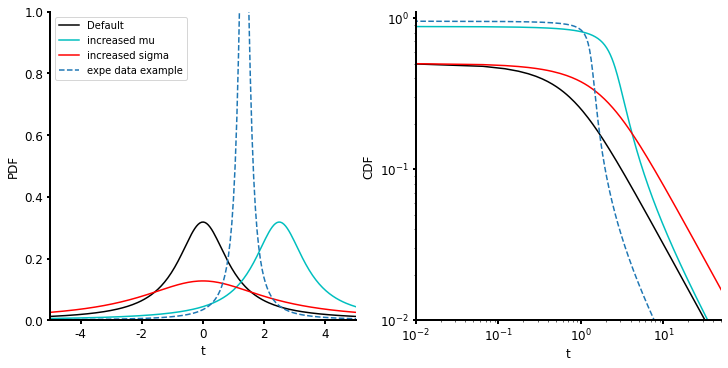

In [ ]:
from scipy.stats import cauchy
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
x = np.linspace(-5, 50, 1000)
axs[0].plot(x, cauchy.pdf(x, 0, 1), 'k-', label='Default')
axs[0].plot(x, cauchy.pdf(x, 2.5, 1), 'c', label='increased mu')
axs[0].plot(x, cauchy.pdf(x, 0, 2.5), 'r-', label='increased sigma')
axs[0].plot(x, cauchy.pdf(x, 1.35, .2), '--', label='expe data example')
axs[0].set_ylabel('PDF')
axs[0].set_xlabel('t')
axs[0].set_xlim(-5, 5)
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].plot(x, cauchy.sf(x, 0, 1), 'k-', label='Default')
axs[1].plot(x, cauchy.sf(x, 2.5, 1), 'c', label='increased mu')
axs[1].plot(x, cauchy.sf(x, 0, 2.5), 'r-', label='increased sigma')
axs[1].plot(x, cauchy.sf(x, 1.35, .2), '--', label='expe data example')
axs[1].set_xlabel('t')
axs[1].set_xlim(0.01, 50)
axs[1].set_ylim(0.01, 1.1)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_ylabel('CDF')

In [ ]:
# ok
from scipy.stats import cauchy
def modelrun_crit(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
    neg_log_lik_val = 0
    N_bins, N_avg = args[1]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg] if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            pdf_vals = cauchy.pdf(args[0][bin][avg], scale=_sigma, loc=_mu,)
            # print(pdf_vals)
            ln_pdf_vals = np.log(pdf_vals + robustness_param)
            log_lik_val = ln_pdf_vals.sum()

            n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
            neg_log_lik_val += (-log_lik_val / n)
            # except:
            #     neg_log_lik_val += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return neg_log_lik_val



#params = a, t, g, a', t', g', a'', t'', g''
def modelrun_fit(data, init=[1, 1, 1, 1, 1, 1], f=modelrun_crit, N_bins=6, N_avg=4, alpha_t_fixed=False, gamma_t_fixed=False, alpha_R_fixed=False, gamma_R_fixed=False, ):
    params_init = np.array(init)
    alpha_t_bounds = (None, None) if not alpha_t_fixed else (0, 1e-8)
    gamma_t_bounds = (None, None) if not gamma_t_fixed else (0, 1e-8)
    alpha_R_bounds = (None, None) if not alpha_R_fixed else (0, 1e-8)
    gamma_R_bounds = (None, None) if not gamma_R_fixed else (0, 1e-8)

    res = scipy.optimize.minimize(f, params_init, args=(data, [N_bins, N_avg]), 
                                        bounds=((0, None), (0, None), 
                                            alpha_t_bounds, gamma_t_bounds, 
                                            alpha_R_bounds, gamma_R_bounds))
    return res.x, res.fun

modelrun_fit(data60[animal])

(array([ 0.87972376,  0.1000332 ,  0.05779568,  0.01816259, -0.0029605 ,
         0.0048597 ]),
 7.302685647545681)

RatF00   a: 1.37, a': 0.09, a'': -0.00, || g: 0.11, g': 0.02, g'': 0.03,||| loss: 20.65
RatF01   a: 1.39, a': 0.06, a'': 0.00, || g: 0.09, g': 0.01, g'': 0.04,||| loss: 14.91
RatF02   a: 1.34, a': 0.16, a'': -0.02, || g: 0.11, g': 0.03, g'': 0.03,||| loss: 23.25
RatM00   a: 1.35, a': 0.06, a'': -0.02, || g: 0.08, g': -0.00, g'': 0.01,||| loss: -2.32
RatM01   a: 1.39, a': 0.06, a'': -0.01, || g: 0.10, g': -0.00, g'': 0.01,||| loss: -0.40
RatM02   a: 1.40, a': 0.05, a'': -0.08, || g: 0.07, g': 0.01, g'': 0.02,||| loss: 3.88


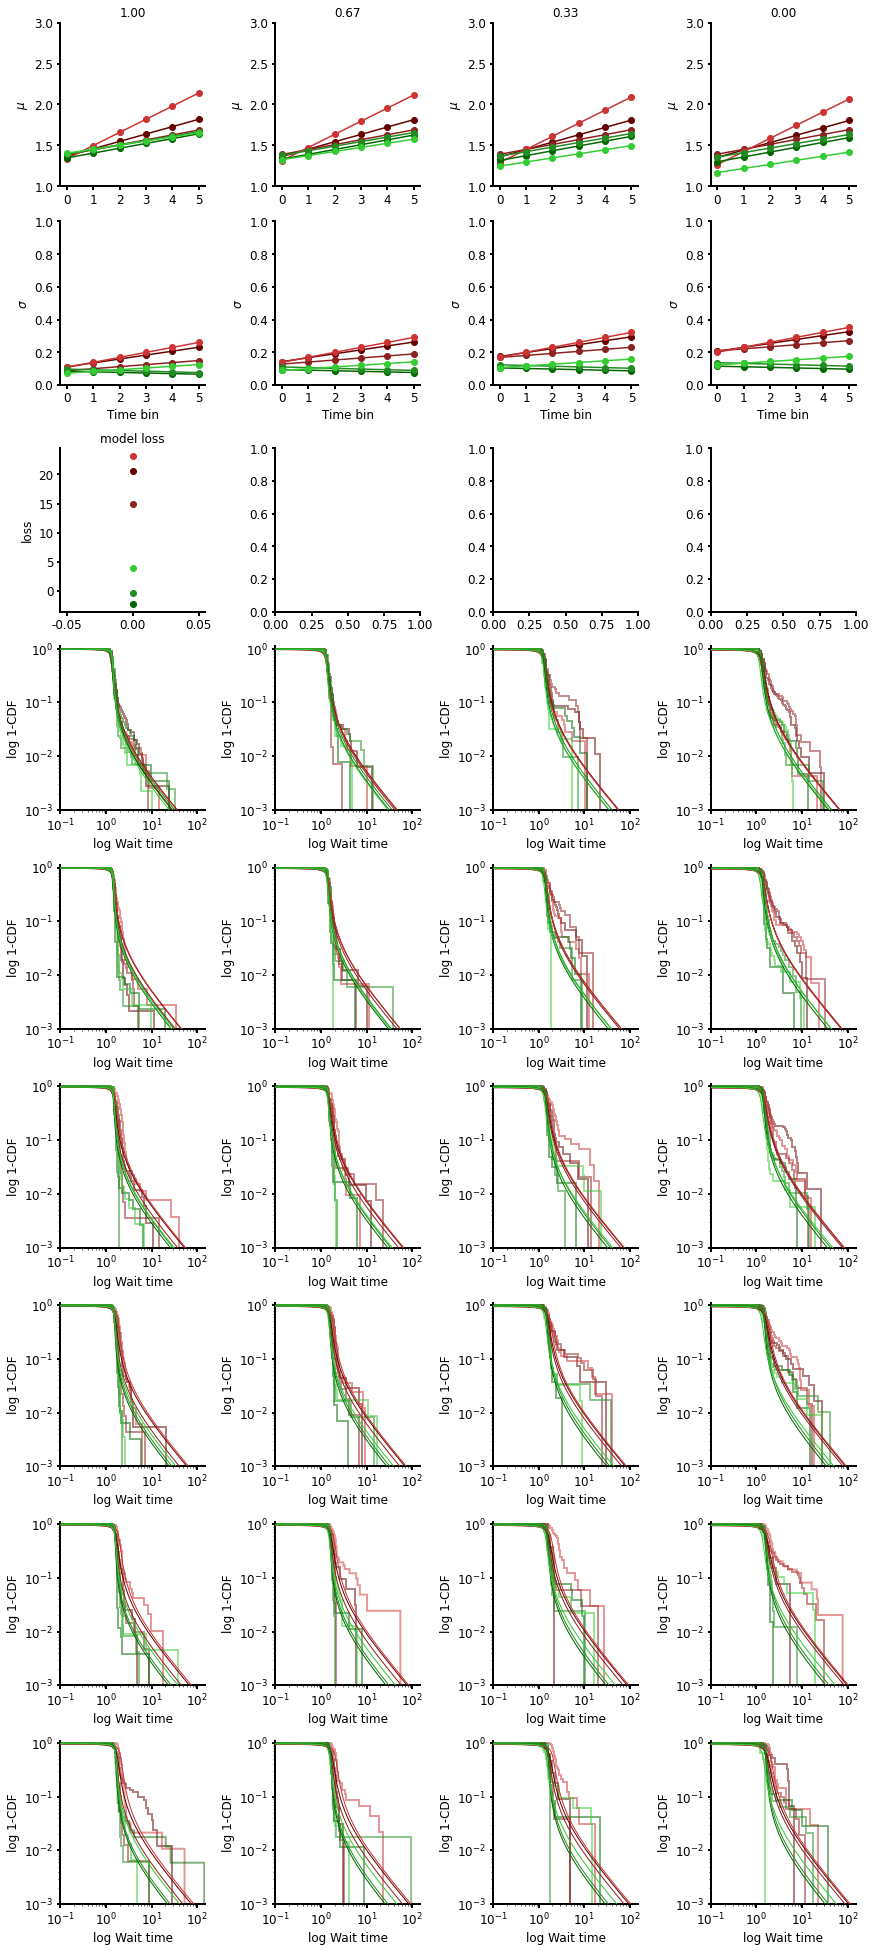

In [ ]:
# ok
targetlist = generate_targetList(3)[::-1]
fig, axs = plt.subplots(9, len(meankeys(targetlist)), figsize=(12, 27))
exampledata = prepare_dataR(animalList, dist120)

mu = {}
sigma = {}
mu_prime = {}
sigma_prime = {}
mu_second = {}
sigma_second = {}
lossWald = {}
loc = {}

def plot_cauchy_fitted(waits, p, ax=None, color='k'):
    if ax is None: ax = plt.gca()
    waits = np.asarray(waits)

    bins=np.linspace(0, waits.max(), int(max(waits))*10)
    ydata, xdata, _ = ax.hist(waits, bins=bins,
                    color=color, alpha=.5, zorder=1, 
                    density=True, # weights=np.ones_like(waits) / len(waits),
                    histtype="step", lw=2, 
                    cumulative=-1,
                    )

    x = np.linspace(0.01, 500, 10000)
    # (alpha, theta, gamma) = p
    loc, scale = p
    ax.plot(x, cauchy.sf(x, scale=scale, loc=loc), color=color, lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')

    # ax.plot(x, 1-Wald_cdf(x, alpha, theta, gamma), color=color, lw=1, zorder=4, label=f'mean={gamma:.2f}, A={alpha:.2f}, t0={theta:.2f}')

    ax.set_xlim(.1, 150)
    ax.set_ylim(.001, 1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel('log Wait time')
    ax.set_ylabel('log 1-CDF')

    return ax


for animal in animalList:

    (mu[animal], sigma[animal], 
        mu_prime[animal], sigma_prime[animal], 
        mu_second[animal], sigma_second[animal]), lossWald[animal] = modelrun_fit(exampledata[animal])#(0, 0, 0, 0, 0, 0, 0, 0, 0, ), 0

    print(f"{animal}   a: {mu[animal]:.2f}, a': {mu_prime[animal]:.2f}, a'': {mu_second[animal]:.2f}, || g: {sigma[animal]:.2f}, g': {sigma_prime[animal]:.2f}, g'': {sigma_second[animal]:.2f},||| loss: {lossWald[animal]:.2f}")

    x = [0, 1, 2, 3, 4, 5]
    for i, avg in enumerate(meankeys(targetlist)):
        axs[0, i].plot(x, [mu[animal] + (bin*mu_prime[animal]) for bin in x] + i*mu_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
        axs[0, i].set_title(f"{avg:.2f}")
        axs[0, i].set_xticks(x)
        # axs[0, i].set_xlabel('Time bin')
        axs[0, i].set_ylabel(r'$\mu$')
        axs[0, i].set_ylim([1, 3])
        
        axs[1, i].plot(x, [sigma[animal] + (bin*sigma_prime[animal]) for bin in x] + i*sigma_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
        # axs[1, i].set_title(f"{avg:.2f}")
        axs[1, i].set_xticks(x)
        axs[1, i].set_xlabel('Time bin')
        axs[1, i].set_ylabel(r'$\sigma$')
        axs[1, i].set_ylim([0, 1])

    y = lossWald[animal]
    axs[2, 0].plot(0, y, color=rat_markers[animal][0], label=animal, marker='o')
    axs[2, 0].set_title(f"model loss")
    axs[2, 0].set_ylabel(r'loss')

    for j in range(6):
        for i, avg in enumerate(meankeys(targetlist)):
            plot_cauchy_fitted(exampledata[animal][j][i], (mu[animal] + j*mu_prime[animal] + i*mu_second[animal], sigma[animal] + j*sigma_prime[animal] + i*sigma_second[animal]), ax=axs[3+j, i], color=rat_markers[animal][0])


0 60 vs 90: 0.000 *
0 60 vs 120: 0.000 *
0 90 vs 120: 0.000 *
0 20 vs rev10: 0.041 *
0 20 vs rev20: 0.006 *
0 10 vs rev20: 0.031 *
0 2 vs rev20: 0.034 *


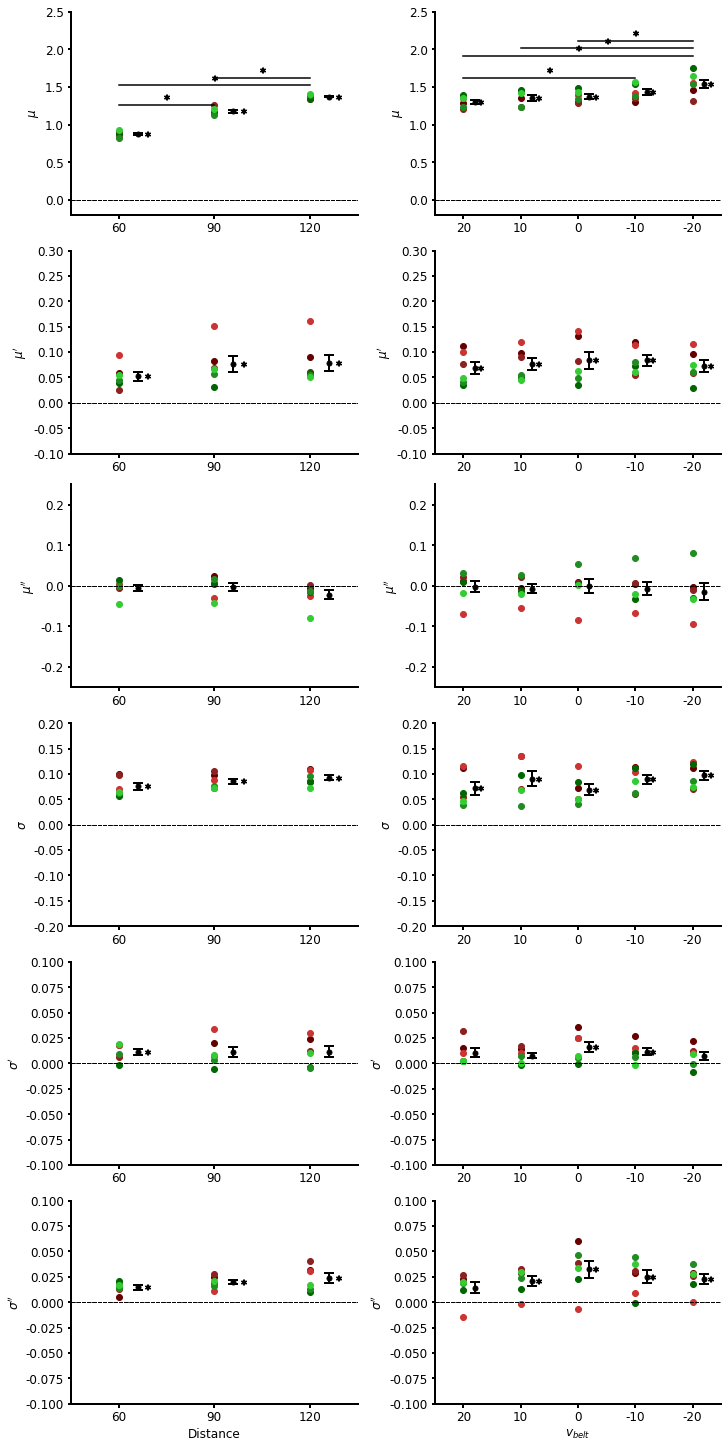

In [ ]:
# ok
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
ylabels = [r'$\mu$', r"$\mu'$", r"$\mu''$", r'$\sigma$', r"$\sigma'$", r"$\sigma''$"]
# ylabels = [r'$\mu$', r"$\mu'/\mu$", r"$\mu''/\mu$", r'$\sigma$', r"$\sigma'/\sigma$", r"$\sigma''/\sigma$"]
ylims = [[-.2, 2.5], [-.1, .3], [-.25, .25], [-.2, .2], [-.1, .1], [-.1, .1], ]



alpha = {}
gamma = {}
alpha_t = {}
gamma_t = {}
alpha_R = {}
gamma_R = {}
lossWald = {}

alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, True, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = True, True, True, True

for animal in animalList:

    alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
        (alpha[animal][cond], gamma[animal][cond], \
        alpha_t[animal][cond], gamma_t[animal][cond], \
        alpha_R[animal][cond], gamma_R[animal][cond]), lossWald[animal][cond] = modelrun_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                    gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                    )
        # ########### normalize p' and p'' by p
        # alpha_t[animal][cond] /= alpha[animal][cond]
        # gamma_t[animal][cond] /= gamma[animal][cond]
        # alpha_R[animal][cond] /= alpha[animal][cond]
        # gamma_R[animal][cond] /= gamma[animal][cond]
        # ###############

    vars = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, ]

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 0].scatter(np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]], color=rat_markers[animal][0], label=animal)
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 1].scatter(np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], color=rat_markers[animal][0], label=animal)
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)
axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')

#mean per condition
for idx, cond in enumerate(["60", "90", "120"]):
    for jdx, var in enumerate([ alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R,]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))
        s, p = stats.ttest_1samp(d, 0)
        if p < .05: axs[jdx, 0].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 0].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

for idx, cond in enumerate(["20", "10", "2", "rev10", "rev20"]):
    for jdx, var in enumerate([ alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R,]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))
        s, p = stats.ttest_1samp(d, 0)
        if p < .05: axs[jdx, 1].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 1].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

test_all_conds_between_themselves(["60", "90", "120"], vars, ax=axs[:, 0])
test_all_conds_between_themselves(["20", "10", "2", "rev10", "rev20"], vars, ax=axs[:, 1])


# trash stats

In [ ]:
def bootstrap_compare_to_zero(sample, alpha=0.05, n_bootstraps=1000):
    """
    Compare a sample to 0 using bootstrap method.

    Parameters:
    -----------
    sample : array-like
        The sample to compare to 0.
    alpha : float, optional
        The significance level. Default is 0.05.
    n_bootstraps : int, optional
        The number of bootstrap samples to generate. Default is 1000.

    Returns:
    --------
    bool
        True if the sample is significantly different from 0 at the specified alpha level, False otherwise.
    """
    sample = np.asarray(sample)
    # Generate bootstrap samples
    bootstraps = np.random.choice(sample, size=(n_bootstraps, len(sample)), replace=True)
    # Compute mean of each bootstrap sample
    bootstraps = np.mean(bootstraps, axis=1)
    # Compute the p-value
    p_value = np.sum(bootstraps <= 0) / n_bootstraps
    # Return True if the p-value is lower than the significance level
    # == the sample is significantly different from 0
    return p_value < alpha
from scipy.stats import norm
sample = norm.rvs(size=100, loc=0, scale=1)
print(bootstrap_compare_to_zero(sample))

def bootstrap_compare_two_samples(sample1, sample2, alpha=0.05, n_bootstraps=1000):
    """
    Compare two samples using bootstrap permutation method.

    Parameters:
    -----------
    sample1 : array-like
        The first sample.
    sample2 : array-like
        The second sample.
    alpha : float, optional
        The significance level. Default is 0.05.
    n_bootstraps : int, optional
        The number of bootstrap samples to generate. Default is 1000.

    Returns:
    --------
    bool
        True if the samples are significantly different from each other at the specified alpha level, False otherwise.
    """
    sample1 = np.asarray(sample1)
    sample2 = np.asarray(sample2)

    # Compute the difference of the means of the two samples
    mean_diff = np.mean(sample1) - np.mean(sample2)

    # Generate bootstrap samples
    bootstraps = np.concatenate((sample1, sample2))
    bootstraps = np.random.choice(bootstraps, size=(n_bootstraps, len(bootstraps)), replace=True)

    # Compute the difference of the means of each bootstrap sample
    bootstraps = np.mean(bootstraps[:, :len(sample1)], axis=1) - np.mean(bootstraps[:, len(sample1):], axis=1)

    # Compute the p-value
    p_value = np.sum(bootstraps <= mean_diff) / n_bootstraps

    # Return True if the p-value is lower than the significance level
    # == the samples are significantly different from each other
    return p_value < alpha


def test_all_conds_between_themselvesBOOT(conds, vars, ax=None):
    """dirty bootstrap to test all conditions against each other"""
    if ax is None: ax = plt.gca()
    for idx, var in enumerate(vars):
        c = 0
        for i, cond1 in enumerate(conds):
            for j, cond2 in enumerate(conds):
                if i >= j:
                    continue
                data1 = [var[animal][cond1] for animal in list(var.keys())]
                data2 = [var[animal][cond2] for animal in list(var.keys())]
                p = bootstrap_compare_two_samples(data1, data2)
                # print(f"{idx} {cond1} vs {cond2}: {p:.3f} {'*' if p < .05 else ''}")

                if p:
                    print(f"{idx} {cond1} vs {cond2}: {p:.3f} {'*' if p < .05 else ''}")
                    y = np.max([np.mean(data1)+ 2*np.std(data1), np.mean(data2)+ 2*np.std(data2)]) + c
                    ax[idx].plot((i, j), (y, y), color='k')
                    ax[idx].scatter((i+j)/2, y+.1, color='k', marker=r'$\ast$')
                    c += 0.1


sample1 = norm.rvs(size=100, loc=0, scale=1)
sample2 = norm.rvs(size=100, loc=0, scale=1)
print(bootstrap_compare_two_samples(sample1, sample2))

False
False


0 60 vs 90: 1.000 
0 60 vs 120: 1.000 
0 90 vs 120: 1.000 
5 60 vs 120: 1.000 
0 20 vs rev10: 1.000 
0 20 vs rev20: 1.000 
0 10 vs rev20: 1.000 
0 2 vs rev20: 1.000 
3 2 vs rev20: 1.000 


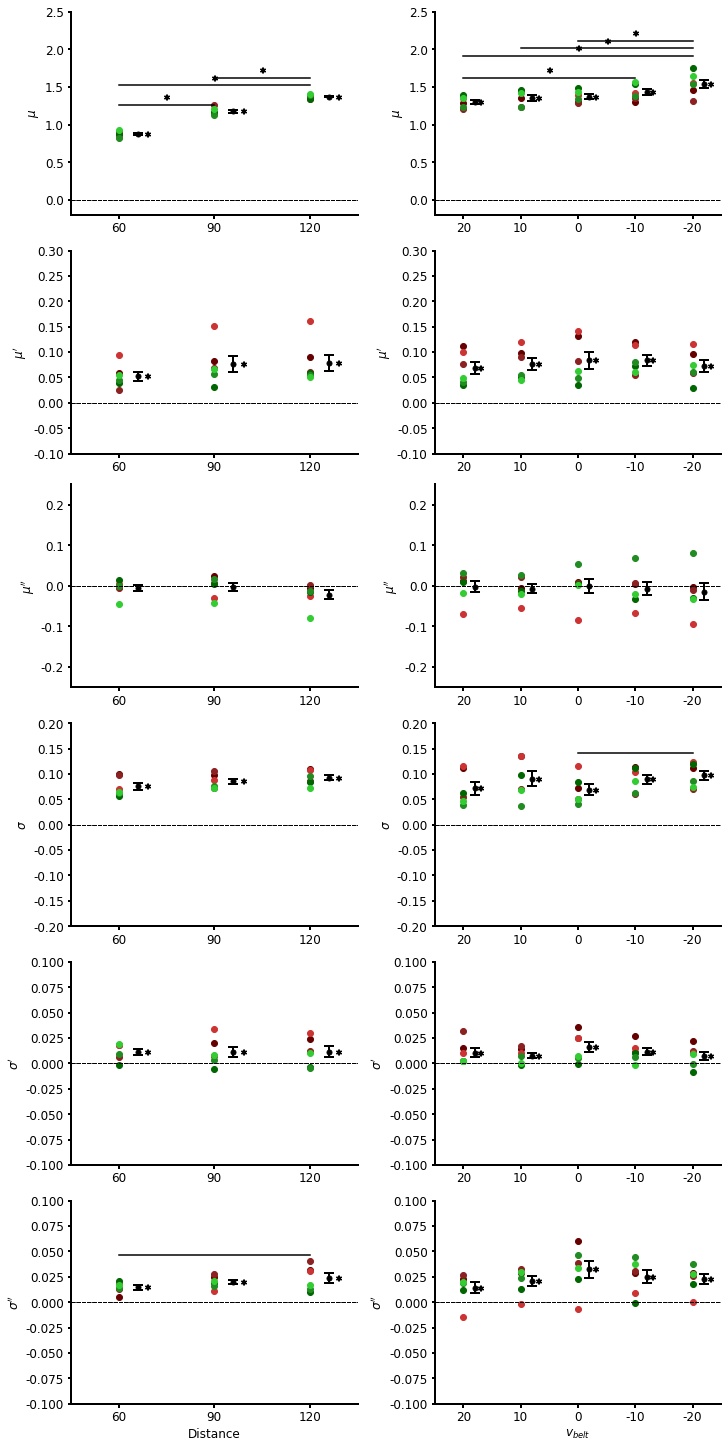

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
ylabels = [r'$\mu$', r"$\mu'$", r"$\mu''$", r'$\sigma$', r"$\sigma'$", r"$\sigma''$"]
# ylabels = [r'$\mu$', r"$\mu'/\mu$", r"$\mu''/\mu$", r'$\sigma$', r"$\sigma'/\sigma$", r"$\sigma''/\sigma$"]
ylims = [[-.2, 2.5], [-.1, .3], [-.25, .25], [-.2, .2], [-.1, .1], [-.1, .1], ]

alpha = {}
gamma = {}
alpha_t = {}
gamma_t = {}
alpha_R = {}
gamma_R = {}
lossWald = {}

alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False

for animal in animalList:

    alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
        (alpha[animal][cond], gamma[animal][cond], \
        alpha_t[animal][cond], gamma_t[animal][cond], \
        alpha_R[animal][cond], gamma_R[animal][cond]), lossWald[animal][cond] = modelrun_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                    gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                    )


    vars = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R, ]

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 0].scatter(np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]], color=rat_markers[animal][0], label=animal)
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        axs[i, 1].scatter(np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], color=rat_markers[animal][0], label=animal)
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)
axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')

#mean per condition
for idx, cond in enumerate(["60", "90", "120"]):
    for jdx, var in enumerate([ alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R,]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))
        p = bootstrap_compare_to_zero(d)
        if p: axs[jdx, 0].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 0].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

for idx, cond in enumerate(["20", "10", "2", "rev10", "rev20"]):
    for jdx, var in enumerate([ alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R,]):
        d = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(d), np.std(d)/np.sqrt(len(d))

        p = bootstrap_compare_to_zero(d)
        if p: axs[jdx, 1].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 1].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

test_all_conds_between_themselvesBOOT(["60", "90", "120"], vars, ax=axs[:, 0])
test_all_conds_between_themselvesBOOT(["20", "10", "2", "rev10", "rev20"], vars, ax=axs[:, 1])


# trash / tests

In [ ]:
# linear scale

###
# NOT SAME NUMBER OF OBSERVATIONS IN EACH CURVE, BUT SAME NORMALIZATION 
###
animal = 'RatM01'
fig, axs = plt.subplots(1, 6, figsize=(30, 5), subplot_kw={'projection': '3d'})
from matplotlib import collections

# step histogram polygon
def polygon(x, y):
    point_list = [(x[0], 0.)]
    for i in range(len(x)-1):
        point_list.append((x[i], y[i]))
        point_list.append((x[i+1], y[i]))
    point_list.append((x[-1], 0.))
    return point_list

def plot_polygon(x, y, z, ax, color='k'):
    for i in range(len(x)-1):
        ax.plot([x[i], x[i+1]], [y, y], [z[i], z[i]], color=color)
        ax.plot([x[i+1], x[i+1]], [y, y], [z[i], z[i+1]], color=color)

for j in range(6):
    x, y = [[] for _ in range(len(meankeys(targetlist)))], [[] for _ in range(len(meankeys(targetlist)))]
    for i, avg in enumerate(meankeys(targetlist)):
        bins = np.linspace(0, exampledata[animal][j][i].max(), int(max(exampledata[animal][j][i])))
        y[i], x[i] = np.histogram(exampledata[animal][j][i], bins=bins, weights=np.ones_like(exampledata[animal][j][i]) / len(exampledata[animal][j][i]))

        y[i] = np.cumsum(y[i])
        y[i] = np.insert(y[i], 0, 0)
        y[i] /= np.max(y[i])
        y[i] = 1-y[i]

        x[i][x[i] < 0] = np.nan
        y[i][x[i] < 0] = np.nan
        x[i][x[i] > 15] = 15
        y[i][x[i] > 15] = np.nan

        
        plot_polygon(x[i], avg, y[i], axs[j], color=rat_markers[animal][0])

        _x = np.linspace(0, 15, 1000)
        _y = np.ones_like(_x)*avg
        _z = 1-Wald_cdf(_x, alpha[animal] + j*alpha_t[animal] + i*alpha_R[animal], 0, gamma[animal] + j*gamma_t[animal] + i*gamma_R[animal])
        # (_alpha, _theta, _gamma), lossWald = wald_fit(exampledata[animal][j][i])
        # _z = 1-Wald_cdf(_x, _alpha, _theta, _gamma)
        axs[j].plot(_x, _y, _z, color=rat_markers[animal][0], alpha=1, linewidth=2, ls='--')

    # polygon = lambda x, y: [(x[0], 0.), *zip(x, y), (x[-1], 0.)]
    verts = [polygon(x[avg], y[avg]) for avg in range(len(meankeys(targetlist)))]
    facecolors = rat_markers[animal][0]
    poly = collections.PolyCollection(verts, facecolors=facecolors, alpha=.75)
    axs[j].set(xlim=(0, 15), ylim=(1, 0), zlim=(0, 1))
    # axs[j].add_collection3d(poly, zs=meankeys(targetlist), zdir='y')
    axs[j].set_xticks([0, 5, 10, 15])
    axs[j].set_xticklabels(['0', '5', '10', '15'])
    axs[j].set_yticks([1, .67, .33, 0])
    axs[j].set_yticklabels(['1', '0.67', '0.33', '0'])
    axs[j].set_zticks([0, .5, 1])
    axs[j].set_zticklabels(['0', '0.5', '1'])
    axs[j].set_title(f'{j*10}-{(j+1)*10} min')
    axs[j].view_init(25, 300)

axs[0].set(xlabel='idle time duration', ylabel=r'Avg reward', zlabel='1-CDF')

RatF00   a: 1.87, a': 0.01, a'': -0.25, || g: 1.59, g': 0.15, g'': 0.25,||| loss: 37.84
RatF01   a: 2.98, a': 0.01, a'': -0.70, || g: 1.49, g': 0.04, g'': 0.43,||| loss: 34.48
RatF02   a: 2.03, a': -0.15, a'': -0.18, || g: 1.43, g': 0.36, g'': 0.24,||| loss: 42.73
RatM00   a: 3.90, a': 0.20, a'': -0.97, || g: 1.53, g': 0.02, g'': 0.12,||| loss: 27.38
RatM01   a: 8.00, a': 0.83, a'': -2.25, || g: 1.52, g': 0.04, g'': 0.01,||| loss: 18.84
RatM02   a: 4.35, a': -0.25, a'': -0.84, || g: 1.40, g': 0.08, g'': 0.10,||| loss: 25.05


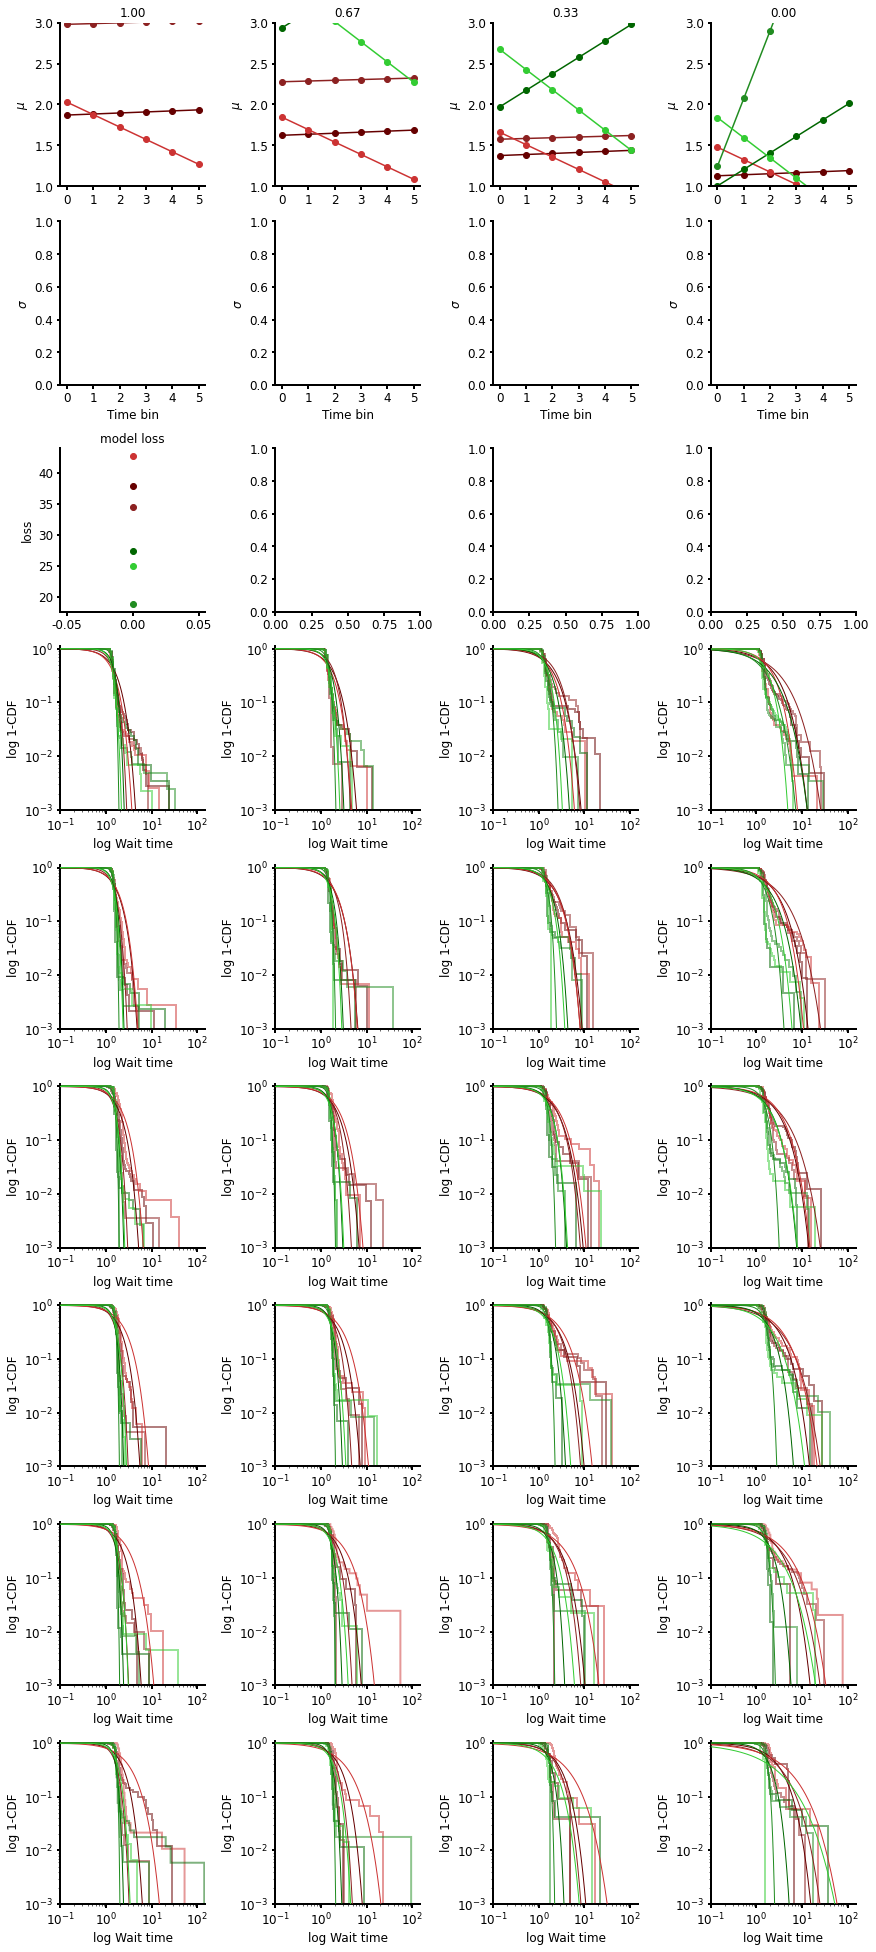

In [ ]:
# example fit all 120 cm session
targetlist = generate_targetList(3)[::-1]
fig, axs = plt.subplots(9, len(meankeys(targetlist)), figsize=(12, 27))
exampledata = prepare_dataR(animalList, dist120)



def _weibull(x, c, loc, scale):
    return (c/scale) * (x/scale)**(c-1) * np.exp(-(x/scale)**c)

def _weibullCDF(x, c, loc, scale):
    return 1 - np.exp(-(x/scale)**c)

def _crit(params, *args, robustness_param=1e-20):
    """negative log likelihood function for Wald distribution"""
    c, loc, scale = params
    x = args
    pdf_vals = _weibull(x, c, loc, scale) + robustness_param
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

def _fit(x, alpha_init=2, theta_init=0, gamma_init=.5):
    """fit Wald distribution"""
    params_init = np.array([alpha_init, theta_init, gamma_init])
    res = scipy.optimize.minimize(_crit, params_init, args=x, bounds=((0, None), (0, 1e-8), (0, None)))
    return res.x, res.fun


mu = {}
sigma = {}
mu_prime = {}
sigma_prime = {}
mu_second = {}
sigma_second = {}
lossWald = {}
loc = {}

def plot_weibull_fitted(waits, p, ax=None, color='k'):
    if ax is None: ax = plt.gca()
    waits = np.asarray(waits)

    bins=np.linspace(0, waits.max(), int(max(waits))*10)
    ydata, xdata, _ = ax.hist(waits, bins=bins,
                    color=color, alpha=.5, zorder=1, 
                    density=True, # weights=np.ones_like(waits) / len(waits),
                    histtype="step", lw=2, 
                    cumulative=-1,
                    )

    x = np.linspace(0.01, 500, 10000)
    c, scale = p
    ax.plot(x, 1-_weibullCDF(x, c=c, scale=scale, loc=0), color=color, lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')


    ax.set_xlim(.1, 150)
    ax.set_ylim(.001, 1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel('log Wait time')
    ax.set_ylabel('log 1-CDF')

    return ax


def crit_weibull(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
    neg_log_lik_val = 0
    N_bins, N_avg = args[1]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg] if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            pdf_vals = _weibull(args[0][bin][avg], c=_mu, loc=0, scale=_sigma)
            # print(pdf_vals)
            ln_pdf_vals = np.log(pdf_vals + robustness_param)
            log_lik_val = ln_pdf_vals.sum()

            n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
            neg_log_lik_val += (-log_lik_val / n)
            # except:
            #     neg_log_lik_val += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return neg_log_lik_val


for animal in animalList:

    (mu[animal], sigma[animal], 
        mu_prime[animal], sigma_prime[animal], 
        mu_second[animal], sigma_second[animal]), lossWald[animal] = modelrun_fit(exampledata[animal], f=crit_weibull)#(0, 0, 0, 0, 0, 0, 0, 0, 0, ), 0

    print(f"{animal}   a: {mu[animal]:.2f}, a': {mu_prime[animal]:.2f}, a'': {mu_second[animal]:.2f}, || g: {sigma[animal]:.2f}, g': {sigma_prime[animal]:.2f}, g'': {sigma_second[animal]:.2f},||| loss: {lossWald[animal]:.2f}")

    x = [0, 1, 2, 3, 4, 5]
    for i, avg in enumerate(meankeys(targetlist)):
        axs[0, i].plot(x, [mu[animal] + (bin*mu_prime[animal]) for bin in x] + i*mu_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
        axs[0, i].set_title(f"{avg:.2f}")
        axs[0, i].set_xticks(x)
        # axs[0, i].set_xlabel('Time bin')
        axs[0, i].set_ylabel(r'$\mu$')
        axs[0, i].set_ylim([1, 3])
        
        axs[1, i].plot(x, [sigma[animal] + (bin*sigma_prime[animal]) for bin in x] + i*sigma_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
        # axs[1, i].set_title(f"{avg:.2f}")
        axs[1, i].set_xticks(x)
        axs[1, i].set_xlabel('Time bin')
        axs[1, i].set_ylabel(r'$\sigma$')
        axs[1, i].set_ylim([0, 1])

    y = lossWald[animal]
    axs[2, 0].plot(0, y, color=rat_markers[animal][0], label=animal, marker='o')
    axs[2, 0].set_title(f"model loss")
    axs[2, 0].set_ylabel(r'loss')

    for j in range(6):
        for i, avg in enumerate(meankeys(targetlist)):
            plot_weibull_fitted(exampledata[animal][j][i], (mu[animal] + j*mu_prime[animal] + i*mu_second[animal], sigma[animal] + j*sigma_prime[animal] + i*sigma_second[animal]), ax=axs[3+j, i], color=rat_markers[animal][0])


In [ ]:
# example fit all 120 cm session
targetlist = generate_targetList(3)[::-1]
fig, axs = plt.subplots(9, len(meankeys(targetlist)), figsize=(12, 27))
exampledata = prepare_dataR(animalList, dist120)


def _levy(x, mu, sigma):
    arg = np.sqrt(sigma/(2*np.pi))
    return np.array(arg * np.exp(-sigma/(2*(x-mu))) / (x-mu)**(3/2), dtype=np.float64)

from scipy.special import erfc
def _levyCDF(x, mu, sigma):
    return erfc(np.sqrt(sigma/(2*(x-mu))))

def _crit(params, *args, robustness_param=1e-20):
    """negative log likelihood function for Wald distribution"""
    mu, sigma = params
    x = args
    pdf_vals = _levy(x, mu, sigma) + robustness_param
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

def _fit(x, alpha_init=0, theta_init=0, gamma_init=.5):
    """fit Wald distribution"""
    params_init = np.array([alpha_init, gamma_init])
    res = scipy.optimize.minimize(_crit, params_init, args=x, bounds=((0, None), (0, None)))
    return res.x, res.fun

mu = {}
sigma = {}
mu_prime = {}
sigma_prime = {}
mu_second = {}
sigma_second = {}
lossWald = {}
loc = {}

def plot_weibull_fitted(waits, p, ax=None, color='k'):
    if ax is None: ax = plt.gca()
    waits = np.asarray(waits)

    bins=np.linspace(0, waits.max(), int(max(waits))*10)
    ydata, xdata, _ = ax.hist(waits, bins=bins,
                    color=color, alpha=.5, zorder=1, 
                    density=True, # weights=np.ones_like(waits) / len(waits),
                    histtype="step", lw=2, 
                    cumulative=-1,
                    )

    x = np.linspace(0.01, 500, 10000)
    mu, sigma = p
    ax.plot(x, 1-_levyCDF(x, mu, sigma), color=color, lw=1, zorder=4, )


    ax.set_xlim(.1, 150)
    ax.set_ylim(.001, 1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel('log Wait time')
    ax.set_ylabel('log 1-CDF')

    return ax

#params = a, t, g, a', t', g', a'', t'', g''
def modelrun_fit(data, init=[1, 1, 1, 1, 1, 1], f=modelrun_crit, N_bins=6, N_avg=4, alpha_t_fixed=False, gamma_t_fixed=False, alpha_R_fixed=False, gamma_R_fixed=False, ):
    params_init = np.array(init)
    alpha_t_bounds = (None, None) if not alpha_t_fixed else (0, 1e-8)
    gamma_t_bounds = (None, None) if not gamma_t_fixed else (0, 1e-8)
    alpha_R_bounds = (None, None) if not alpha_R_fixed else (0, 1e-8)
    gamma_R_bounds = (None, None) if not gamma_R_fixed else (0, 1e-8)

    res = scipy.optimize.minimize(f, params_init, args=(data, [N_bins, N_avg]), 
                                        bounds=((0, None), (0, None), 
                                            alpha_t_bounds, gamma_t_bounds, 
                                            alpha_R_bounds, gamma_R_bounds))
    return res.x, res.fun


def crit_levy(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second = params
    neg_log_lik_val = 0
    N_bins, N_avg = args[1]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_second
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_second

    print(MU, SIGMA)
    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg] if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            pdf_vals = _levy(args[0][bin][avg], _mu, _sigma)
            print(pdf_vals, params, _mu, _sigma)
            ln_pdf_vals = np.log(pdf_vals + robustness_param)
            log_lik_val = ln_pdf_vals.sum()

            n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
            neg_log_lik_val += (-log_lik_val / n)
            # except:
            #     neg_log_lik_val += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return neg_log_lik_val


for animal in animalList:
    if animal == 'RatM01':

        (mu[animal], sigma[animal], 
            mu_prime[animal], sigma_prime[animal], 
            mu_second[animal], sigma_second[animal]), lossWald[animal] = modelrun_fit(exampledata[animal], f=crit_levy, init=[0, 0, 0, 0, 0, 0])

        print(f"{animal}   a: {mu[animal]:.2f}, a': {mu_prime[animal]:.2f}, a'': {mu_second[animal]:.2f}, || g: {sigma[animal]:.2f}, g': {sigma_prime[animal]:.2f}, g'': {sigma_second[animal]:.2f},||| loss: {lossWald[animal]:.2f}")

        x = [0, 1, 2, 3, 4, 5]
        for i, avg in enumerate(meankeys(targetlist)):
            axs[0, i].plot(x, [mu[animal] + (bin*mu_prime[animal]) for bin in x] + i*mu_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
            axs[0, i].set_title(f"{avg:.2f}")
            axs[0, i].set_xticks(x)
            # axs[0, i].set_xlabel('Time bin')
            axs[0, i].set_ylabel(r'$\mu$')
            axs[0, i].set_ylim([1, 3])
            
            axs[1, i].plot(x, [sigma[animal] + (bin*sigma_prime[animal]) for bin in x] + i*sigma_second[animal], color=rat_markers[animal][0], label=animal, marker='o')
            # axs[1, i].set_title(f"{avg:.2f}")
            axs[1, i].set_xticks(x)
            axs[1, i].set_xlabel('Time bin')
            axs[1, i].set_ylabel(r'$\sigma$')
            axs[1, i].set_ylim([0, 1])

        y = lossWald[animal]
        axs[2, 0].plot(0, y, color=rat_markers[animal][0], label=animal, marker='o')
        axs[2, 0].set_title(f"model loss")
        axs[2, 0].set_ylabel(r'loss')

        for j in range(6):
            for i, avg in enumerate(meankeys(targetlist)):
                plot_weibull_fitted(exampledata[animal][j][i], (mu[animal] + j*mu_prime[animal] + i*mu_second[animal], sigma[animal] + j*sigma_prime[animal] + i*sigma_second[animal]), ax=axs[3+j, i], color=rat_markers[animal][0])


In [ ]:

def _crit(params, *args, robustness_param=1e-20):
    """negative log likelihood function for Wald distribution"""
    mu, sigma = params
    x = args[0]
    pdf_vals = _levy(x, mu, sigma) + robustness_param
    # plt.plot(np.arange(len(pdf_vals)), pdf_vals)
    # plt.show()
    # print(pdf_vals, params, mu, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

def _fit(x, alpha_init=0, theta_init=0, gamma_init=.5):
    """fit Wald distribution"""
    params_init = np.array([alpha_init, gamma_init])
    res = scipy.optimize.minimize(_crit, params_init, args=x, bounds=((0, 10), (0, 10)))
    return res.x, res.fun
_fit(exampledata['RatM01'][0][0])

(array([0. , 0.5]), nan)

<AxesSubplot:xlabel='log Wait time', ylabel='log 1-CDF'>

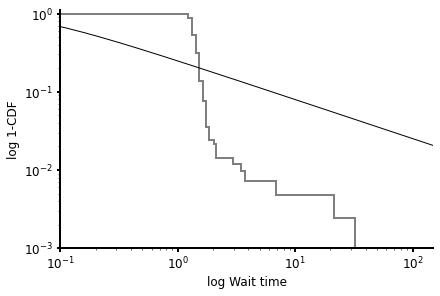

In [ ]:


def plot_weibull_fitted(waits, p, ax=None, color='k'):
    if ax is None: ax = plt.gca()
    waits = np.asarray(waits)

    bins=np.linspace(0, waits.max(), int(max(waits))*10)
    ydata, xdata, _ = ax.hist(waits, bins=bins,
                    color=color, alpha=.5, zorder=1, 
                    density=True, # weights=np.ones_like(waits) / len(waits),
                    histtype="step", lw=2, 
                    cumulative=-1,
                    )

    x = np.linspace(0.01, 500, 10000)
    mu, sigma = p
    ax.plot(x, 1-_levyCDF(x, mu, sigma), color=color, lw=1, zorder=4, )


    ax.set_xlim(.1, 150)
    ax.set_ylim(.001, 1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel('log Wait time')
    ax.set_ylabel('log 1-CDF')

    return ax

plot_weibull_fitted(exampledata['RatM01'][0][0], (0, .1))

In [ ]:

def _levy(x, mu, sigma):
    arg = np.sqrt(sigma/(2*np.pi))
    return np.array(arg * np.exp(-sigma/(2*(x-mu))) / (x-mu)**(3/2), dtype=np.float64)


def plot_interactiveLevy(alpha=1, gamma=2, t_0=0):
    """interactive plot of Wald pdf"""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    x = np.linspace(0.01, 40, 4000)
    axs[0].plot(x, _levy(x, 1,  2), 'k-', label='Default')
    axs[0].plot(x, _levy(x, 2.5,  2), 'c', label='increased alpha')
    axs[0].plot(x, _levy(x, 1,  3.8), 'r-', label='increased gamma')
    # axs[0].plot(np.linspace(0.81, 4, 1000), _levy(np.linspace(0.81, 4, 1000), 1, .8, 2), 'g-', label='increased theta')
    axs[0].set_ylabel('PDF')
    axs[0].set_xlabel('t')
    axs[0].set_xlim(0, 4)
    axs[0].set_ylim(0, 4)
    axs[0].legend()

    pdf = _levy(x, alpha, gamma)
    cdf = 1-_levyCDF(x, alpha, gamma)
    axs[1].plot(x, pdf)
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('pdf')
    axs[1].set_title('pdf')
    axs[2].plot(x, cdf)
    axs[2].set_xscale('log')
    axs[2].set_yscale('log')
    axs[2].set_xlabel('log t')
    axs[2].set_ylabel('log 1-cdf')
    axs[2].set_title('log 1-cdf')

    axs[1].set_xlim(0, 4)
    axs[1].set_ylim(0, 4)
    axs[2].set_xlim(0.01, 100)
    axs[2].set_ylim(0.01, 1.1)
    return

from ipywidgets import interact
pl = interact(plot_interactiveLevy, alpha=(0, 5, 0.1), gamma=(0, 5, 0.1), t_0=(0, 3, 0.1));

interactive(children=(FloatSlider(value=1.0, description='alpha', max=5.0), FloatSlider(value=2.0, description…

In [ ]:
def plot_cauchy_fitted2(waits, p, ax=None, color='k'):
    if ax is None: ax = plt.gca()
    waits = np.asarray(waits)

    bins=np.linspace(0, waits.max(), int(max(waits))*10)
    ydata, xdata, _ = ax.hist(waits, 
                    bins=bins,
                    color=color, alpha=.5, zorder=1, 
                    density=True, # weights=np.ones_like(waits) / len(waits),
                    histtype="step", lw=2, 
                    cumulative=-1,
                    # cumulative=1
                    )

    x = np.linspace(0.01, 500, 10000)
    # (alpha, theta, gamma) = p
    loc, scale = p
    # ax.plot(x, cauchy.pdf(x, scale=scale, loc=loc), color=color, lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')

    # from scipy.stats import truncnorm
    # a, b, loc, scale = truncnorm.fit(waits, fa=min(waits), fb=max(waits))
    # print(a, b, loc, scale)
    # ax.plot(x, truncnorm.pdf(x, a=a, b=b, loc=loc, scale=scale), color='r', lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')

    # from scipy.stats import gamma
    # a, loc, scale = gamma.fit(waits)
    # print(a, loc, scale)
    # ax.plot(x, gamma.pdf(x, a=a, loc=loc, scale=scale), color='r', lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')

    # from scipy.stats import invweibull as WEIBULL
    # c, loc, scale = WEIBULL.fit(waits)
    # print(c, loc, scale)
    # ax.plot(x, WEIBULL.sf(x, c=c, loc=loc, scale=scale), color='r', lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')


    def _weibull(x, c, loc, scale):
        return (c/scale) * (x/scale)**(c-1) * np.exp(-(x/scale)**c)

    def _weibullCDF(x, c, loc, scale):
        return 1 - np.exp(-(x/scale)**c)

    def _crit(params, *args, robustness_param=1e-20):
        """negative log likelihood function for Wald distribution"""
        c, loc, scale = params
        x = args
        pdf_vals = _weibull(x, c, loc, scale) + robustness_param
        ln_pdf_vals = np.log(pdf_vals)
        log_lik_val = ln_pdf_vals.sum()
        neg_log_lik_val = -log_lik_val
        return neg_log_lik_val

    def _fit(x, alpha_init=2, theta_init=0, gamma_init=.5):
        """fit Wald distribution"""
        params_init = np.array([alpha_init, theta_init, gamma_init])
        res = scipy.optimize.minimize(_crit, params_init, args=x, bounds=((0, None), (0, 1e-8), (0, None)))
        return res.x, res.fun

    (c, loc, scale), _ = _fit(waits)
    print(c, loc, scale)
    ax.plot(x, 1-_weibullCDF(x, c=c, loc=loc, scale=scale), color='g', lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')



    # from scipy.stats import expon

    # loc, scale = expon.fit(waits)
    # print(loc, scale)
    # ax.plot(x, expon.pdf(x, loc=loc, scale=scale), color='r', lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')

    # ax.plot(x, expon.pdf(x, loc=1.2, scale=.2), color='g', lw=1, zorder=4, label=f'mean={scale:.2f}, s={s:.2f}')

    # print(min(waits), max(waits))

    # ax.plot(x, 1-Wald_cdf(x, alpha, theta, gamma), color=color, lw=1, zorder=4, label=f'mean={gamma:.2f}, A={alpha:.2f}, t0={theta:.2f}')

    ax.set_xlim(.1, 5)
    ax.set_ylim(.01, 1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel('log Wait time')
    ax.set_ylabel('log 1-CDF')

    return ax
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_cauchy_fitted2(exampledata['RatM01'][1][0], (mu['RatM01'], sigma['RatM01']), ax=ax, color='k')

In [ ]:
def add_panel_caption(axes: tuple, offsetX: tuple, offsetY: tuple, **kwargs):
    """
    This function adds letter captions (a,b,c,d) to Axes in axes
    at top left, with the specified offset, in RELATIVE figure coordinates
    """
    assert len(axes)==len(offsetX)==len(offsetY), 'Bad input!'
    
    fig=axes[0].get_figure()
    fbox=fig.bbox
    for ax,dx,dy,s in zip(axes,offsetX,offsetY,string.ascii_uppercase):
        axbox=ax.get_window_extent()
    
        ax.text(x=(axbox.x0/fbox.xmax)-abs(dx), y=(axbox.y1/fbox.ymax)+abs(dy),
                s=s,fontweight='extra bold', fontsize=10, ha='left', va='center',
               transform=fig.transFigure,**kwargs)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
import string

In [ ]:
x = scipy.stats.norm.rvs(size=100)
y = scipy.stats.norm.rvs(size=100)+1
p = Permtest(x, y)

# Permutation tests

In [ ]:
def exact_mc_perm_test(x, y, nmc=10000):
    assert len(x) == len(y), 'x and y must have the same length'  # needed?
    n = len(x)
    k = 0
    diff = np.abs(np.mean(x) - np.mean(y))
    z = np.concatenate([x, y])
    for j in range(nmc):
        np.random.shuffle(z)
        k += diff <= np.abs(np.mean(z[:n]) - np.mean(z[n:]))
    p_value = k / nmc
    return p_value

x = np.array([12.6, 11.4, 13.2, 11.2, 9.4, 12.0])
y = np.array([16.4, 14.1, 13.4, 15.4, 14.0, 11.3])
x = np.array([1, 1, 1, 1, 1, 1 ])
z = np.array([0, 0, 0, 0, 0, 0, ])
exact_mc_perm_test(x, z)

def test_all_conds_between_themselves(conds, vars, ax=None):
    """dirty stats to test all conditions against each other"""
    if ax is None: ax = plt.gca()
    for idx, var in enumerate(vars):
        c = 0
        for i, cond1 in enumerate(conds):
            for j, cond2 in enumerate(conds):
                if i >= j:
                    continue
                data1 = [var[animal][cond1] for animal in list(var.keys())]
                data2 = [var[animal][cond2] for animal in list(var.keys())]
                p = exact_mc_perm_test(data1, data2)
                # print(f"{idx} {cond1} vs {cond2}: {p:.3f} {'*' if p < .05 else ''}")

                if p < .05:
                    print(f"{idx} {cond1} vs {cond2}: {p:.3f} {'*' if p < .05 else ''}")
                    y = np.max([np.mean(data1)+ 2*np.std(data1), np.mean(data2)+ 2*np.std(data2)]) + c
                    ax[idx].plot((i, j), (y, y), color='k')
                    ax[idx].scatter((i+j)/2, y+.1, color='k', marker=r'$\ast$')
                    c += 0.1

3 2 vs rev20: 0.038 *


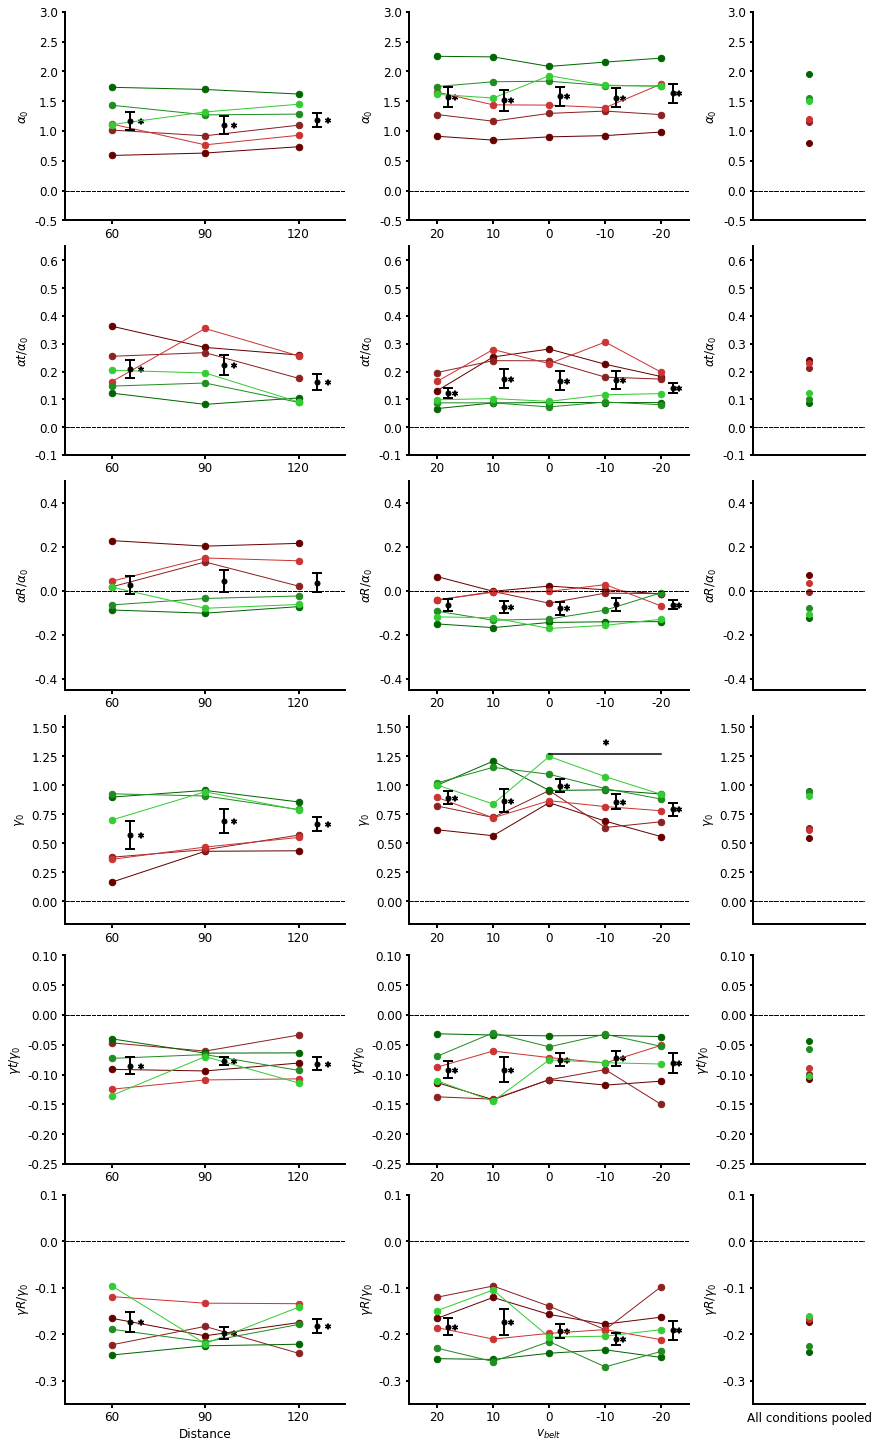

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(12, 20), gridspec_kw={'width_ratios': [5, 5, 2]})

ylabels = [r'$\alpha_0$', r"$\alpha t$", r"$\alpha R$", r'$\gamma_0$', r"$\gamma t$", r"$\gamma R$"]
ylabels = [r'$\alpha_0$', r"$\alpha t/\alpha_0$", r"$\alpha R/\alpha_0$", r'$\gamma_0$', r"$\gamma t/\gamma_0$", r"$\gamma R/\gamma_0$"]
ylims = [[-.5, 3], [-.1, .65], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1]]

alpha, gamma, alpha_t, gamma_t, alpha_R, gamma_R, lossWald = {}, {}, {}, {}, {}, {}, {}
alphaPool, gammaPool, alpha_tPool, gamma_tPool, alpha_RPool, gamma_RPool, lossWaldPool= {}, {}, {}, {}, {}, {}, {}

alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, True, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, True, False
# alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = True, True, True, True

for animal in animalList:
    alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    alpha_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    gamma_R[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
    lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

    (alphaPool[animal], theta, gammaPool[animal], 
        alpha_tPool[animal], thetaprime, gamma_tPool[animal], 
        alpha_RPool[animal], thetasecond, gamma_RPool[animal]), lossWaldPool[animal] = modelwald_fit(dataAll[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                    gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                    )
    # alpha_tPool[animal] /= alphaPool[animal]
    # gamma_tPool[animal] /= gammaPool[animal]
    # alpha_RPool[animal] /= alphaPool[animal]
    # gamma_RPool[animal] /= gammaPool[animal]

    for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60, data90, data120, data20, data10, data2, datarev10, datarev20]):
        (alpha[animal][cond], theta, gamma[animal][cond], \
        alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
        alpha_R[animal][cond], thetasecond, gamma_R[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], alpha_t_fixed=alpha_t_fixed, 
                                                                                                                                    gamma_t_fixed=gamma_t_fixed, 
                                                                                                                                    alpha_R_fixed=alpha_R_fixed, 
                                                                                                                                    gamma_R_fixed=gamma_R_fixed, 
                                                                                                                                    )
        ############ normalize p t and p R by p_0
        # alpha_t[animal][cond] /= alpha[animal][cond]
        # gamma_t[animal][cond] /= gamma[animal][cond]
        # alpha_R[animal][cond] /= alpha[animal][cond]
        # gamma_R[animal][cond] /= gamma[animal][cond]
        ################

    vars = [alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]
    varsPool = [alphaPool, alpha_tPool, alpha_RPool, gammaPool, gamma_tPool, gamma_RPool]

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        x, y = np.arange(3), [var[animal]["60"], var[animal]["90"], var[animal]["120"]]
        axs[i, 0].plot(x, y, color=rat_markers[animal][0], label=animal, marker='o', markersize=6.5, lw=1)
        # gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        # axs[i, 0].plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color=rat_markers[animal][0], lw=2 if p_value < .05 else .5)
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(3))
        axs[i, 0].set_xticklabels(["60", "90", "120"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 2.5)
        axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(vars, ylabels, ylims)):
        x, y = np.arange(5), [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 1].plot(x, y, color=rat_markers[animal][0], label=animal, marker='o', markersize=6.5, lw=1)
        # gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        # axs[i, 1].plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color=rat_markers[animal][0], lw=2 if p_value < .05 else .5)
        axs[i, 1].set_title(f"")
        axs[i, 1].set_xticks(np.arange(5))
        axs[i, 1].set_xticklabels(["20", "10", "0", "-10", "-20"])
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_xlim(-.5, 4.5)
        axs[i, 1].set_ylim(ylim)
        axs[i, 1].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsPool, ylabels, ylims)):
        x, y = 0, var[animal]
        axs[i, 2].scatter(x, y, color=rat_markers[animal][0])
        axs[i, 2].set_title(f"")
        axs[i, 2].set_xticks([])
        axs[i, 2].set_ylabel(ylabel)
        axs[i, 2].set_xlim(-.5, .5)
        axs[i, 2].set_ylim(ylim)
        axs[i, 2].axhline(0, color='black', linestyle='--', linewidth=1)


axs[i, 0].set_xlabel("Distance")
axs[i, 1].set_xlabel(r'$v_{belt}$')
axs[i, 2].set_xlabel("All conditions pooled")

#mean per condition
for idx, cond in enumerate(["60", "90", "120"]):
    for jdx, var in enumerate([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]):
        data = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(data), np.std(data)/np.sqrt(len(data))
        p_val = exact_mc_perm_test(data, np.zeros(len(data)))
        if p_val < .05: 
            axs[jdx, 0].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 0].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

for idx, cond in enumerate(["20", "10", "2", "rev10", "rev20"]):
    for jdx, var in enumerate([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]):
        data = [var[animal][cond] for animal in animalList]
        mean, std = np.mean(data), np.std(data)/np.sqrt(len(data))
        p_val = exact_mc_perm_test(data, np.zeros(len(data)))
        if p_val < .05: 
            axs[jdx, 1].scatter(idx+.3, mean, color='k', marker=r'$\ast$')
        axs[jdx, 1].errorbar(idx+.2, mean, yerr=std, color='black', marker='o', markersize=5, capsize=5, capthick=2, linewidth=2)

test_all_conds_between_themselves(["60", "90", "120"], vars, ax=axs[:, 0])
test_all_conds_between_themselves(["20", "10", "2", "rev10", "rev20"], vars, ax=axs[:, 1])

# pickle.dump([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R], open("picklejar/main_fitting_results.p", "wb"))


all vs ++++: (1 sample t-tests)
1 vs. (False, False, False, False): 1.000 
1 vs. (False, False, True, False): 0.003 *
1 vs. (False, True, False, False): 0.003 *
1 vs. (True, False, False, False): 0.002 *
1 vs. (False, False, False, True): 0.002 *
1 vs. (True, True, True, True): 0.002 *

comparisons: (2 sample t-tests)
(False, False, True, False) vs (False, True, False, False): 0.015 *
(False, False, True, False) vs (True, False, False, False): 0.002 *
(False, False, True, False) vs (False, False, False, True): 0.001 *
(False, False, True, False) vs (True, True, True, True): 0.003 *
(False, True, False, False) vs (True, False, False, False): 0.036 *
(False, True, False, False) vs (False, False, False, True): 0.043 *
(False, True, False, False) vs (True, True, True, True): 0.002 *
(True, False, False, False) vs (False, False, False, True): 0.719 
(True, False, False, False) vs (True, True, True, True): 0.002 *
(False, False, False, True) vs (True, True, True, True): 0.002 *


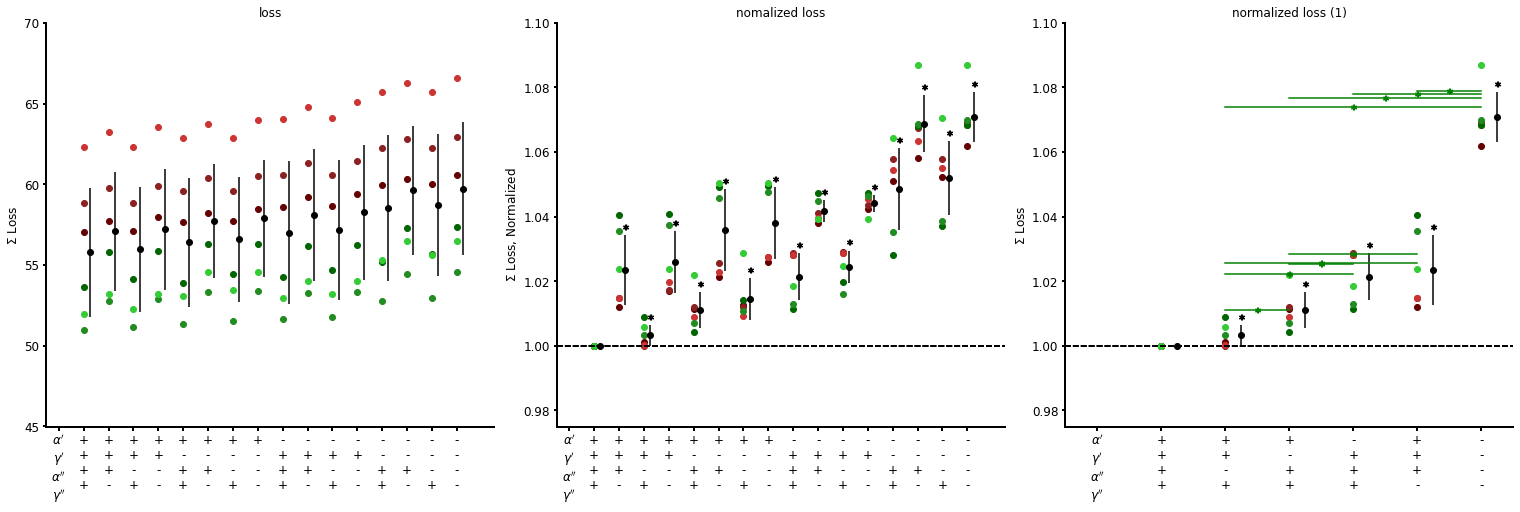

In [ ]:
def test_all_keys_between_themselves(losses, keys, ax=None):
    """dirty stats to test all conditions against each other, but with keys"""
    if ax is None: ax = plt.gca()
    c = 0
    for i, key1 in enumerate(keys):
        for j, key2 in enumerate(keys):
            if i >= j:
                continue
            data1 = [losses[animal][key1]/losses[animal][False, False, False, False] for animal in list(losses.keys())]
            data2 = [losses[animal][key2]/losses[animal][False, False, False, False] for animal in list(losses.keys())]
            p = exact_mc_perm_test(data1, data2)
            print(f"{key1} vs {key2}: {p:.3f} {'*' if p < .05 else ''}")

            if p < .05:
                y = np.max([np.mean(data1), np.mean(data2)]) + c
                ax.plot((i+2, j+2), (y, y), color='g')
                ax.scatter((i+j+4)/2, y, color='g', marker=r'$\ast$')
                c += 0.001
                


targetlist = generate_targetList(seq_len=4)[::-1]
fig, axs = plt.subplots(1, 3, figsize=(21, 7))


losses = {}
the_keys_i_want = [(False, False, False, False), 
                    (True, False, False, False), 
                    (False, True, False, False), 
                    (False, False, True, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

the_keys_i_want = [(False, False, False, False), 
                    (False, False, True, False), 
                    (False, True, False, False), 
                    (True, False, False, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

for animal in animalList:
    losses[animal] = {}
    for alpha_t_fixed in [False, True]:
        for gamma_t_fixed in [False, True]:
            for alpha_R_fixed in [False, True]:
                for gamma_R_fixed in [False, True]:
                    loss = modelwald_fit(dataAll[animal], 
                                        alpha_t_fixed=alpha_t_fixed, 
                                        gamma_t_fixed=gamma_t_fixed, 
                                        alpha_R_fixed=alpha_R_fixed, 
                                        gamma_R_fixed=gamma_R_fixed)[1]

                    losses[animal][(alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed)] = loss

    axs[0].scatter(np.arange(16), losses[animal].values(), color=rat_markers[animal][0], label=animal)
    axs[0].set_title(f"loss")
    axs[0].set_ylabel(r'$\Sigma$ Loss')
    axs[0].set_xticks(np.arange(-1, 16))
    axs[0].set_xticklabels(dict_to_xticklabels(losses[animal]))
    axs[0].set_ylim([45, 70])
    axs[0].set_xlim([-1.5, 16.5])

    axs[1].scatter(np.arange(16), list(losses[animal].values())/losses[animal][False, False, False, False], color=rat_markers[animal][0], label=animal)
    axs[1].set_title(f"nomalized loss")
    axs[1].set_ylabel(r'$\Sigma$ Loss, Normalized')
    axs[1].set_xticks(np.arange(-1, 16))
    axs[1].set_xticklabels(dict_to_xticklabels(losses[animal]))
    axs[1].set_ylim([.975, 1.1])
    axs[1].set_xlim([-1.5, 16.5])
    axs[1].axhline(1, color='k', linestyle='--')

    for i, key in enumerate(the_keys_i_want):
        axs[2].scatter(i+1, losses[animal][key]/losses[animal][False, False, False, False], color=rat_markers[animal][0], label=animal)
    axs[2].set_title(f"normalized loss (1)")
    axs[2].set_ylabel(r'$\Sigma$ Loss')
    axs[2].set_xticks(np.arange(7))
    axs[2].set_xticklabels(dict_to_xticklabels({k:losses[animal][k] for k in the_keys_i_want}))
    axs[2].set_ylim([.975, 1.1])
    axs[2].set_xlim([-.5, 6.5])
    axs[2].axhline(1, color='k', linestyle='--')

# average by key
means = [np.mean([losses[animal][key] for animal in animalList]) for key in losses[animal].keys()]
yerr = [np.std([losses[animal][key] for animal in animalList]) for key in losses[animal].keys()]
axs[0].errorbar(np.arange(16)+.25, means, yerr=yerr, color='k', label='Mean', marker='o', fmt=' ')

means_norm = [np.mean([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in losses[animal].keys()]
yerr_norm = [np.std([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in losses[animal].keys()]
axs[1].errorbar(np.arange(16)+.25, means_norm, yerr=yerr_norm, color='k', label='Mean', marker='o', fmt=' ')

means_norm_select = [np.mean([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in the_keys_i_want]
yerr_norm_select = [np.std([losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]) for key in the_keys_i_want]
axs[2].errorbar(np.arange(len(the_keys_i_want))+1.25, means_norm_select, yerr=yerr_norm_select, color='k', label='Mean', marker='o', fmt=' ')


for idx, key in enumerate(losses[animal].keys()):
    data = [losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]
    p = exact_mc_perm_test(data, np.ones(len(data)))
    if p < .05: axs[1].scatter(idx+.25, np.mean(data) + np.std(data) + 0.0025, color='k', marker=r'$\ast$')

print("all vs ++++: (resampling)")
for idx, key in enumerate(the_keys_i_want):
    data = [losses[animal][key]/losses[animal][False, False, False, False] for animal in animalList]
    p = exact_mc_perm_test(data, np.ones(len(data)))
    if p < .05: axs[2].scatter(idx+1.25, np.mean(data) + np.std(data) + 0.0025, color='k', marker=r'$\ast$')
    print(f"1 vs. {key}: {p:.3f} {'*' if p < .05 else ''}")
print()
print("comparisons: (resampling)")
test_all_keys_between_themselves(losses, the_keys_i_want[1:], axs[2])



Text(0, 0.5, 'Max. Pos. (cm)')

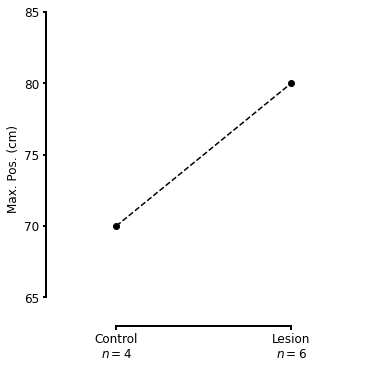

In [ ]:
# try to do that 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 1], [70, 80], color='k', marker='o', linestyle='--')


ax.set_xlim([-.4,1.4])
ax.set_ylim([63,85])
ax.spines['left'].set_bounds(65,85)
ax.spines['bottom'].set_bounds(0,1)
ax.set_yticks(np.arange(65,86,5))
ax.set_xticks([0,1])
ax.set_xticklabels([f'Control\n$n={4}$',f'Lesion\n$n={6}$'])
ax.set_ylabel('Max. Pos. (cm)')



In [ ]:
import multiprocessing

def func(animal, cond, iter, N_OBS, ALPHA, GAMMA, N_bins, N_avg, fit_dicts, connection):
    sample = np.zeros((N_bins, N_avg)).tolist()
    for bin in range(0, N_bins):
        for avg in range(0, N_avg):
            sample[bin][avg] = np.asarray(genWaldSamples(N_OBS[bin, avg], ALPHA[bin, avg], GAMMA[bin, avg]))

    alpha_t_fixed, gamma_t_fixed, alpha_R_fixed, gamma_R_fixed = False, False, False, False
    alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = fit_dicts
    (alpha_fit[animal][cond][iter], theta_fit, gamma_fit[animal][cond][iter], \
                    alpha_t_fit[animal][cond][iter], theta_prime_fit, gamma_t_fit[animal][cond][iter], \
                        alpha_R_fit[animal][cond][iter], theta_second_fit, gamma_R_fit[animal][cond][iter]), loss = modelwald_fit(sample, 
                                                                                                                        alpha_t_fixed=alpha_t_fixed, 
                                                                                                                        gamma_t_fixed=gamma_t_fixed, 
                                                                                                                        alpha_R_fixed=alpha_R_fixed, 
                                                                                                                        gamma_R_fixed=gamma_R_fixed)
    print(alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit)
    fit_dicts = [alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit]
    connection.send(fit_dicts)


def main(fit_dicts, animal, cond, N_OBS, ALPHA, GAMMA, iters=100, N_bins=6, N_avg=4):
    # alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit = {}, {}, {}, {}, {}, {}
    # for animal in animalList:
        # alpha_fit[animal], gamma_fit[animal], alpha_t_fit[animal], gamma_t_fit[animal], alpha_R_fit[animal], gamma_R_fit[animal] = {}, {}, {}, {}, {}, {}
        # for cond in ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]:
            # alpha_fit[animal][cond] = np.zeros((iters))
            # gamma_fit[animal][cond] = np.zeros((iters))
            # alpha_t_fit[animal][cond] = np.zeros((iters))
            # gamma_t_fit[animal][cond] = np.zeros((iters))
            # alpha_R_fit[animal][cond] = np.zeros((iters))
            # gamma_R_fit[animal][cond] = np.zeros((iters))
            
    # fit_dicts = [alpha_fit, gamma_fit, alpha_t_fit, gamma_t_fit, alpha_R_fit, gamma_R_fit]

    for iter in range(0, iters):
        recv_end, send_end = multiprocessing.Pipe(False)
        p = multiprocessing.Process(target=func, args=(animal, cond, iter, N_OBS, ALPHA, GAMMA, N_bins, N_avg, fit_dicts, send_end))
        p.start()
        p.join()
        fit_dicts = recv_end.recv()

    return fit_dicts


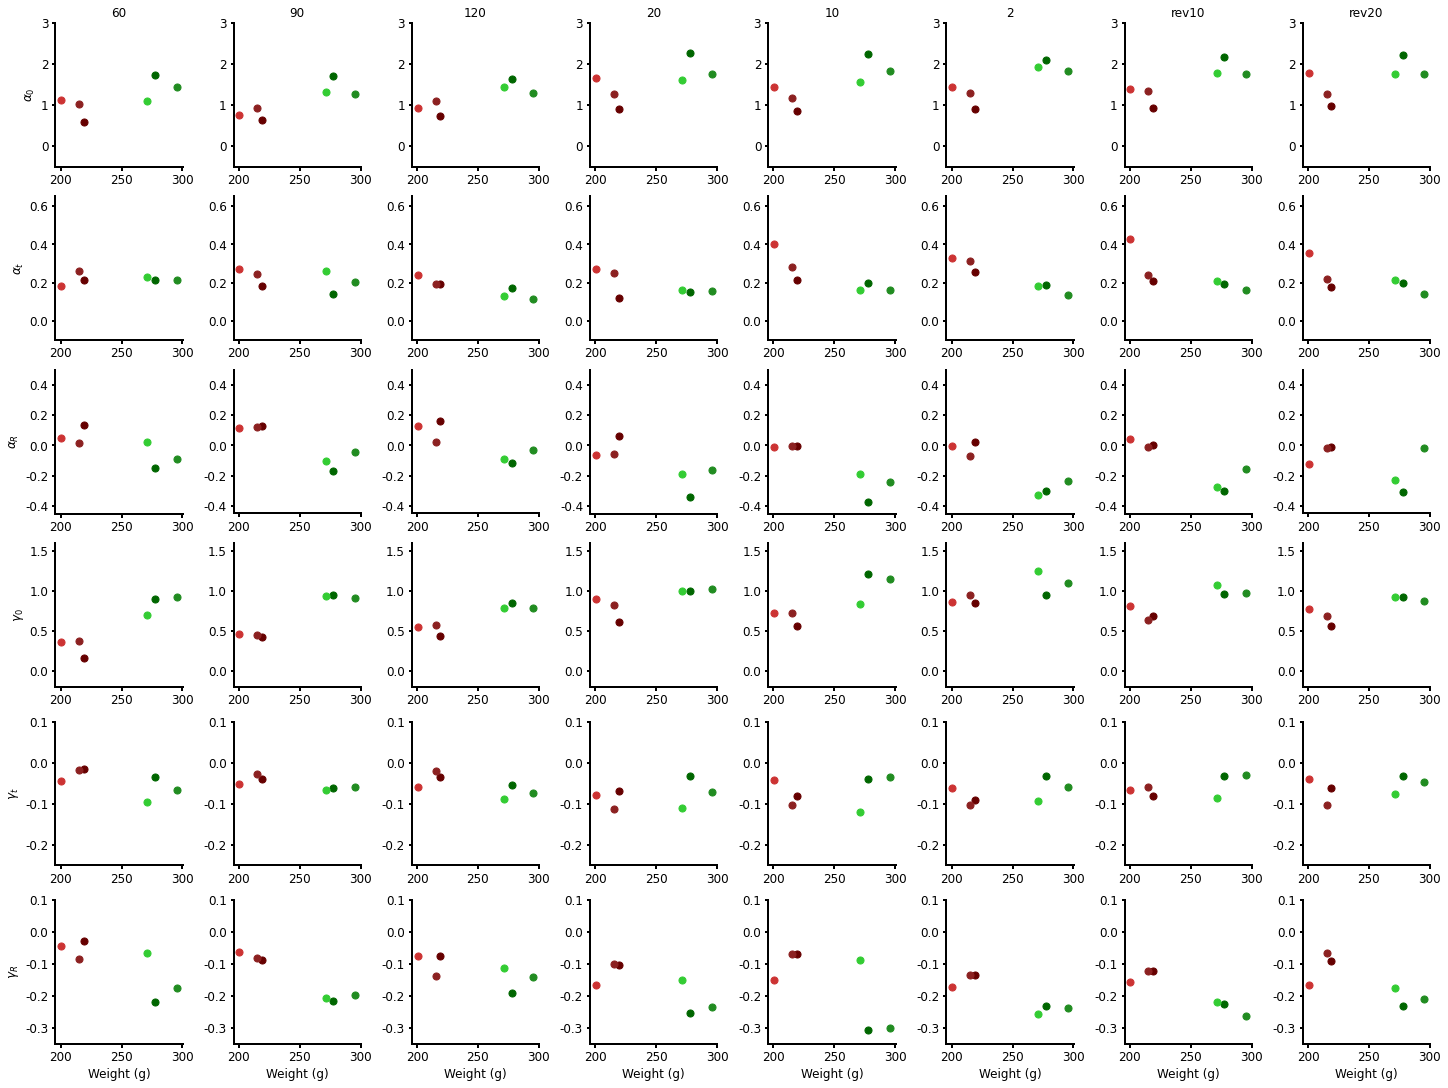

In [ ]:
weights = {'RatF00': 219.20, 
'RatF01': 215.31, 
'RatF02': 200.54,
'RatM00': 277.65,
'RatM01': 295.46,
'RatM02': 271.19,
}
# correlation weight, alpha_0
fig, ax = plt.subplots(6, 8, figsize=(20, 15))

alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R = pickle.load(open("picklejar/main_fitting_results.p", "rb"))
for i, var in enumerate([alpha, alpha_t, alpha_R, gamma, gamma_t, gamma_R]):
    for j, cond in enumerate(["60", "90", "120", "20", "10", "2", "rev10", "rev20"]):
        for animal in animalList:
            ax[i, j].scatter(weights[animal], var[animal][cond], color=rat_markers[animal][0], s=50)
        ax[-1, j].set_xlabel("Weight (g)")
        ax[i, 0].set_ylabel(ylabels[i])
        ax[0, j].set_title(cond)
        ax[i, j].set_ylim(ylims[i])

In [ ]:
# copy only test.p files for all sessions
# compress and upload to google drive
# add animal, session = 'RatM01', 'RatM01_2021_07_22_17_14_48'  to the list
import fnmatch
from os.path import isdir, join
from shutil import copytree, rmtree

def include_patterns(*patterns):
    def _ignore_patterns(path, all_names):
        # Determine names which match one or more patterns (that shouldn't be
        # ignored).
        keep = (name for pattern in patterns for name in fnmatch.filter(all_names, pattern))
        # Ignore file names which *didn't* match any of the patterns given that
        # aren't directory names.
        dir_names = (name for name in all_names if isdir(join(path, name)))
        return set(all_names) - set(keep) - set(dir_names)
    return _ignore_patterns


src = "/home/david/Desktop/DATA"
dst = "/home/david/Desktop/testcopy"
copytree(src, dst, ignore=include_patterns('test.p'))